# K20 4rd p30/50 PCA1/1 Crop.7 Affine.7 + Toe HPLv2 

## annotation_1307_HPLv2Toe_Good.csv

# 20210302-151304

# 101 Course of transfer learning and Fine tune 2021-01-01

## [How-to] 1. k-fold for cross validation

#### Create a simple k-fold for train classification model.

* In this short course you learned:

* data pipline

* transfer learning

* fine tune

* callbacks


todo: move to note.py


In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf

from datetime import datetime
import seaborn as sns

import errno

# albumentations
from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )
import albumentations as A

# from adabelief_tf import AdaBeliefOptimizer

In [2]:
print(tf.__version__)
print(cv2.__version__)

2.3.1
4.3.0


In [3]:
from pytictoc import TicToc

t_timer = TicToc() #create instance of class

t_timer.tic() #Start timer

### 2. Parameters

#### Image size, Batch size, toe/heel-offset.

In [4]:
BATCH_SIZE = 64 # 16 #32 #64 #128 #32 #64 #todo: reduce the BS maybe help to reduce the loss
img_height = 120 #512 #224 #100
img_width = 120 #512 #224 #100

y_offset_toe = 80
y_offset_heel = 280 #400-120=280

#### tf MirroredStrategy seting

In [5]:

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 64, MULTI_BATCH_SIZE: 64


In [6]:
# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 3. Create the training dataset W/ croped


#### Load samples as data-farame

In [7]:

# # data-org #
# ann = 'annotation_1424_merge.csv'
# im_p = 'train/images/'
# CSVNAME = ""


# # data-org-augm#
# ann = 'annotation_2848_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# # data-train # # current best dataset.1424-79.
# ann = 'annotation_1345_good.csv'
# im_p = 'train/images/'
# CSVNAME = "K1345K10L195"

# data-augm #
# ann = 'annotation_2690_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# # data-train-HPL-1123
# ann = 'annotation_1123_HPL_Good.csv'
# im_p = 'train/images/'
# CSVNAME = ""

# data-train # # HPLv2Toe
ann = 'annotation_1307_HPLv2Toe_Good.csv'
im_p = 'train/images/'
CSVNAME = "HPLv2toeK10L195"


df = pd.read_csv(ann)
df[1120:]

images  x1   y1  x2   y2
1120  image_6232.jpg  57  144  79  383
1121  image_6233.jpg  52  146  30  384
1122  image_6234.jpg  47  127  77  381
1123  image_6235.jpg  64  133  25  384
1124  image_6236.jpg  55  145  72  375
...              ...  ..  ...  ..  ...
1302  image_6419.jpg  60  135  70  381
1303  image_6421.jpg  53  157  76  376
1304  image_6422.jpg  49  154  33  375
1305  image_6423.jpg  64  149  76  381
1306  image_6424.jpg  55  147  36  385

[187 rows x 5 columns]

In [8]:
len(df)

1307

#### Shuffle and reset index

In [9]:
# reset index
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.head(10)

images  x1   y1  x2   y2
0  image_0548.png  51  148  73  385
1  image_6329.jpg  62  125  88  384
2  image_0928.png  43  142  73  379
3  image_0997.png  56  146  30  383
4  image_0783.png  67  123  30  383
5  image_0130.png  63  140  29  377
6  image_0299.png  50  103  73  383
7  image_0967.png  58  133  30  382
8  image_0738.png  56  144  82  368
9  image_6347.jpg  69  149  71  385

See, the image_####.jpg now are random.

#### Create tf.dataset (DS)

In [11]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df['images'], df['x1'], df['y1'], df['x2'], df['y2']))
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [12]:
len(list_ds)#.shape() #take(1)

1307

In [13]:
# check The type specification of an element of this dataset.
list_ds.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
for f,x1,y1,x2,y2 in list_ds.take(5):
    print(f'take sample: {f} {x1} {y1} {x2} {y2}')

take sample: b'image_0548.png' 51 148 73 385
take sample: b'image_6329.jpg' 62 125 88 384
take sample: b'image_0928.png' 43 142 73 379
take sample: b'image_0997.png' 56 146 30 383
take sample: b'image_0783.png' 67 123 30 383


In [15]:
# use np decode to UTF-8
print(f.numpy().decode('UTF-8'))

image_0783.png


In [16]:
len(list_ds)

1307

#### Check ds iterator for consuming

In [17]:
# create a Python iterator

it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [18]:
# using iter and consuming its elements using next: every print different image name.

for i in range(4):
    image, x1, y1, x2, y2 = next(it_list_ds)
    print(image.numpy(), x1.numpy(), y1.numpy())

b'image_0548.png' 51 148
b'image_6329.jpg' 62 125
b'image_0928.png' 43 142
b'image_0997.png' 56 146


In [19]:
# image_batch, label_batch = valid_ds_pre_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)


for i in range(4):
    image, x1, y1, x2, y2 = list_ds.as_numpy_iterator().next()# every time create a new iter, so need put iter out of above cell.
    print(image, x1, y1, x2, y2)
    
iter_test_list = list_ds.as_numpy_iterator()
print("===== Create iterator once and pull out to above cell. =====")
for i in range(4):
    image, x1, y1, x2, y2 = iter_test_list.next()
    print(image, x1, y1, x2, y2)


b'image_0548.png' 51 148 73 385
b'image_0548.png' 51 148 73 385
b'image_0548.png' 51 148 73 385
b'image_0548.png' 51 148 73 385
===== Create iterator once and pull out to above cell. =====
b'image_0548.png' 51 148 73 385
b'image_6329.jpg' 62 125 88 384
b'image_0928.png' 43 142 73 379
b'image_0997.png' 56 146 30 383


#### Process path to image tensor in DS

In [20]:

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe(img)
    return img, [x1,y1-y_offset_toe]#Original [0,120]
    #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

#
# map list to ds, Heel part.
#

def decode_crop_png_heel(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel(img)
    return img, [x2,y2-y_offset_heel]#Original [0,120]
    #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [21]:
# Toe ds
train_ds_map_toe = list_ds.map(process_path_toe, num_parallel_calls=AUTOTUNE)

# Heel ds
train_ds_map_heel = list_ds.map(process_path_heel, num_parallel_calls=AUTOTUNE)

In [22]:
# for img, xy in train_ds_map_toe.take(1):
#     print(f'take sample: {xy}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# x

for img, [x, y] in train_ds_map_toe.take(1):
    print(f'take sample: {x} {y}')
    
print('f', f.dtype)
print('x', x.dtype)

take sample: 51 68
f <dtype: 'string'>
x <dtype: 'int64'>


In [23]:
x

<tf.Tensor: shape=(), dtype=int64, numpy=51>

In [24]:
# for f,x1,y1,x2,y2 in train_ds_map.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

#### [new] Split train_ds_pre with ratio of validation %

[ToDo 20210201] keep orignal validation in 0.1, but augmenting train_ds in input layer or in the tf.ds.

[2021-02-23] New k-split ds

In [25]:
# # split Toe
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

# train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
# valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

# print(f'whole samples = {len(train_ds_map_toe)}')
# print(f'val_size = {val_size}')

# print('ds_train = ', tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
# print('ds_valid = ', tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())

In [26]:
# # split Heel
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)


# train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
# valid_ds_map_heel_s = train_ds_map_heel.take(val_size)

# print(len(train_ds_map_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())

In [27]:
# ## testing cell
# kf = []
# for k in range(5):
#     kf.append(train_ds_map_heel.shard(num_shards=5, index=k))
#     print("k =", k,"num=", tf.data.experimental.cardinality(kf[k]).numpy())

In [28]:
# kf

In [29]:

# for img, [x,y] in kf[1].take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# print('y', y.dtype)

In [30]:
# ## testing cell

# range_k_0 = train_ds_map_heel.window(5)

# print(len(range_k_0))
# print(tf.data.experimental.cardinality(range_k_0).numpy())

In [31]:
# ## testing cell

# def get_train_valid_k_split():
#     x = tf.data.Dataset.range(1000)
#     val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    
#     for k in range(5):
#         train_num = x.take(val_size + k*val_size)
#         valid_num = x.skip(k*val_size)
        
#         print("k=", k)
#         print(tf.data.experimental.cardinality(train_num).numpy())
#         print(tf.data.experimental.cardinality(valid_num).numpy())
    
    
# get_train_valid_k_split()

In [32]:
## testing cell

# 
# tf.slice
# tf.data.experimental.choose_from_datasets


# x = list_ds
# val_size = int(tf.data.experimental.cardinality(list_ds).numpy() * 0.2)
x = tf.data.Dataset.range(10)

def check_KFold_ds(x, K=5):
    
    val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    print("val_size=", val_size)
    
    for k in range(K):
#         k_train = x.take(val_size + k*val_size)
#         k_valid = x.skip(k*val_size)
#         k_train = tf.slice(x, k*val_size, val_size) #only for pure tensors not 
#         k_valid = x.skip(k*val_size)

        # may skip twicce to performe kflod
        t_take = x.take(k*val_size)
        t_skip = x.skip(k*val_size+val_size)
        k_train = t_take.concatenate(t_skip)
        
        v_skip = x.skip(k*val_size)
        k_valid = v_skip.take(val_size)

        print("k =", k,"k*val_size+val_size", k*val_size+val_size, "k_train num=", tf.data.experimental.cardinality(k_train).numpy())


        # x = tf.data.Dataset.range(10)
#         for n in k_train:
#             print(n.numpy())
#         for n in k_valid:
#             print(n.numpy())
        
        # list_ds
#         for img, x1, y1, x2, y2 in k_train:
#             print(x1, y1)

        # train_ds_map_toe
#         for img, (x, y) in k_train:
#             print(x.numpy(), y.numpy())

    
    
    
check_KFold_ds(x)
# check_KFold_ds(list_ds)    
# check_KFold_ds(train_ds_map_toe)

val_size= 2
k = 0 k*val_size+val_size 2 k_train num= 8
k = 1 k*val_size+val_size 4 k_train num= 8
k = 2 k*val_size+val_size 6 k_train num= 8
k = 3 k*val_size+val_size 8 k_train num= 8
k = 4 k*val_size+val_size 10 k_train num= 8


In [33]:
# x = tf.data.Dataset.range(10)
# val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
# print("val_size=", val_size)

def get_KFold_ds(x, K=0):
        
    k = K
    # may skip twicce to perform kflod
    # train ds
    t_take = x.take(k*val_size)
    t_skip = x.skip(k*val_size+val_size)
    k_train = t_take.concatenate(t_skip)
    # val ds
    v_skip = x.skip(k*val_size)
    k_valid = v_skip.take(val_size)

    return k_train, k_valid

In [34]:
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.05)
t, v = get_KFold_ds(train_ds_map_toe, 1)

print(tf.data.experimental.cardinality(t).numpy())
print(tf.data.experimental.cardinality(v).numpy())

# for n in v:
#     print(n.numpy())

1242
65


In [35]:
train_ds_map_toe

<ParallelMapDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

In [36]:
v

<TakeDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

# Albumentation pipeline

In [37]:

# # for NO keypoint augment
# transforms = A.Compose([
# #             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
# #             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
# #             A.HorizontalFlip(),
    
#             # try other augm, seems to strong...
#             A.RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
#             A.Equalize(always_apply=False, p=0.5, mode='cv', by_channels=True),
#             A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.8, 1.5), per_channel=False, elementwise=False),
#             A.RandomFog(always_apply=False, p=0.5, fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.25),

# ])


# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label

# def set_shapes(img, label, img_shape=(120,120,3)):
#     img.set_shape(img_shape)
# #     label.set_shape([]) # commited for go around error
#     return img, label





# # for NO keypoint augment AND for OneOf[] for better heel loss.
# transforms_oneof = A.Compose(A.OneOf([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
#             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
#             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=.5)
# #             A.HorizontalFlip(),
#             ]),p=0.5)


# def aug_fn_oneof(image, img_size):
#     data = {"image":image}
#     aug_data = transforms_oneof(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data_oneof(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn_oneof, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label




# # Testing keypoints augment
# transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA (alpha=0.1, always_apply=False, p=1),
#             A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.HorizontalFlip(p=0.5),
#             ]
#             , 
#             keypoint_params=A.KeypointParams(format='xy'),  #currently not works for tf.ds yet.
#             )





# Testing keypoints augment
transforms = A.Compose([
            A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1.0),
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
            A.HorizontalFlip(p=0.5),
            A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.9, 0.99), ratio=(1.0, 1.0), interpolation=0, p=0.7),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine(scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.7),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
    #2021-02-26
#             A.IAAPerspective(scale=(0.05, 0.1), keep_size=True, always_apply=False, p=0.5),#fallout image make train stop. NOT support keypoints!!!!!
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )

# Testing keypoints augment
# @tf.function
def aug_fn(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 








###  for AToe ###
# some pp will outside of image bcs p2 is close to 400.



# Testing keypoints augment
transforms_AToe = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
#             A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
    
            A.HorizontalFlip(p=0.5),
#             A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.75, 0.9), ratio=(1.0, 1.0), interpolation=0, p=0.5),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine (scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.7),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )


# Testing keypoints augment
# @tf.function
def aug_fn_AToe(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms_AToe(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data_AToe(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn_AToe, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 




def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
#     label.set_shape([]) # commited for go around error
    return img, label

#### prepare train_ds_prefetch

In [38]:
def configure_for_performance_cache_train(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


def configure_for_performance_cache_train_AToe(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data_AToe, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds





# def configure_for_performance_cache_train_oneof(ds, cache=True, augment=False):

    
#     """#TODO: need to check the parse logic of ds.cache.
#     if cache:
#         print("Check cache-f1 to file:", cache)
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#             print("Check cache-f2 to file:", cache)
#     else:
#         ds = ds.cache()
#         print("Check cache in memory:", cache)
#     """    
#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
#     if augment:
#         ds = ds.map(partial(process_data_oneof, img_size=120),num_parallel_calls=AUTOTUNE)
#         ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
#     return ds




def configure_for_performance_cache_val(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache
    TODO:test remove ds.shuffle from val_ds.
    .
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


In [39]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe = configure_for_performance_cache_train(train_ds_map_toe)

# # Heel ds_pre
# train_ds_pre_heel = configure_for_performance_cache_val(train_ds_map_heel)

#### All split ds_prefetch
* train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
* valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

* train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
* valid_ds_map_heel_s = train_ds_map_heel.take(val_size)


In [40]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
# valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)

# # Heel ds_pre
# train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
# valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)

#### Check ds_prefetch samples

In [41]:
# # create it_ds once
# it_train_ds_pre_toe_s = iter(train_ds_pre_toe_s)

In [42]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_toe_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')


In [43]:
# # create it_ds once
# it_train_ds_pre_heel_s = iter(train_ds_pre_heel_s)

In [44]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_heel_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')

In [45]:
# # create it_ds once
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)

In [46]:
# %%time

# # for albu keypoint

# # for return aug_img, aug_xy 


# image_batch, label_batch = next(it_valid_ds_pre_toe_s)

# plt.figure(figsize=(8, 8))
# # for images, labels in valid_ds_pre_toe_s.take(1):
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')
        

### 3.Loss function

* mae
* euclidean distance
* others


        # 'x' is [[1, 1, 1]
        #         [1, 1, 1]]
        tf.reduce_sum(x) ==> 6
        tf.reduce_sum(x, 0) ==> [2, 2, 2]
        tf.reduce_sum(x, 1) ==> [3, 3]
        the function is default for 2-D array, therefor, in our 1-D [x1,y1] to [x2,y2] the axis should be '0' or just leave it.
        
        tf.sqrt need 	A tf.Tensor of type bfloat16, half, float32, float64, complex64, complex128
        so, convert it first.

should be -> tf.Tensor([56 39], shape=(2,), dtype=int64)

In [47]:
y_true = [10, 10]
y_pred = [10, 20]

# y_true = [1.00000000000000000000123, 10]
# y_pred = [1.0, 10.000000000000000000000000001]

# y_true = [1.0000123, 10]
# y_pred = [1.0, 10.0000321]


In [48]:
# mae

loss_mae = tf.keras.losses.MAE(
    y_true, y_pred
)

loss_mae

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [49]:
# ed

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.constant(y_true) - tf.constant(y_pred)), 0))

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.Variable(y_true) - tf.Variable(y_pred)), 0))

loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

loss_ed

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [50]:
def ed_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

# fix NaN in euclidean distance
# tf.maximum(d, 1e-9), to keep atlease is 1e-9.
# def ed_loss(y_true, y_pred):
#     return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0), 1e-9))


In [51]:
# check the euclidean distance loss
ed_loss(y_true, y_pred).numpy()

10.0

In [52]:
ed_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

#### mean Euclidean distance 

* here the y_true and y_pred is 2-D array. the axis use 1.


* NOTE: LB評分的mean euclidean distance功能，應該跟model.evaluate()一樣so不需重新寫。evaluate()會自動用loss (model.metrics_names)計算後在自動平均，而模型loss我們是用ed-loss取代。

In [53]:
# y_true = [[60, 76],
#        [58, 49 ],
#        [63, 67 ],
#        [58 , 57]]
# y_pred = [[59.927303, 76.471214],
#        [58.056904, 49.98754 ],
#        [63.067844, 67.03861 ],
#        [58.70202 , 57.372707]]

y_true = [[60, 70],
       [70, 80]]
y_pred = [[61, 71],
       [72, 82]]

# y_true = [(60, 70),
#        (70, 80)]
# y_pred = [(61, 71),
#        (72, 82)]

In [54]:
tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [4., 4.]], dtype=float32)>

In [55]:
tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 8.], dtype=float32)>

In [56]:
def ed_metric_2d(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1))


In [57]:
ed_metric_2d(y_true, y_pred).numpy()

array([1.4142135, 2.828427 ], dtype=float32)

In [58]:
ed_metric_2d(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.4142135, 2.828427 ], dtype=float32)>

In [59]:
# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def ed_metric_2d_mean(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)))

In [60]:
# for re-scale back xy 
# return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# return img, [(x2-60)/60,((y2-y_offset_toe)-60)/60]#normalized [-1,1] 

# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def edRescal(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast((y_true*60)+60, tf.float32) - tf.cast((y_pred*60)+60, tf.float32)), 1)))

In [61]:
ed_metric_2d_mean(y_true, y_pred).numpy()

2.1213202

In [62]:
ed_metric_2d_mean(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=2.1213202>

# EFNE Training

maybe mae better than ed loss?

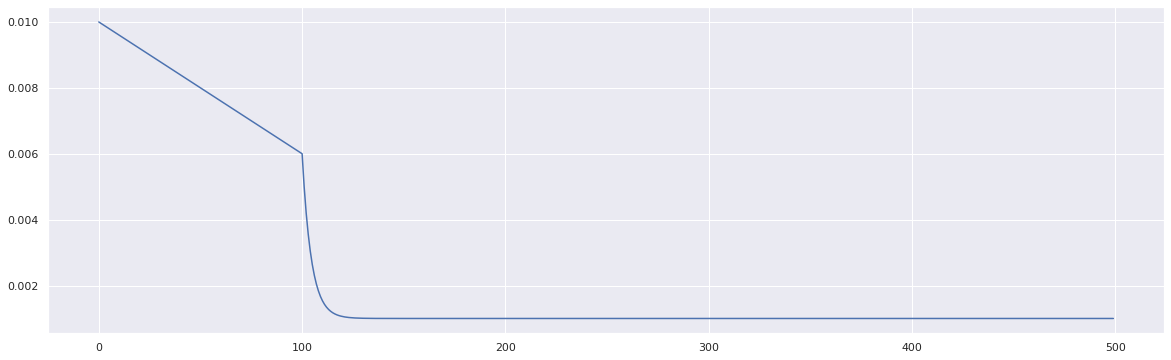

In [63]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.006
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.8

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [64]:
print('{} ~ {}'.format(min(y), max(y)))

0.001 ~ 0.01


In [65]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 0.01

1	 0.00996

2	 0.00992

3	 0.00988

4	 0.00984

5	 0.0098

6	 0.00976

7	 0.00972

8	 0.00968

9	 0.009640000000000001

10	 0.009600000000000001

11	 0.00956

12	 0.00952

13	 0.00948

14	 0.00944

15	 0.0094

16	 0.00936

17	 0.00932

18	 0.00928

19	 0.00924

20	 0.0092

21	 0.00916

22	 0.00912

23	 0.00908

24	 0.00904

25	 0.009000000000000001

26	 0.00896

27	 0.00892

28	 0.00888

29	 0.00884

30	 0.0088

31	 0.00876

32	 0.00872

33	 0.00868

34	 0.00864

35	 0.0086

36	 0.00856

37	 0.00852

38	 0.00848

39	 0.00844

40	 0.0084

41	 0.00836

42	 0.008320000000000001

43	 0.00828

44	 0.00824

45	 0.0082

46	 0.00816

47	 0.00812

48	 0.00808

49	 0.00804

50	 0.008

51	 0.00796

52	 0.00792

53	 0.00788

54	 0.00784

55	 0.0078

56	 0.0077599999999999995

57	 0.007719999999999999

58	 0.00768

59	 0.00764

60	 0.0076

61	 0.00756

62	 0.007520000000000001

63	 0.0074800000000000005

64	 0.00744

65	 0.0074

66	 0.00736

67	 0.00732

68	 0.00728

69	 0.00724

70	 0.007

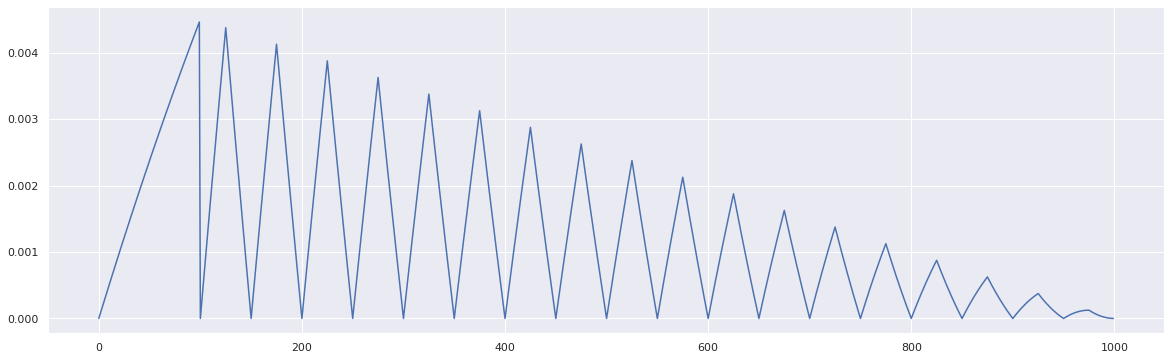

In [66]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))
    x = np.abs(iterations/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#     print(decay)
    return lr * (base_part-decay) * lr_decay # supressed the lr!


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [67]:
print('{} ~ {}'.format(min(y), max(y)))

2.4999999999999966e-08 ~ 0.004459954505


In [68]:
# 2.4999999999999966e-08 ~ 0.004459954505 1e-2~1e-6 

In [69]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUp(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-2 # currently best for foot pp
#     base_lr = 1e-8# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 100
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-2
#     first_decay_steps = 100


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUp(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

In [70]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUpLSW(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-3 # currently best for foot pp
#     base_lr = 1e-6# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 20
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-3
#     first_decay_steps = 50


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch-lr_ramp_ep)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUpLSW(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

CPU times: user 577 ms, sys: 68.9 ms, total: 646 ms
Wall time: 549 ms


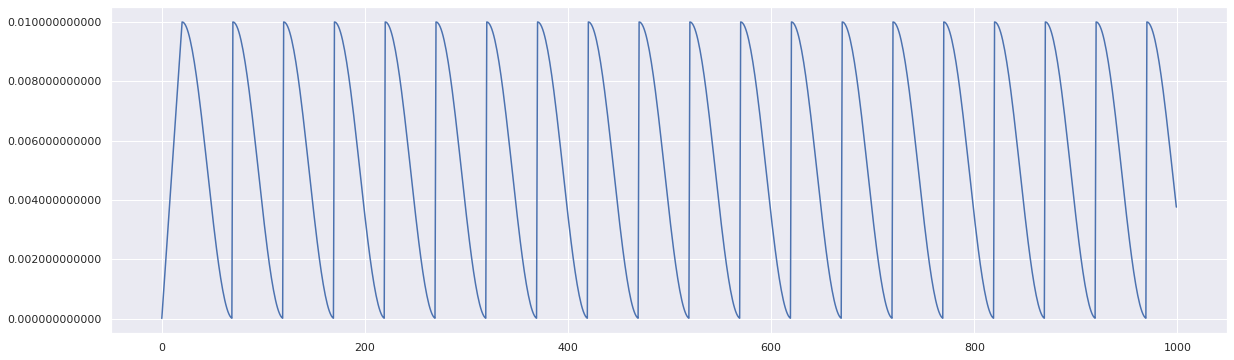

In [71]:
%%time
"""
cosine_decay_restarts是cosine_decay的cycle版本。
first_decay_steps是指第一次完全下降的step數，
t_mul是指每一次循環的步數都將乘以t_mul倍，
m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
alpha
"""

from matplotlib.ticker import FormatStrFormatter



ep_num = 1000



def CosineDecayCLRWarmUpLSW_2(epoch):
    
    #step_size = 25 # currently best for foot pp
    max_lr = 1e-2 # currently best for foot pp
    base_lr = 1e-6# 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 20
    lr_sus_ep  = 0
    #lr_decay   = 0.8


    initial_learning_rate = 1e-2
    first_decay_steps = 50


    lr_decayed_fn = (
      tf.keras.experimental.CosineDecayRestarts(
          initial_learning_rate,
          first_decay_steps,
          t_mul=1,
          m_mul=1,
          alpha = 0.000001,
          name="CCosineDecayRestarts"))
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
    else:
        lr = lr_decayed_fn(epoch-lr_ramp_ep)
    return lr



rng = [i for i in range(ep_num)]
y = [CosineDecayCLRWarmUpLSW_2(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
# plt.ylim(.0000000000000001, .01)# for too large loss
ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
plt.plot(rng, y)

In [72]:
print('{} ~ {}'.format(min(y), max(y)))

1e-06 ~ 0.009999999776482582


In [73]:
# 1.8774175103430935e-08 ~ 0.0010000000474974513 1e-3 1e-6

In [74]:
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [75]:
# Callback for printing the LR at the end of each epoch.
class PrintLRtoe(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
#     def on_epoch_end(self, epoch, logs=None):
#         print('\n[{}] Learning rate for epoch {} is {}'.format(
#             datetime.now().strftime("%Y%m%d-%H%M-%S"), 
#             epoch + 1,
#             self.model.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_toe.optimizer._decayed_lr(tf.float32).numpy()))

In [76]:
# Callback for printing the LR at the end of each epoch.
class PrintLRheel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
#                                               model_heel.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_heel.optimizer._decayed_lr(tf.float32).numpy()))

### Output dir and models

In [77]:
def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

In [78]:
monitor = 'val_loss' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S") 

# mk_log_dir(datetime.now().strftime("%Y%m%d-%H%M%S") )  

In [79]:
# use once at the time
mk_log_dir(log_dir_name)

# Toe

In [80]:
model_name = 'EfficientNetB0'

In [81]:
#get_best_model_name

# best_model_name = './' + model_name + '_bs-' + str(BATCH_SIZE) + '_s-' + str(img_height) + '_' + "ep-{epoch:02d}-vloss-{val_loss:.2f}" +'_best-weight.h5'
# best_model_name = '{model_name}-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#best_model_name = './' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + monitor + '_best.h5'
# best_model_name = './Leaf_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

# best_model_name = './cop' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

def get_best_model_name(th, K):
    return './' + log_dir_name + '/' + th + '_K' + K + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

# th = 'toe'
# # th = 'heel'

# # print(get_best_model_name(th,K))

# best_model_name = get_best_model_name(th, K)


# best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
#                              save_best_only = True, 
#                              save_weights_only = False,
#                              monitor = monitor, 
#                              mode = 'auto', verbose = 1)
# print('best_model_name:', best_model_name)

In [82]:
logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [83]:
# callbacks = [
# #     tensorboard_callback,
#     best_model_save,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=20), #patience=step_size or ep_num
# #     lr_reduceonplateau,
#     tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#     PrintLRtoe()
# ]

In [84]:
# Transfer learning from pre-trained weights
def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    # Freeze the pretrained weights
    base_model.trainable = False
    print("base_model.trainable : ", base_model.trainable)

    # Rebuild top
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
    dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
    outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

    # Compile new model
    model = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)

    
    return model

In [85]:
# """Supervised pre-training 減少每次fold都要重新train的時間
# 只先改toe"""

# # Transfer learning from pre-trained weights
# def load_pretrained_efn_model():
#     pre_model_toe_name = "20210224-200728/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5"
#     model = tf.keras.models.load_model(pre_model_toe_name,compile=False)

#     # Freeze the pretrained weights
#     model.trainable = False
# #     print("base_model.trainable : ", base_model.trainable)

# #     # Rebuild top
# #     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# #     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
# #     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
# #     outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

# #     # Compile new model
# #     model = tf.keras.Model(base_model.input, outputs, name=model_name)


# #     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 4 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             print('layer trainable +1', layer.name)
#             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)

    
#     return model

In [86]:
def unfreeze_model(model):
#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166  block3a_expand_conv 195
#
    model.trainable = True
    set_trainable = False
    for layer in model.layers:
        if layer.name == 'block3a_expand_conv': 
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)


In [87]:
# top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
# drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
# outputnum = 2
# with strategy.scope():
#     model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)

In [88]:
# len(model_toe.layers)

In [89]:
# tt = 0
# nt = 0
# for layer in model_toe.layers:
#     if layer.trainable:
#         tt +=1
#         print(f'{layer.name}')
#     else:
#         nt +=1
# print(f'tt: {tt}, nt:{nt}')

In [90]:
def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print('\n*********************************** Start fine tune ***********************************')
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')
    print('*********************************** Start fine tune ***********************************')

In [91]:
# count_model_trainOrNot_layers(model_toe)

In [92]:
# model_toe.summary()

In [93]:
# %%time

# # fit the model on all data
# history_toe = model_toe.fit(train_ds_pre_toe_s, 
#                       verbose=1, 
#                       epochs=ep_num_transf, 
#                       validation_data=valid_ds_pre_toe_s, 
#                       callbacks=callbacks)#, validation_split=0.1)

# K-Fold Training

2021-02-23 v1

### Toe K-model

In [94]:
%%time

# big K = 5 (fold 0 ~ 4) 
KFlodNum = 20



history_toe = []
history_toe_finetune = []

#above until 'train_ds_map_toe now' to 'train_ds_map_toe_s', 'valid_ds_map_toe_s'
for k in range(KFlodNum):
    
    
    # Split data to train/valid with K-Fold #
    print("\n \n K = ", k, "\n")
    # Toe split
    train_ds_map_toe_s, valid_ds_map_toe_s = get_KFold_ds(train_ds_map_toe, K=k)
    
    # Toe ds_pre
    train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
    valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)
    
    
#     # heel split
#     train_ds_map_heel_s, valid_ds_map_heel_s = get_KFold_ds(train_ds_map_heel, K=k)
#     # Heel ds_pre
#     train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
#     valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)
    
    
    # Train K-Model with transfer learnling #
    
    # Toe model, TL
    th = 'toe'
    # th = 'heel'
    best_model_name = get_best_model_name(th, K=str(k))
    best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = monitor, 
                                 mode = 'auto', verbose = 1)
    callbacks_toe_tl = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=30), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
                        PrintLRtoe()
                        ]
    callbacks_toe_fn = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=150), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp, CosineDecayCLRWarmUpLSW
                        PrintLRtoe()
                    ]
    print('best_model_name:', best_model_name)


    top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
    drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
    outputnum = 2
    with strategy.scope():
        model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)
#         model_toe = load_pretrained_efn_model() # from 20210224-200728 ed5.3
#         count_model_trainOrNot_layers(model_toe)
        
    # fit the model on all data
    hist = model_toe.fit(train_ds_pre_toe_s, 
                          verbose=1, 
                          epochs=ep_num_transf, 
                          validation_data=valid_ds_pre_toe_s, 
                          callbacks=callbacks_toe_tl)#, validation_split=0.1)
    history_toe.append(hist)
    
      
    # Train K-Model with fine tune #
    
    # Toe model, FT
    unfreeze_model(model_toe)
    count_model_trainOrNot_layers(model_toe)
    # fit the model on all data
    hist = model_toe.fit(train_ds_pre_toe_s, 
                          verbose=1, 
                          epochs=ep_num, 
                          validation_data=valid_ds_pre_toe_s, 
                          callbacks=callbacks_toe_fn)#, validation_split=0.1)
    history_toe_finetune.append(hist)



 
 K =  0 

Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210302-151304/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

19/20 [===========================>..] - ETA: 0s - loss: 14.6286
Epoch 00017: val_loss improved from 10.94763 to 10.74251, saving model to ./20210302-151304/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 41ms/step - loss: 14.6566 - val_loss: 10.7425

[20210302-1515-09] Learning rate for epoch 18 is 0.009320000186562538
Epoch 18/500
19/20 [===========================>..] - ETA: 0s - loss: 14.5511
Epoch 00018: val_loss improved from 10.74251 to 10.70479, saving model to ./20210302-151304/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 41ms/step - loss: 14.5916 - val_loss: 10.7048

[20210302-1515-15] Learning rate for epoch 19 is 0.009279999881982803
Epoch 19/500
19/20 [===========================>..] - ETA: 0s - loss: 14.5616
Epoch 00019: val_loss did not improve from 10.70479
20/20 [==============================] - 0s 21ms/step - loss: 14.5527 - val_loss: 10.9180

[20210302-1515-20] Learning rate


[20210302-1517-20] Learning rate for epoch 44 is 0.00827999971807003
Epoch 44/500
19/20 [===========================>..] - ETA: 0s - loss: 13.7321
Epoch 00044: val_loss did not improve from 10.41090
20/20 [==============================] - 0s 22ms/step - loss: 13.7346 - val_loss: 11.6177

[20210302-1517-25] Learning rate for epoch 45 is 0.00824000034481287
Epoch 45/500
20/20 [==============================] - ETA: 0s - loss: 13.7121
Epoch 00045: val_loss did not improve from 10.41090
20/20 [==============================] - 0s 22ms/step - loss: 13.7121 - val_loss: 11.0035

[20210302-1517-30] Learning rate for epoch 46 is 0.008200000040233135
Epoch 46/500
20/20 [==============================] - ETA: 0s - loss: 13.6368
Epoch 00046: val_loss did not improve from 10.41090
20/20 [==============================] - 0s 22ms/step - loss: 13.6368 - val_loss: 11.0880

[20210302-1517-35] Learning rate for epoch 47 is 0.0081599997356534
Epoch 47/500
20/20 [==============================] - ETA: 0

20/20 [==============================] - 2s 96ms/step - loss: 11.7194 - val_loss: 8.6079

[20210302-1521-07] Learning rate for epoch 10 is 0.0004464008961804211
Epoch 10/1000
20/20 [==============================] - ETA: 0s - loss: 11.4802
Epoch 00010: val_loss did not improve from 8.60787
20/20 [==============================] - 1s 67ms/step - loss: 11.4802 - val_loss: 8.6675

[20210302-1521-13] Learning rate for epoch 11 is 0.0004954455071128905
Epoch 11/1000
20/20 [==============================] - ETA: 0s - loss: 11.4019
Epoch 00011: val_loss did not improve from 8.60787
20/20 [==============================] - 1s 67ms/step - loss: 11.4019 - val_loss: 8.8773

[20210302-1521-19] Learning rate for epoch 12 is 0.0005443901172839105
Epoch 12/1000
20/20 [==============================] - ETA: 0s - loss: 11.0022
Epoch 00012: val_loss did not improve from 8.60787
20/20 [==============================] - 1s 67ms/step - loss: 11.0022 - val_loss: 8.9565

[20210302-1521-25] Learning rate for 

20/20 [==============================] - ETA: 0s - loss: 8.4826
Epoch 00036: val_loss did not improve from 7.58348
20/20 [==============================] - 1s 64ms/step - loss: 8.4826 - val_loss: 8.4721

[20210302-1523-51] Learning rate for epoch 37 is 0.0017355084419250488
Epoch 37/1000
20/20 [==============================] - ETA: 0s - loss: 8.4723
Epoch 00037: val_loss did not improve from 7.58348
20/20 [==============================] - 1s 69ms/step - loss: 8.4723 - val_loss: 7.6007

[20210302-1523-57] Learning rate for epoch 38 is 0.0017818533815443516
Epoch 38/1000
20/20 [==============================] - ETA: 0s - loss: 8.3855
Epoch 00038: val_loss did not improve from 7.58348
20/20 [==============================] - 1s 69ms/step - loss: 8.3855 - val_loss: 7.7552

[20210302-1524-03] Learning rate for epoch 39 is 0.0018280982039868832
Epoch 39/1000
20/20 [==============================] - ETA: 0s - loss: 8.5070
Epoch 00039: val_loss did not improve from 7.58348
20/20 [===========


[20210302-1526-33] Learning rate for epoch 64 is 0.002951723290607333
Epoch 64/1000
20/20 [==============================] - ETA: 0s - loss: 7.4822
Epoch 00064: val_loss did not improve from 5.58999
20/20 [==============================] - 1s 67ms/step - loss: 7.4822 - val_loss: 6.7004

[20210302-1526-39] Learning rate for epoch 65 is 0.0029953685589134693
Epoch 65/1000
20/20 [==============================] - ETA: 0s - loss: 7.5018
Epoch 00065: val_loss did not improve from 5.58999
20/20 [==============================] - 1s 68ms/step - loss: 7.5018 - val_loss: 6.3906

[20210302-1526-45] Learning rate for epoch 66 is 0.0030389137100428343
Epoch 66/1000
20/20 [==============================] - ETA: 0s - loss: 7.6922
Epoch 00066: val_loss did not improve from 5.58999
20/20 [==============================] - 1s 64ms/step - loss: 7.6922 - val_loss: 6.0984

[20210302-1526-51] Learning rate for epoch 67 is 0.003082358743995428
Epoch 67/1000
20/20 [==============================] - ETA: 0s 

20/20 [==============================] - ETA: 0s - loss: 7.3851
Epoch 00092: val_loss did not improve from 5.58999
20/20 [==============================] - 1s 65ms/step - loss: 7.3851 - val_loss: 6.8384

[20210302-1529-26] Learning rate for epoch 93 is 0.004176836460828781
Epoch 93/1000
20/20 [==============================] - ETA: 0s - loss: 7.1837
Epoch 00093: val_loss did not improve from 5.58999
20/20 [==============================] - 1s 66ms/step - loss: 7.1837 - val_loss: 7.0414

[20210302-1529-32] Learning rate for epoch 94 is 0.004217581823468208
Epoch 94/1000
20/20 [==============================] - ETA: 0s - loss: 6.9508
Epoch 00094: val_loss did not improve from 5.58999
20/20 [==============================] - 1s 68ms/step - loss: 6.9508 - val_loss: 7.5523

[20210302-1529-38] Learning rate for epoch 95 is 0.004258227068930864
Epoch 95/1000
20/20 [==============================] - ETA: 0s - loss: 7.3000
Epoch 00095: val_loss did not improve from 5.58999
20/20 [==============

20/20 [==============================] - ETA: 0s - loss: 6.6981
Epoch 00119: val_loss did not improve from 5.31108
20/20 [==============================] - 1s 65ms/step - loss: 6.6981 - val_loss: 5.9838

[20210302-1532-09] Learning rate for epoch 120 is 0.003347905818372965
Epoch 120/1000
20/20 [==============================] - ETA: 0s - loss: 6.9295
Epoch 00120: val_loss did not improve from 5.31108
20/20 [==============================] - 1s 65ms/step - loss: 6.9295 - val_loss: 5.5692

[20210302-1532-15] Learning rate for epoch 121 is 0.0035200880374759436
Epoch 121/1000
20/20 [==============================] - ETA: 0s - loss: 6.7520
Epoch 00121: val_loss did not improve from 5.31108
20/20 [==============================] - 1s 68ms/step - loss: 6.7520 - val_loss: 6.2233

[20210302-1532-21] Learning rate for epoch 122 is 0.003691870253533125
Epoch 122/1000
20/20 [==============================] - ETA: 0s - loss: 6.9170
Epoch 00122: val_loss did not improve from 5.31108
20/20 [=======

20/20 [==============================] - ETA: 0s - loss: 6.3452
Epoch 00147: val_loss did not improve from 5.31108
20/20 [==============================] - 1s 66ms/step - loss: 6.3452 - val_loss: 5.5381

[20210302-1534-56] Learning rate for epoch 148 is 0.0005121753201819956
Epoch 148/1000
20/20 [==============================] - ETA: 0s - loss: 6.1940
Epoch 00148: val_loss did not improve from 5.31108
20/20 [==============================] - 1s 69ms/step - loss: 6.1940 - val_loss: 5.6210

[20210302-1535-02] Learning rate for epoch 149 is 0.00034119191695936024
Epoch 149/1000
20/20 [==============================] - ETA: 0s - loss: 6.2369
Epoch 00149: val_loss did not improve from 5.31108
20/20 [==============================] - 1s 67ms/step - loss: 6.2369 - val_loss: 5.5547

[20210302-1535-08] Learning rate for epoch 150 is 0.00017060847312677652
Epoch 150/1000
20/20 [==============================] - ETA: 0s - loss: 6.0658
Epoch 00150: val_loss did not improve from 5.31108
20/20 [===

20/20 [==============================] - ETA: 0s - loss: 7.0204
Epoch 00175: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 68ms/step - loss: 7.0204 - val_loss: 6.0462

[20210302-1537-44] Learning rate for epoch 176 is 0.004124999977648258
Epoch 176/1000
20/20 [==============================] - ETA: 0s - loss: 7.0389
Epoch 00176: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 65ms/step - loss: 7.0389 - val_loss: 6.6119

[20210302-1537-50] Learning rate for epoch 177 is 0.003955216612666845
Epoch 177/1000
20/20 [==============================] - ETA: 0s - loss: 6.7263
Epoch 00177: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 68ms/step - loss: 6.7263 - val_loss: 6.0731

[20210302-1537-56] Learning rate for epoch 178 is 0.003785833017900586
Epoch 178/1000
20/20 [==============================] - ETA: 0s - loss: 6.5515
Epoch 00178: val_loss did not improve from 5.13184
20/20 [========

20/20 [==============================] - ETA: 0s - loss: 5.9563
Epoch 00203: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 65ms/step - loss: 5.9563 - val_loss: 5.5865

[20210302-1540-31] Learning rate for epoch 204 is 0.00047855067532509565
Epoch 204/1000
20/20 [==============================] - ETA: 0s - loss: 5.9435
Epoch 00204: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 64ms/step - loss: 5.9435 - val_loss: 5.5605

[20210302-1540-37] Learning rate for epoch 205 is 0.0006371343042701483
Epoch 205/1000
20/20 [==============================] - ETA: 0s - loss: 5.7943
Epoch 00205: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 70ms/step - loss: 5.7943 - val_loss: 5.6746

[20210302-1540-43] Learning rate for epoch 206 is 0.0007953179883770645
Epoch 206/1000
20/20 [==============================] - ETA: 0s - loss: 5.7923
Epoch 00206: val_loss did not improve from 5.13184
20/20 [====

20/20 [==============================] - ETA: 0s - loss: 6.3103
Epoch 00231: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 68ms/step - loss: 6.3103 - val_loss: 6.5264

[20210302-1543-19] Learning rate for epoch 232 is 0.002922292333096266
Epoch 232/1000
20/20 [==============================] - ETA: 0s - loss: 6.2270
Epoch 00232: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 64ms/step - loss: 6.2270 - val_loss: 6.3358

[20210302-1543-25] Learning rate for epoch 233 is 0.002764907432720065
Epoch 233/1000
20/20 [==============================] - ETA: 0s - loss: 6.2802
Epoch 00233: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 61ms/step - loss: 6.2802 - val_loss: 6.1822

[20210302-1543-30] Learning rate for epoch 234 is 0.0026079227682203054
Epoch 234/1000
20/20 [==============================] - ETA: 0s - loss: 6.0419
Epoch 00234: val_loss did not improve from 5.13184
20/20 [=======

20/20 [==============================] - ETA: 0s - loss: 5.7757
Epoch 00259: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 69ms/step - loss: 5.7757 - val_loss: 5.8554

[20210302-1546-06] Learning rate for epoch 260 is 0.0013340371660888195
Epoch 260/1000
20/20 [==============================] - ETA: 0s - loss: 5.9542
Epoch 00260: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 65ms/step - loss: 5.9542 - val_loss: 5.6601

[20210302-1546-12] Learning rate for epoch 261 is 0.0014802219811826944
Epoch 261/1000
20/20 [==============================] - ETA: 0s - loss: 5.8231
Epoch 00261: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 69ms/step - loss: 5.8231 - val_loss: 6.2319

[20210302-1546-18] Learning rate for epoch 262 is 0.0016260069096460938
Epoch 262/1000
20/20 [==============================] - ETA: 0s - loss: 6.0427
Epoch 00262: val_loss did not improve from 5.13184
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 5.8790
Epoch 00287: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 65ms/step - loss: 5.8790 - val_loss: 6.1031

[20210302-1548-53] Learning rate for epoch 288 is 0.001853971160016954
Epoch 288/1000
20/20 [==============================] - ETA: 0s - loss: 5.8449
Epoch 00288: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 67ms/step - loss: 5.8449 - val_loss: 5.8999

[20210302-1548-59] Learning rate for epoch 289 is 0.001708985073491931
Epoch 289/1000
20/20 [==============================] - ETA: 0s - loss: 5.8567
Epoch 00289: val_loss did not improve from 5.13184
20/20 [==============================] - 1s 68ms/step - loss: 5.8567 - val_loss: 5.8790

[20210302-1549-05] Learning rate for epoch 290 is 0.0015643991064280272
Epoch 290/1000
20/20 [==============================] - ETA: 0s - loss: 5.7914
Epoch 00290: val_loss did not improve from 5.13184
20/20 [=======

20/20 [==============================] - ETA: 0s - loss: 5.8948
Epoch 00315: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 64ms/step - loss: 5.8948 - val_loss: 5.5367

[20210302-1551-41] Learning rate for epoch 316 is 0.002055136952549219
Epoch 316/1000
20/20 [==============================] - ETA: 0s - loss: 5.5082
Epoch 00316: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 68ms/step - loss: 5.5082 - val_loss: 5.8482

[20210302-1551-47] Learning rate for epoch 317 is 0.002188923070207238
Epoch 317/1000
20/20 [==============================] - ETA: 0s - loss: 6.0464
Epoch 00317: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 67ms/step - loss: 6.0464 - val_loss: 5.6160

[20210302-1551-53] Learning rate for epoch 318 is 0.00232230918481946
Epoch 318/1000
20/20 [==============================] - ETA: 0s - loss: 5.7550
Epoch 00318: val_loss did not improve from 5.08243
20/20 [=========

20/20 [==============================] - ETA: 0s - loss: 5.5711
Epoch 00343: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 67ms/step - loss: 5.5711 - val_loss: 5.4818

[20210302-1554-28] Learning rate for epoch 344 is 0.0009200365166179836
Epoch 344/1000
20/20 [==============================] - ETA: 0s - loss: 5.5191
Epoch 00344: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 68ms/step - loss: 5.5191 - val_loss: 5.5683

[20210302-1554-34] Learning rate for epoch 345 is 0.0007874493021517992
Epoch 345/1000
20/20 [==============================] - ETA: 0s - loss: 5.6934
Epoch 00345: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 65ms/step - loss: 5.6934 - val_loss: 5.4617

[20210302-1554-40] Learning rate for epoch 346 is 0.0006552619743160903
Epoch 346/1000
20/20 [==============================] - ETA: 0s - loss: 5.6771
Epoch 00346: val_loss did not improve from 5.08243
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 5.7111
Epoch 00371: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 68ms/step - loss: 5.7111 - val_loss: 5.8068

[20210302-1557-16] Learning rate for epoch 372 is 0.00264185038395226
Epoch 372/1000
20/20 [==============================] - ETA: 0s - loss: 6.0767
Epoch 00372: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 65ms/step - loss: 6.0767 - val_loss: 7.4653

[20210302-1557-22] Learning rate for epoch 373 is 0.0027632375713437796
Epoch 373/1000
20/20 [==============================] - ETA: 0s - loss: 5.9241
Epoch 00373: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 65ms/step - loss: 5.9241 - val_loss: 5.6696

[20210302-1557-28] Learning rate for epoch 374 is 0.0028842249885201454
Epoch 374/1000
20/20 [==============================] - ETA: 0s - loss: 6.1412
Epoch 00374: val_loss did not improve from 5.08243
20/20 [=======

20/20 [==============================] - ETA: 0s - loss: 5.2105
Epoch 00399: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 68ms/step - loss: 5.2105 - val_loss: 5.2788

[20210302-1600-03] Learning rate for epoch 400 is 0.00012048848293488845
Epoch 400/1000
20/20 [==============================] - ETA: 0s - loss: 5.4161
Epoch 00400: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 68ms/step - loss: 5.4161 - val_loss: 5.2651

[20210302-1600-09] Learning rate for epoch 401 is 3.000000106112566e-07
Epoch 401/1000
20/20 [==============================] - ETA: 0s - loss: 5.3976
Epoch 00401: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 68ms/step - loss: 5.3976 - val_loss: 5.2593

[20210302-1600-15] Learning rate for epoch 402 is 0.00012008751946268603
Epoch 402/1000
20/20 [==============================] - ETA: 0s - loss: 5.4709
Epoch 00402: val_loss did not improve from 5.08243
20/20 [===

20/20 [==============================] - ETA: 0s - loss: 5.9980
Epoch 00427: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 68ms/step - loss: 5.9980 - val_loss: 6.7588

[20210302-1602-50] Learning rate for epoch 428 is 0.0026358228642493486
Epoch 428/1000
20/20 [==============================] - ETA: 0s - loss: 5.7747
Epoch 00428: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 69ms/step - loss: 5.7747 - val_loss: 5.4067

[20210302-1602-56] Learning rate for epoch 429 is 0.0025168342981487513
Epoch 429/1000
20/20 [==============================] - ETA: 0s - loss: 5.6044
Epoch 00429: val_loss did not improve from 5.08243
20/20 [==============================] - 1s 65ms/step - loss: 5.6044 - val_loss: 5.4860

[20210302-1603-02] Learning rate for epoch 430 is 0.0023982457350939512
Epoch 430/1000
20/20 [==============================] - ETA: 0s - loss: 5.6519
Epoch 00430: val_loss did not improve from 5.08243
20/20 [=====


[20210302-1605-32] Learning rate for epoch 8 is 0.009720000438392162
Epoch 8/500
20/20 [==============================] - ETA: 0s - loss: 16.2499
Epoch 00008: val_loss improved from 11.64669 to 11.28062, saving model to ./20210302-151304/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 39ms/step - loss: 16.2499 - val_loss: 11.2806

[20210302-1605-37] Learning rate for epoch 9 is 0.009680000133812428
Epoch 9/500
18/20 [==========================>...] - ETA: 0s - loss: 16.1260
Epoch 00009: val_loss improved from 11.28062 to 11.07327, saving model to ./20210302-151304/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 39ms/step - loss: 16.1465 - val_loss: 11.0733

[20210302-1605-42] Learning rate for epoch 10 is 0.009639999829232693
Epoch 10/500
19/20 [===========================>..] - ETA: 0s - loss: 16.2810
Epoch 00010: val_loss improved from 11.07327 to 10.98679, saving model to ./20210302-151304/toe

19/20 [===========================>..] - ETA: 0s - loss: 14.3628
Epoch 00034: val_loss did not improve from 10.11727
20/20 [==============================] - 0s 22ms/step - loss: 14.3627 - val_loss: 11.2397

[20210302-1607-50] Learning rate for epoch 35 is 0.00863999966531992
Epoch 35/500
20/20 [==============================] - ETA: 0s - loss: 14.3035
Epoch 00035: val_loss did not improve from 10.11727
20/20 [==============================] - 0s 21ms/step - loss: 14.3035 - val_loss: 10.8514

[20210302-1607-55] Learning rate for epoch 36 is 0.00860000029206276
Epoch 36/500
19/20 [===========================>..] - ETA: 0s - loss: 13.9735
Epoch 00036: val_loss did not improve from 10.11727
20/20 [==============================] - 0s 22ms/step - loss: 13.9727 - val_loss: 10.7820

[20210302-1607-59] Learning rate for epoch 37 is 0.008559999987483025
Epoch 37/500
20/20 [==============================] - ETA: 0s - loss: 13.7447
Epoch 00037: val_loss did not improve from 10.11727
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 13.3035
Epoch 00062: val_loss did not improve from 10.08316
20/20 [==============================] - 0s 21ms/step - loss: 13.3035 - val_loss: 11.9007

[20210302-1610-09] Learning rate for epoch 63 is 0.007519999984651804
Epoch 63/500
18/20 [==========================>...] - ETA: 0s - loss: 13.3969
Epoch 00063: val_loss did not improve from 10.08316
20/20 [==============================] - 0s 20ms/step - loss: 13.4540 - val_loss: 11.0927

[20210302-1610-14] Learning rate for epoch 64 is 0.0074800001457333565
Epoch 64/500
19/20 [===========================>..] - ETA: 0s - loss: 13.3391
Epoch 00064: val_loss did not improve from 10.08316
20/20 [==============================] - 0s 22ms/step - loss: 13.3553 - val_loss: 10.4014

[20210302-1610-19] Learning rate for epoch 65 is 0.007439999841153622
Epoch 65/500
18/20 [==========================>...] - ETA: 0s - loss: 13.4554
Epoch 00065: val_loss did not improve from 10.08316
20/20 [==

20/20 [==============================] - ETA: 0s - loss: 11.8582
Epoch 00008: val_loss improved from 10.03125 to 9.12418, saving model to ./20210302-151304/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 96ms/step - loss: 11.8582 - val_loss: 9.1242

[20210302-1613-21] Learning rate for epoch 9 is 0.00039725631359033287
Epoch 9/1000
20/20 [==============================] - ETA: 0s - loss: 11.5458
Epoch 00009: val_loss improved from 9.12418 to 8.63223, saving model to ./20210302-151304/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 95ms/step - loss: 11.5458 - val_loss: 8.6322

[20210302-1613-27] Learning rate for epoch 10 is 0.0004464008961804211
Epoch 10/1000
20/20 [==============================] - ETA: 0s - loss: 11.3450
Epoch 00010: val_loss improved from 8.63223 to 8.38251, saving model to ./20210302-151304/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================]

[20210302-1615-58] Learning rate for epoch 35 is 0.001642518793232739
Epoch 35/1000
20/20 [==============================] - ETA: 0s - loss: 8.7548
Epoch 00035: val_loss did not improve from 7.54131
20/20 [==============================] - 1s 66ms/step - loss: 8.7548 - val_loss: 8.0858

[20210302-1616-03] Learning rate for epoch 36 is 0.0016890636179596186
Epoch 36/1000
20/20 [==============================] - ETA: 0s - loss: 8.6529
Epoch 00036: val_loss did not improve from 7.54131
20/20 [==============================] - 1s 66ms/step - loss: 8.6529 - val_loss: 7.9012

[20210302-1616-09] Learning rate for epoch 37 is 0.0017355084419250488
Epoch 37/1000
20/20 [==============================] - ETA: 0s - loss: 8.4193
Epoch 00037: val_loss did not improve from 7.54131
20/20 [==============================] - 1s 68ms/step - loss: 8.4193 - val_loss: 8.2576

[20210302-1616-15] Learning rate for epoch 38 is 0.0017818533815443516
Epoch 38/1000
20/20 [==============================] - ETA: 0s 

20/20 [==============================] - ETA: 0s - loss: 7.6142
Epoch 00062: val_loss did not improve from 5.80884
20/20 [==============================] - 1s 67ms/step - loss: 7.6142 - val_loss: 6.1740

[20210302-1618-46] Learning rate for epoch 63 is 0.0029079781379550695
Epoch 63/1000
20/20 [==============================] - ETA: 0s - loss: 7.4713
Epoch 00063: val_loss did not improve from 5.80884
20/20 [==============================] - 1s 66ms/step - loss: 7.4713 - val_loss: 6.4882

[20210302-1618-53] Learning rate for epoch 64 is 0.002951723290607333
Epoch 64/1000
20/20 [==============================] - ETA: 0s - loss: 7.8521
Epoch 00064: val_loss did not improve from 5.80884
20/20 [==============================] - 1s 65ms/step - loss: 7.8521 - val_loss: 7.6487

[20210302-1618-59] Learning rate for epoch 65 is 0.0029953685589134693
Epoch 65/1000
20/20 [==============================] - ETA: 0s - loss: 7.6895
Epoch 00065: val_loss improved from 5.80884 to 5.75411, saving model t

20/20 [==============================] - ETA: 0s - loss: 7.4958
Epoch 00090: val_loss did not improve from 5.73391
20/20 [==============================] - 1s 64ms/step - loss: 7.4958 - val_loss: 6.7140

[20210302-1621-36] Learning rate for epoch 91 is 0.004095045384019613
Epoch 91/1000
20/20 [==============================] - ETA: 0s - loss: 7.5005
Epoch 00091: val_loss did not improve from 5.73391
20/20 [==============================] - 1s 65ms/step - loss: 7.5005 - val_loss: 5.9600

[20210302-1621-42] Learning rate for epoch 92 is 0.004135990981012583
Epoch 92/1000
20/20 [==============================] - ETA: 0s - loss: 7.2101
Epoch 00092: val_loss did not improve from 5.73391
20/20 [==============================] - 1s 65ms/step - loss: 7.2101 - val_loss: 5.9435

[20210302-1621-48] Learning rate for epoch 93 is 0.004176836460828781
Epoch 93/1000
20/20 [==============================] - ETA: 0s - loss: 7.3568
Epoch 00093: val_loss did not improve from 5.73391
20/20 [==============

20/20 [==============================] - ETA: 0s - loss: 7.0871
Epoch 00117: val_loss did not improve from 5.24150
20/20 [==============================] - 1s 65ms/step - loss: 7.0871 - val_loss: 5.9554

[20210302-1624-20] Learning rate for epoch 118 is 0.0030023413710296154
Epoch 118/1000
20/20 [==============================] - ETA: 0s - loss: 6.8599
Epoch 00118: val_loss did not improve from 5.24150
20/20 [==============================] - 1s 65ms/step - loss: 6.8599 - val_loss: 5.3455

[20210302-1624-26] Learning rate for epoch 119 is 0.003175323596224189
Epoch 119/1000
20/20 [==============================] - ETA: 0s - loss: 7.0559
Epoch 00119: val_loss did not improve from 5.24150
20/20 [==============================] - 1s 66ms/step - loss: 7.0559 - val_loss: 5.8499

[20210302-1624-32] Learning rate for epoch 120 is 0.003347905818372965
Epoch 120/1000
20/20 [==============================] - ETA: 0s - loss: 6.8017
Epoch 00120: val_loss did not improve from 5.24150
20/20 [=======

20/20 [==============================] - ETA: 0s - loss: 6.3658
Epoch 00145: val_loss did not improve from 5.24150
20/20 [==============================] - 1s 64ms/step - loss: 6.3658 - val_loss: 5.6363

[20210302-1627-08] Learning rate for epoch 146 is 0.0008553420193493366
Epoch 146/1000
20/20 [==============================] - ETA: 0s - loss: 6.1658
Epoch 00146: val_loss did not improve from 5.24150
20/20 [==============================] - 1s 66ms/step - loss: 6.1658 - val_loss: 5.6135

[20210302-1627-14] Learning rate for epoch 147 is 0.0006835586973465979
Epoch 147/1000
20/20 [==============================] - ETA: 0s - loss: 6.0152
Epoch 00147: val_loss did not improve from 5.24150
20/20 [==============================] - 1s 64ms/step - loss: 6.0152 - val_loss: 5.6684

[20210302-1627-21] Learning rate for epoch 148 is 0.0005121753201819956
Epoch 148/1000
20/20 [==============================] - ETA: 0s - loss: 6.2151
Epoch 00148: val_loss did not improve from 5.24150
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 6.4707
Epoch 00173: val_loss did not improve from 5.24150
20/20 [==============================] - 1s 68ms/step - loss: 6.4707 - val_loss: 6.2813

[20210302-1629-57] Learning rate for epoch 174 is 0.003804233158007264
Epoch 174/1000
20/20 [==============================] - ETA: 0s - loss: 6.7908
Epoch 00174: val_loss did not improve from 5.24150
20/20 [==============================] - 1s 68ms/step - loss: 6.7908 - val_loss: 5.9661

[20210302-1630-03] Learning rate for epoch 175 is 0.003964816685765982
Epoch 175/1000
20/20 [==============================] - ETA: 0s - loss: 6.5629
Epoch 00175: val_loss did not improve from 5.24150
20/20 [==============================] - 1s 64ms/step - loss: 6.5629 - val_loss: 6.7754

[20210302-1630-09] Learning rate for epoch 176 is 0.004124999977648258
Epoch 176/1000
20/20 [==============================] - ETA: 0s - loss: 6.5540
Epoch 00176: val_loss did not improve from 5.24150
20/20 [========

20/20 [==============================] - ETA: 0s - loss: 5.7934
Epoch 00201: val_loss did not improve from 5.24150
20/20 [==============================] - 1s 68ms/step - loss: 5.7934 - val_loss: 5.2817

[20210302-1632-44] Learning rate for epoch 202 is 0.0001601835247129202
Epoch 202/1000
20/20 [==============================] - ETA: 0s - loss: 5.8021
Epoch 00202: val_loss did not improve from 5.24150
20/20 [==============================] - 1s 65ms/step - loss: 5.8021 - val_loss: 5.2822

[20210302-1632-50] Learning rate for epoch 203 is 0.00031956707243807614
Epoch 203/1000
20/20 [==============================] - ETA: 0s - loss: 5.8724
Epoch 00203: val_loss improved from 5.24150 to 5.23399, saving model to ./20210302-151304/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 94ms/step - loss: 5.8724 - val_loss: 5.2340

[20210302-1632-57] Learning rate for epoch 204 is 0.00047855067532509565
Epoch 204/1000
20/20 [==============================

20/20 [==============================] - ETA: 0s - loss: 6.7046
Epoch 00229: val_loss did not improve from 5.23399
20/20 [==============================] - 1s 64ms/step - loss: 6.7046 - val_loss: 6.0547

[20210302-1635-32] Learning rate for epoch 230 is 0.003238261677324772
Epoch 230/1000
20/20 [==============================] - ETA: 0s - loss: 6.2789
Epoch 00230: val_loss did not improve from 5.23399
20/20 [==============================] - 1s 64ms/step - loss: 6.2789 - val_loss: 5.5796

[20210302-1635-38] Learning rate for epoch 231 is 0.00308007700368762
Epoch 231/1000
20/20 [==============================] - ETA: 0s - loss: 6.4685
Epoch 00231: val_loss did not improve from 5.23399
20/20 [==============================] - 1s 67ms/step - loss: 6.4685 - val_loss: 6.2140

[20210302-1635-44] Learning rate for epoch 232 is 0.002922292333096266
Epoch 232/1000
20/20 [==============================] - ETA: 0s - loss: 6.1563
Epoch 00232: val_loss did not improve from 5.23399
20/20 [=========

20/20 [==============================] - ETA: 0s - loss: 5.6828
Epoch 00255: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 64ms/step - loss: 5.6828 - val_loss: 5.1470

[20210302-1638-12] Learning rate for epoch 256 is 0.0007452979916706681
Epoch 256/1000
20/20 [==============================] - ETA: 0s - loss: 5.7242
Epoch 00256: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 66ms/step - loss: 5.7242 - val_loss: 5.1717

[20210302-1638-18] Learning rate for epoch 257 is 0.0008930827025324106
Epoch 257/1000
20/20 [==============================] - ETA: 0s - loss: 5.9784
Epoch 00257: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 67ms/step - loss: 5.9784 - val_loss: 5.3447

[20210302-1638-24] Learning rate for epoch 258 is 0.0010404675267636776
Epoch 258/1000
20/20 [==============================] - ETA: 0s - loss: 5.6711
Epoch 00258: val_loss did not improve from 5.11682
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 5.9816
Epoch 00283: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 66ms/step - loss: 5.9816 - val_loss: 6.9261

[20210302-1641-00] Learning rate for epoch 284 is 0.0024379147216677666
Epoch 284/1000
20/20 [==============================] - ETA: 0s - loss: 6.2291
Epoch 00284: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 67ms/step - loss: 6.2291 - val_loss: 6.1840

[20210302-1641-06] Learning rate for epoch 285 is 0.0022913289722055197
Epoch 285/1000
20/20 [==============================] - ETA: 0s - loss: 6.0497
Epoch 00285: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 68ms/step - loss: 6.0497 - val_loss: 6.2195

[20210302-1641-12] Learning rate for epoch 286 is 0.0021451429929584265
Epoch 286/1000
20/20 [==============================] - ETA: 0s - loss: 6.1849
Epoch 00286: val_loss did not improve from 5.11682
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 5.5525
Epoch 00311: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 66ms/step - loss: 5.5525 - val_loss: 5.9640

[20210302-1643-49] Learning rate for epoch 312 is 0.0015159929171204567
Epoch 312/1000
20/20 [==============================] - ETA: 0s - loss: 5.7239
Epoch 00312: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 69ms/step - loss: 5.7239 - val_loss: 5.8249

[20210302-1643-55] Learning rate for epoch 313 is 0.0016513789305463433
Epoch 313/1000
20/20 [==============================] - ETA: 0s - loss: 5.9059
Epoch 00313: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 66ms/step - loss: 5.9059 - val_loss: 5.7090

[20210302-1644-01] Learning rate for epoch 314 is 0.0017863648245111108
Epoch 314/1000
20/20 [==============================] - ETA: 0s - loss: 5.6577
Epoch 00314: val_loss did not improve from 5.11682
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 5.8004
Epoch 00339: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 72ms/step - loss: 5.8004 - val_loss: 5.9039

[20210302-1646-36] Learning rate for epoch 340 is 0.00145438511390239
Epoch 340/1000
20/20 [==============================] - ETA: 0s - loss: 5.7400
Epoch 00340: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 67ms/step - loss: 5.7400 - val_loss: 5.6184

[20210302-1646-42] Learning rate for epoch 341 is 0.0013201979454606771
Epoch 341/1000
20/20 [==============================] - ETA: 0s - loss: 5.8313
Epoch 00341: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 65ms/step - loss: 5.8313 - val_loss: 5.5077

[20210302-1646-48] Learning rate for epoch 342 is 0.0011864108964800835
Epoch 342/1000
20/20 [==============================] - ETA: 0s - loss: 5.7902
Epoch 00342: val_loss did not improve from 5.11682
20/20 [=======

20/20 [==============================] - ETA: 0s - loss: 5.2390
Epoch 00367: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 67ms/step - loss: 5.2390 - val_loss: 5.9293

[20210302-1649-24] Learning rate for epoch 368 is 0.0021523013710975647
Epoch 368/1000
20/20 [==============================] - ETA: 0s - loss: 5.6082
Epoch 00368: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 67ms/step - loss: 5.6082 - val_loss: 5.6776

[20210302-1649-30] Learning rate for epoch 369 is 0.0022752885706722736
Epoch 369/1000
20/20 [==============================] - ETA: 0s - loss: 5.5721
Epoch 00369: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 65ms/step - loss: 5.5721 - val_loss: 5.7688

[20210302-1649-36] Learning rate for epoch 370 is 0.0023978757672011852
Epoch 370/1000
20/20 [==============================] - ETA: 0s - loss: 5.8419
Epoch 00370: val_loss did not improve from 5.11682
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 5.3534
Epoch 00400: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 66ms/step - loss: 5.3534 - val_loss: 5.4017

[20210302-1652-40] Learning rate for epoch 401 is 3.000000106112566e-07
Epoch 401/1000
20/20 [==============================] - ETA: 0s - loss: 5.4043
Epoch 00401: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 68ms/step - loss: 5.4043 - val_loss: 5.4000

[20210302-1652-46] Learning rate for epoch 402 is 0.00012008751946268603
Epoch 402/1000
20/20 [==============================] - ETA: 0s - loss: 5.2812
Epoch 00402: val_loss did not improve from 5.11682
20/20 [==============================] - 1s 64ms/step - loss: 5.2812 - val_loss: 5.3956

[20210302-1652-52] Learning rate for epoch 403 is 0.0002394750772509724
Epoch 403/1000
20/20 [==============================] - ETA: 0s - loss: 5.4216
Epoch 00403: val_loss did not improve from 5.11682
20/20 [====

19/20 [===========================>..] - ETA: 0s - loss: 14.9318
Epoch 00019: val_loss did not improve from 10.29861
20/20 [==============================] - 0s 22ms/step - loss: 14.9800 - val_loss: 10.4867

[20210302-1655-00] Learning rate for epoch 20 is 0.009239999577403069
Epoch 20/500
20/20 [==============================] - ETA: 0s - loss: 14.2956
Epoch 00020: val_loss did not improve from 10.29861
20/20 [==============================] - 0s 22ms/step - loss: 14.2956 - val_loss: 10.9125

[20210302-1655-06] Learning rate for epoch 21 is 0.009200000204145908
Epoch 21/500
20/20 [==============================] - ETA: 0s - loss: 14.3774
Epoch 00021: val_loss did not improve from 10.29861
20/20 [==============================] - 0s 21ms/step - loss: 14.3774 - val_loss: 11.1996

[20210302-1655-11] Learning rate for epoch 22 is 0.009159999899566174
Epoch 22/500
18/20 [==========================>...] - ETA: 0s - loss: 14.4666
Epoch 00022: val_loss did not improve from 10.29861
20/20 [===


[20210302-1657-17] Learning rate for epoch 47 is 0.0081599997356534
Epoch 47/500
18/20 [==========================>...] - ETA: 0s - loss: 13.5213
Epoch 00047: val_loss did not improve from 10.11143
20/20 [==============================] - 0s 20ms/step - loss: 13.5389 - val_loss: 10.5617

[20210302-1657-22] Learning rate for epoch 48 is 0.00812000036239624
Epoch 48/500
20/20 [==============================] - ETA: 0s - loss: 13.9625
Epoch 00048: val_loss did not improve from 10.11143
20/20 [==============================] - 0s 22ms/step - loss: 13.9625 - val_loss: 10.3731

[20210302-1657-27] Learning rate for epoch 49 is 0.008080000057816505
Epoch 49/500
18/20 [==========================>...] - ETA: 0s - loss: 13.5054
Epoch 00049: val_loss did not improve from 10.11143
20/20 [==============================] - 0s 21ms/step - loss: 13.4659 - val_loss: 10.8906

[20210302-1657-32] Learning rate for epoch 50 is 0.00803999975323677
Epoch 50/500
19/20 [===========================>..] - ETA: 0

17/20 [========================>.....] - ETA: 0s - loss: 13.5893
Epoch 00074: val_loss did not improve from 9.82148
20/20 [==============================] - 0s 21ms/step - loss: 13.6260 - val_loss: 10.5319

[20210302-1659-39] Learning rate for epoch 75 is 0.007040000054985285
Epoch 75/500
19/20 [===========================>..] - ETA: 0s - loss: 13.2049
Epoch 00075: val_loss did not improve from 9.82148
20/20 [==============================] - 0s 22ms/step - loss: 13.1845 - val_loss: 10.0478

[20210302-1659-44] Learning rate for epoch 76 is 0.007000000216066837
Epoch 76/500
20/20 [==============================] - ETA: 0s - loss: 13.0965
Epoch 00076: val_loss did not improve from 9.82148
20/20 [==============================] - 0s 21ms/step - loss: 13.0965 - val_loss: 10.0053

[20210302-1659-49] Learning rate for epoch 77 is 0.0069599999114871025
Epoch 77/500
19/20 [===========================>..] - ETA: 0s - loss: 13.1614
Epoch 00077: val_loss did not improve from 9.82148
20/20 [======

19/20 [===========================>..] - ETA: 0s - loss: 13.0821
Epoch 00102: val_loss did not improve from 9.74190
20/20 [==============================] - 0s 22ms/step - loss: 13.0868 - val_loss: 10.4837

[20210302-1702-00] Learning rate for epoch 103 is 0.00419999985024333
Epoch 103/500
20/20 [==============================] - ETA: 0s - loss: 13.1596
Epoch 00103: val_loss did not improve from 9.74190
20/20 [==============================] - 0s 21ms/step - loss: 13.1596 - val_loss: 9.9071

[20210302-1702-05] Learning rate for epoch 104 is 0.0035600000992417336
Epoch 104/500
19/20 [===========================>..] - ETA: 0s - loss: 13.1415
Epoch 00104: val_loss did not improve from 9.74190
20/20 [==============================] - 0s 21ms/step - loss: 13.1382 - val_loss: 10.0542

[20210302-1702-10] Learning rate for epoch 105 is 0.0030479999259114265
Epoch 105/500
19/20 [===========================>..] - ETA: 0s - loss: 13.3877
Epoch 00105: val_loss did not improve from 9.74190
20/20 [=

20/20 [==============================] - ETA: 0s - loss: 9.9941
Epoch 00020: val_loss did not improve from 7.98842
20/20 [==============================] - 1s 67ms/step - loss: 9.9941 - val_loss: 8.4905

[20210302-1705-19] Learning rate for epoch 21 is 0.000980391982011497
Epoch 21/1000
20/20 [==============================] - ETA: 0s - loss: 10.0298
Epoch 00021: val_loss did not improve from 7.98842
20/20 [==============================] - 1s 68ms/step - loss: 10.0298 - val_loss: 8.7738

[20210302-1705-25] Learning rate for epoch 22 is 0.0010283367009833455
Epoch 22/1000
20/20 [==============================] - ETA: 0s - loss: 9.9452
Epoch 00022: val_loss did not improve from 7.98842
20/20 [==============================] - 1s 66ms/step - loss: 9.9452 - val_loss: 8.7782

[20210302-1705-31] Learning rate for epoch 23 is 0.0010761814191937447
Epoch 23/1000
20/20 [==============================] - ETA: 0s - loss: 9.5451
Epoch 00023: val_loss improved from 7.98842 to 7.70370, saving model

20/20 [==============================] - ETA: 0s - loss: 7.9328
Epoch 00046: val_loss did not improve from 5.81765
20/20 [==============================] - 1s 67ms/step - loss: 7.9328 - val_loss: 5.8969

[20210302-1707-59] Learning rate for epoch 47 is 0.0021944576874375343
Epoch 47/1000
20/20 [==============================] - ETA: 0s - loss: 7.9724
Epoch 00047: val_loss did not improve from 5.81765
20/20 [==============================] - 1s 65ms/step - loss: 7.9724 - val_loss: 7.5325

[20210302-1708-04] Learning rate for epoch 48 is 0.0022398026194423437
Epoch 48/1000
20/20 [==============================] - ETA: 0s - loss: 7.9923
Epoch 00048: val_loss did not improve from 5.81765
20/20 [==============================] - 1s 65ms/step - loss: 7.9923 - val_loss: 6.1760

[20210302-1708-10] Learning rate for epoch 49 is 0.002285047434270382
Epoch 49/1000
20/20 [==============================] - ETA: 0s - loss: 7.9559
Epoch 00049: val_loss did not improve from 5.81765
20/20 [============

20/20 [==============================] - ETA: 0s - loss: 7.5590
Epoch 00074: val_loss did not improve from 5.35123
20/20 [==============================] - 1s 69ms/step - loss: 7.5590 - val_loss: 6.3531

[20210302-1710-47] Learning rate for epoch 75 is 0.0034263203851878643
Epoch 75/1000
20/20 [==============================] - ETA: 0s - loss: 7.5440
Epoch 00075: val_loss did not improve from 5.35123
20/20 [==============================] - 1s 65ms/step - loss: 7.5440 - val_loss: 6.3450

[20210302-1710-53] Learning rate for epoch 76 is 0.003468865528702736
Epoch 76/1000
20/20 [==============================] - ETA: 0s - loss: 7.5935
Epoch 00076: val_loss did not improve from 5.35123
20/20 [==============================] - 1s 64ms/step - loss: 7.5935 - val_loss: 6.0209

[20210302-1710-59] Learning rate for epoch 77 is 0.00351131078787148
Epoch 77/1000
15/20 [=====================>........] - ETA: 0s - loss: 7.5026

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[20210302-1742-32] Learning rate for epoch 53 is 0.002465027617290616
Epoch 53/1000
20/20 [==============================] - ETA: 0s - loss: 7.7123
Epoch 00053: val_loss did not improve from 6.96837
20/20 [==============================] - 1s 62ms/step - loss: 7.7123 - val_loss: 7.1111

[20210302-1742-38] Learning rate for epoch 54 is 0.0025097725447267294
Epoch 54/1000
20/20 [==============================] - ETA: 0s - loss: 7.6074
Epoch 00054: val_loss improved from 6.96837 to 6.50596, saving model to ./20210302-151304/toe_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 92ms/step - loss: 7.6074 - val_loss: 6.5060

[20210302-1742-44] Learning rate for epoch 55 is 0.0025544175878167152
Epoch 55/1000
20/20 [==============================] - ETA: 0s - loss: 7.6693
Epoch 00055: val_loss did not improve from 6.50596
20/20 [==============================] - 1s 66ms/step - loss: 7.6693 - val_loss: 6.7592

[20210302-1742-50] Learning rate for epoch 56

20/20 [==============================] - ETA: 0s - loss: 7.3385
Epoch 00086: val_loss did not improve from 5.71598
20/20 [==============================] - 1s 66ms/step - loss: 7.3385 - val_loss: 6.1639

[20210302-1745-57] Learning rate for epoch 87 is 0.00393026415258646
Epoch 87/1000
20/20 [==============================] - ETA: 0s - loss: 7.4113
Epoch 00087: val_loss did not improve from 5.71598
20/20 [==============================] - 1s 65ms/step - loss: 7.4113 - val_loss: 6.4350

[20210302-1746-03] Learning rate for epoch 88 is 0.00397160928696394
Epoch 88/1000
20/20 [==============================] - ETA: 0s - loss: 7.3696
Epoch 00088: val_loss did not improve from 5.71598
20/20 [==============================] - 1s 64ms/step - loss: 7.3696 - val_loss: 6.1658

[20210302-1746-09] Learning rate for epoch 89 is 0.004012854769825935
Epoch 89/1000
20/20 [==============================] - ETA: 0s - loss: 7.4797
Epoch 00089: val_loss did not improve from 5.71598
20/20 [================


[20210302-1748-43] Learning rate for epoch 115 is 0.0024809949100017548
Epoch 115/1000
20/20 [==============================] - ETA: 0s - loss: 6.8113
Epoch 00115: val_loss did not improve from 5.71598
20/20 [==============================] - 1s 64ms/step - loss: 6.8113 - val_loss: 7.2205

[20210302-1748-49] Learning rate for epoch 116 is 0.0026551769115030766
Epoch 116/1000
20/20 [==============================] - ETA: 0s - loss: 6.7175
Epoch 00116: val_loss did not improve from 5.71598
20/20 [==============================] - 1s 66ms/step - loss: 6.7175 - val_loss: 7.2227

[20210302-1748-55] Learning rate for epoch 117 is 0.0028289591427892447
Epoch 117/1000
20/20 [==============================] - ETA: 0s - loss: 6.9989
Epoch 00117: val_loss did not improve from 5.71598
20/20 [==============================] - 1s 64ms/step - loss: 6.9989 - val_loss: 5.8616

[20210302-1749-00] Learning rate for epoch 118 is 0.0030023413710296154
Epoch 118/1000
20/20 [==============================] 

20/20 [==============================] - ETA: 0s - loss: 6.1042
Epoch 00143: val_loss did not improve from 5.71598
20/20 [==============================] - 1s 64ms/step - loss: 6.1042 - val_loss: 6.1114

[20210302-1751-34] Learning rate for epoch 144 is 0.0012001085560768843
Epoch 144/1000
20/20 [==============================] - ETA: 0s - loss: 6.1267
Epoch 00144: val_loss did not improve from 5.71598
20/20 [==============================] - 1s 64ms/step - loss: 6.1267 - val_loss: 6.3931

[20210302-1751-40] Learning rate for epoch 145 is 0.0010275252861902118
Epoch 145/1000
20/20 [==============================] - ETA: 0s - loss: 6.2119
Epoch 00145: val_loss did not improve from 5.71598
20/20 [==============================] - 1s 67ms/step - loss: 6.2119 - val_loss: 5.9143

[20210302-1751-46] Learning rate for epoch 146 is 0.0008553420193493366
Epoch 146/1000
20/20 [==============================] - ETA: 0s - loss: 6.0710
Epoch 00146: val_loss did not improve from 5.71598
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 6.3331
Epoch 00171: val_loss did not improve from 5.62649
20/20 [==============================] - 1s 64ms/step - loss: 6.3331 - val_loss: 7.0959

[20210302-1754-21] Learning rate for epoch 172 is 0.0034818663261830807
Epoch 172/1000
20/20 [==============================] - ETA: 0s - loss: 6.4151
Epoch 00172: val_loss did not improve from 5.62649
20/20 [==============================] - 1s 68ms/step - loss: 6.4151 - val_loss: 6.4550

[20210302-1754-27] Learning rate for epoch 173 is 0.0036432496272027493
Epoch 173/1000
20/20 [==============================] - ETA: 0s - loss: 6.3487
Epoch 00173: val_loss did not improve from 5.62649
20/20 [==============================] - 1s 67ms/step - loss: 6.3487 - val_loss: 6.9407

[20210302-1754-33] Learning rate for epoch 174 is 0.003804233158007264
Epoch 174/1000
20/20 [==============================] - ETA: 0s - loss: 6.6253
Epoch 00174: val_loss did not improve from 5.62649
20/20 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20/20 [==============================] - ETA: 0s - loss: 6.6458
Epoch 00134: val_loss did not improve from 5.04506
20/20 [==============================] - 1s 65ms/step - loss: 6.6458 - val_loss: 5.8826

[20210302-1840-54] Learning rate for epoch 135 is 0.0027713559102267027
Epoch 135/1000
20/20 [==============================] - ETA: 0s - loss: 6.8871
Epoch 00135: val_loss did not improve from 5.04506
20/20 [==============================] - 1s 64ms/step - loss: 6.8871 - val_loss: 5.6873

[20210302-1841-00] Learning rate for epoch 136 is 0.0025951729621738195
Epoch 136/1000
20/20 [==============================] - ETA: 0s - loss: 7.2284
Epoch 00136: val_loss did not improve from 5.04506
20/20 [==============================] - 1s 64ms/step - loss: 7.2284 - val_loss: 5.5859

[20210302-1841-06] Learning rate for epoch 137 is 0.0024193900171667337
Epoch 137/1000
20/20 [==============================] - ETA: 0s - loss: 6.7239
Epoch 00137: val_loss did not improve from 5.04506
20/20 [=====


[20210302-1843-32] Learning rate for epoch 161 is 0.001680252025835216
Epoch 161/1000
20/20 [==============================] - ETA: 0s - loss: 6.3915
Epoch 00161: val_loss did not improve from 4.83535
20/20 [==============================] - 1s 66ms/step - loss: 6.3915 - val_loss: 6.0116

[20210302-1843-38] Learning rate for epoch 162 is 0.0018460348946973681
Epoch 162/1000
20/20 [==============================] - ETA: 0s - loss: 6.4832
Epoch 00162: val_loss did not improve from 4.83535
20/20 [==============================] - 1s 64ms/step - loss: 6.4832 - val_loss: 5.4513

[20210302-1843-44] Learning rate for epoch 163 is 0.0020114178769290447
Epoch 163/1000
20/20 [==============================] - ETA: 0s - loss: 6.5249
Epoch 00163: val_loss did not improve from 4.83535
20/20 [==============================] - 1s 65ms/step - loss: 6.5249 - val_loss: 5.3291

[20210302-1843-50] Learning rate for epoch 164 is 0.0021764009725302458
Epoch 164/1000
20/20 [==============================] -

20/20 [==============================] - ETA: 0s - loss: 6.3516
Epoch 00189: val_loss did not improve from 4.83535
20/20 [==============================] - 1s 66ms/step - loss: 6.3516 - val_loss: 5.2856

[20210302-1846-23] Learning rate for epoch 190 is 0.0017844270914793015
Epoch 190/1000
20/20 [==============================] - ETA: 0s - loss: 6.4205
Epoch 00190: val_loss did not improve from 4.83535
20/20 [==============================] - 1s 64ms/step - loss: 6.4205 - val_loss: 5.2787

[20210302-1846-29] Learning rate for epoch 191 is 0.0016202429542317986
Epoch 191/1000
20/20 [==============================] - ETA: 0s - loss: 6.3321
Epoch 00191: val_loss did not improve from 4.83535
20/20 [==============================] - 1s 69ms/step - loss: 6.3321 - val_loss: 5.1618

[20210302-1846-35] Learning rate for epoch 192 is 0.001456458936445415
Epoch 192/1000
20/20 [==============================] - ETA: 0s - loss: 6.3192
Epoch 00192: val_loss improved from 4.83535 to 4.80303, saving m


[20210302-1848-59] Learning rate for epoch 216 is 0.002355156932026148
Epoch 216/1000
20/20 [==============================] - ETA: 0s - loss: 6.0370
Epoch 00216: val_loss did not improve from 4.55901
20/20 [==============================] - 1s 64ms/step - loss: 6.0370 - val_loss: 5.3025

[20210302-1849-04] Learning rate for epoch 217 is 0.0025089411064982414
Epoch 217/1000
20/20 [==============================] - ETA: 0s - loss: 6.0107
Epoch 00217: val_loss did not improve from 4.55901
20/20 [==============================] - 1s 67ms/step - loss: 6.0107 - val_loss: 6.0380

[20210302-1849-10] Learning rate for epoch 218 is 0.0026623252779245377
Epoch 218/1000
20/20 [==============================] - ETA: 0s - loss: 6.4759
Epoch 00218: val_loss did not improve from 4.55901
20/20 [==============================] - 1s 66ms/step - loss: 6.4759 - val_loss: 5.7420

[20210302-1849-16] Learning rate for epoch 219 is 0.0028153094463050365
Epoch 219/1000
20/20 [==============================] -

20/20 [==============================] - ETA: 0s - loss: 5.9118
Epoch 00244: val_loss did not improve from 4.55901
20/20 [==============================] - 1s 67ms/step - loss: 5.9118 - val_loss: 5.3523

[20210302-1851-50] Learning rate for epoch 245 is 0.0009074872941710055
Epoch 245/1000
20/20 [==============================] - ETA: 0s - loss: 5.7607
Epoch 00245: val_loss did not improve from 4.55901
20/20 [==============================] - 1s 67ms/step - loss: 5.7607 - val_loss: 5.1263

[20210302-1851-56] Learning rate for epoch 246 is 0.0007553020259365439
Epoch 246/1000
20/20 [==============================] - ETA: 0s - loss: 5.7744
Epoch 00246: val_loss did not improve from 4.55901
20/20 [==============================] - 1s 65ms/step - loss: 5.7744 - val_loss: 4.9091

[20210302-1852-02] Learning rate for epoch 247 is 0.0006035167025402188
Epoch 247/1000
20/20 [==============================] - ETA: 0s - loss: 5.8474
Epoch 00247: val_loss did not improve from 4.55901
20/20 [=====

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20/20 [==============================] - ETA: 0s - loss: 5.4431
Epoch 00494: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 69ms/step - loss: 5.4431 - val_loss: 4.6965

[20210302-1916-47] Learning rate for epoch 495 is 0.0006073922850191593
Epoch 495/1000
20/20 [==============================] - ETA: 0s - loss: 5.2831
Epoch 00495: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 73ms/step - loss: 5.2831 - val_loss: 4.7770

[20210302-1916-53] Learning rate for epoch 496 is 0.0005052019841969013
Epoch 496/1000
20/20 [==============================] - ETA: 0s - loss: 5.3046
Epoch 00496: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 68ms/step - loss: 5.3046 - val_loss: 4.6466

[20210302-1917-00] Learning rate for epoch 497 is 0.0004034116864204407
Epoch 497/1000
20/20 [==============================] - ETA: 0s - loss: 5.2680
Epoch 00497: val_loss did not improve from 4.48066
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 5.5929
Epoch 00522: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 70ms/step - loss: 5.5929 - val_loss: 5.0357

[20210302-1919-34] Learning rate for epoch 523 is 0.002103228587657213
Epoch 523/1000
20/20 [==============================] - ETA: 0s - loss: 5.5470
Epoch 00523: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 70ms/step - loss: 5.5470 - val_loss: 4.4970

[20210302-1919-41] Learning rate for epoch 524 is 0.002194219036027789
Epoch 524/1000
20/20 [==============================] - ETA: 0s - loss: 5.4890
Epoch 00524: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 69ms/step - loss: 5.4890 - val_loss: 5.0201

[20210302-1919-47] Learning rate for epoch 525 is 0.0022848094813525677
Epoch 525/1000
20/20 [==============================] - ETA: 0s - loss: 5.6530
Epoch 00525: val_loss did not improve from 4.48066
20/20 [=======

20/20 [==============================] - ETA: 0s - loss: 5.2192
Epoch 00550: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 69ms/step - loss: 5.2192 - val_loss: 4.8330

[20210302-1922-24] Learning rate for epoch 551 is 2.2499999374758772e-07
Epoch 551/1000
20/20 [==============================] - ETA: 0s - loss: 5.1607
Epoch 00551: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 62ms/step - loss: 5.1607 - val_loss: 4.8271

[20210302-1922-29] Learning rate for epoch 552 is 9.001552098197863e-05
Epoch 552/1000
20/20 [==============================] - ETA: 0s - loss: 5.2181
Epoch 00552: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 70ms/step - loss: 5.2181 - val_loss: 4.8403

[20210302-1922-35] Learning rate for epoch 553 is 0.00017940608086064458
Epoch 553/1000
20/20 [==============================] - ETA: 0s - loss: 5.2170
Epoch 00553: val_loss did not improve from 4.48066
20/20 [===

20/20 [==============================] - ETA: 0s - loss: 5.5440
Epoch 00578: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 65ms/step - loss: 5.5440 - val_loss: 4.9350

[20210302-1925-12] Learning rate for epoch 579 is 0.001856825314462185
Epoch 579/1000
20/20 [==============================] - ETA: 0s - loss: 5.4135
Epoch 00579: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 69ms/step - loss: 5.4135 - val_loss: 4.8850

[20210302-1925-18] Learning rate for epoch 580 is 0.0017682337202131748
Epoch 580/1000
20/20 [==============================] - ETA: 0s - loss: 5.5056
Epoch 00580: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 70ms/step - loss: 5.5056 - val_loss: 4.7065

[20210302-1925-24] Learning rate for epoch 581 is 0.0016800420125946403
Epoch 581/1000
20/20 [==============================] - ETA: 0s - loss: 5.5181
Epoch 00581: val_loss did not improve from 4.48066
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 5.0993
Epoch 00606: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 64ms/step - loss: 5.0993 - val_loss: 4.6555

[20210302-1928-01] Learning rate for epoch 607 is 0.0004729497304651886
Epoch 607/1000
20/20 [==============================] - ETA: 0s - loss: 5.1937
Epoch 00607: val_loss did not improve from 4.48066
20/20 [==============================] - 1s 71ms/step - loss: 5.1937 - val_loss: 4.7394

 
 K =  5 

Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds c

19/20 [===========================>..] - ETA: 0s - loss: 14.8968
Epoch 00021: val_loss did not improve from 10.17897
20/20 [==============================] - 0s 22ms/step - loss: 14.9140 - val_loss: 10.5342

[20210302-1930-19] Learning rate for epoch 22 is 0.009159999899566174
Epoch 22/500
20/20 [==============================] - ETA: 0s - loss: 14.3348
Epoch 00022: val_loss improved from 10.17897 to 10.08985, saving model to ./20210302-151304/toe_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 40ms/step - loss: 14.3348 - val_loss: 10.0899

[20210302-1930-24] Learning rate for epoch 23 is 0.009119999594986439
Epoch 23/500
20/20 [==============================] - ETA: 0s - loss: 14.3271
Epoch 00023: val_loss improved from 10.08985 to 10.08985, saving model to ./20210302-151304/toe_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 40ms/step - loss: 14.3271 - val_loss: 10.0899

[20210302-1930-30] Learning rate

18/20 [==========================>...] - ETA: 0s - loss: 13.7132
Epoch 00048: val_loss did not improve from 9.61034
20/20 [==============================] - 0s 21ms/step - loss: 13.7140 - val_loss: 10.0860

[20210302-1932-36] Learning rate for epoch 49 is 0.008080000057816505
Epoch 49/500
19/20 [===========================>..] - ETA: 0s - loss: 13.4865
Epoch 00049: val_loss did not improve from 9.61034
20/20 [==============================] - 0s 22ms/step - loss: 13.4488 - val_loss: 10.3284

[20210302-1932-42] Learning rate for epoch 50 is 0.00803999975323677
Epoch 50/500
19/20 [===========================>..] - ETA: 0s - loss: 13.7727
Epoch 00050: val_loss did not improve from 9.61034
20/20 [==============================] - 0s 21ms/step - loss: 13.7473 - val_loss: 9.7698

[20210302-1932-46] Learning rate for epoch 51 is 0.00800000037997961
Epoch 51/500
19/20 [===========================>..] - ETA: 0s - loss: 13.5831
Epoch 00051: val_loss did not improve from 9.61034
20/20 [==========

20/20 [==============================] - 2s 96ms/step - loss: 10.8434 - val_loss: 7.4992

[20210302-1935-48] Learning rate for epoch 16 is 0.0007391686085611582
Epoch 16/1000
20/20 [==============================] - ETA: 0s - loss: 10.6756
Epoch 00016: val_loss did not improve from 7.49923
20/20 [==============================] - 1s 65ms/step - loss: 10.6756 - val_loss: 7.6303

[20210302-1935-54] Learning rate for epoch 17 is 0.0007876132731325924
Epoch 17/1000
20/20 [==============================] - ETA: 0s - loss: 10.4259
Epoch 00017: val_loss did not improve from 7.49923
20/20 [==============================] - 1s 67ms/step - loss: 10.4259 - val_loss: 9.6381

[20210302-1936-00] Learning rate for epoch 18 is 0.0008359579369425774
Epoch 18/1000
20/20 [==============================] - ETA: 0s - loss: 10.5366
Epoch 00018: val_loss did not improve from 7.49923
20/20 [==============================] - 1s 63ms/step - loss: 10.5366 - val_loss: 8.7504

[20210302-1936-06] Learning rate for 

20/20 [==============================] - ETA: 0s - loss: 8.2813
Epoch 00043: val_loss did not improve from 6.01919
20/20 [==============================] - 1s 67ms/step - loss: 8.2813 - val_loss: 7.2040

[20210302-1938-35] Learning rate for epoch 44 is 0.0020578226540237665
Epoch 44/1000
20/20 [==============================] - ETA: 0s - loss: 8.3170
Epoch 00044: val_loss improved from 6.01919 to 5.85440, saving model to ./20210302-151304/toe_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 92ms/step - loss: 8.3170 - val_loss: 5.8544

[20210302-1938-42] Learning rate for epoch 45 is 0.0021034677047282457
Epoch 45/1000
20/20 [==============================] - ETA: 0s - loss: 7.9316
Epoch 00045: val_loss did not improve from 5.85440
20/20 [==============================] - 1s 64ms/step - loss: 7.9316 - val_loss: 6.6296

[20210302-1938-47] Learning rate for epoch 46 is 0.002149012638255954
Epoch 46/1000
20/20 [==============================] - ETA: 

20/20 [==============================] - ETA: 0s - loss: 7.7088
Epoch 00071: val_loss did not improve from 5.12914
20/20 [==============================] - 1s 65ms/step - loss: 7.7088 - val_loss: 6.0885

[20210302-1941-23] Learning rate for epoch 72 is 0.00329808471724391
Epoch 72/1000
20/20 [==============================] - ETA: 0s - loss: 7.7502
Epoch 00072: val_loss did not improve from 5.12914
20/20 [==============================] - 1s 67ms/step - loss: 7.7502 - val_loss: 8.5325

[20210302-1941-29] Learning rate for epoch 73 is 0.0033409299794584513
Epoch 73/1000
20/20 [==============================] - ETA: 0s - loss: 7.4998
Epoch 00073: val_loss did not improve from 5.12914
20/20 [==============================] - 1s 67ms/step - loss: 7.4998 - val_loss: 6.7792

[20210302-1941-35] Learning rate for epoch 74 is 0.0033836751244962215
Epoch 74/1000
20/20 [==============================] - ETA: 0s - loss: 7.3969
Epoch 00074: val_loss did not improve from 5.12914
20/20 [=============


[20210302-1944-09] Learning rate for epoch 100 is 0.004459954332560301
Epoch 100/1000
20/20 [==============================] - ETA: 0s - loss: 7.1143
Epoch 00100: val_loss did not improve from 5.12914
20/20 [==============================] - 1s 64ms/step - loss: 7.1143 - val_loss: 7.9232

[20210302-1944-15] Learning rate for epoch 101 is 4.4999998749517545e-07
Epoch 101/1000
20/20 [==============================] - ETA: 0s - loss: 7.3063
Epoch 00101: val_loss did not improve from 5.12914
20/20 [==============================] - 1s 65ms/step - loss: 7.3063 - val_loss: 7.2768

[20210302-1944-21] Learning rate for epoch 102 is 0.00018023152370005846
Epoch 102/1000
20/20 [==============================] - ETA: 0s - loss: 7.1383
Epoch 00102: val_loss did not improve from 5.12914
20/20 [==============================] - 1s 66ms/step - loss: 7.1383 - val_loss: 6.4060

[20210302-1944-27] Learning rate for epoch 103 is 0.000359613070031628
Epoch 103/1000
20/20 [==============================] 


[20210302-1946-55] Learning rate for epoch 128 is 0.004015835002064705
Epoch 128/1000
20/20 [==============================] - ETA: 0s - loss: 7.1216
Epoch 00128: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 65ms/step - loss: 7.1216 - val_loss: 8.1924

[20210302-1947-01] Learning rate for epoch 129 is 0.003836852265521884
Epoch 129/1000
20/20 [==============================] - ETA: 0s - loss: 6.9255
Epoch 00129: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 65ms/step - loss: 6.9255 - val_loss: 6.2192

[20210302-1947-07] Learning rate for epoch 130 is 0.003658269764855504
Epoch 130/1000
20/20 [==============================] - ETA: 0s - loss: 6.9154
Epoch 00130: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 66ms/step - loss: 6.9154 - val_loss: 6.4266

[20210302-1947-13] Learning rate for epoch 131 is 0.003480087034404278
Epoch 131/1000
20/20 [==============================] - ET

20/20 [==============================] - ETA: 0s - loss: 6.1367
Epoch 00156: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 65ms/step - loss: 6.1367 - val_loss: 5.4086

[20210302-1949-47] Learning rate for epoch 157 is 0.0010131207527592778
Epoch 157/1000
20/20 [==============================] - ETA: 0s - loss: 6.1264
Epoch 00157: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 65ms/step - loss: 6.1264 - val_loss: 5.1114

[20210302-1949-53] Learning rate for epoch 158 is 0.0011805035173892975
Epoch 158/1000
20/20 [==============================] - ETA: 0s - loss: 6.0875
Epoch 00158: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 68ms/step - loss: 6.0875 - val_loss: 5.2463

[20210302-1949-59] Learning rate for epoch 159 is 0.0013474862789735198
Epoch 159/1000
20/20 [==============================] - ETA: 0s - loss: 6.2432
Epoch 00159: val_loss did not improve from 4.94705
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 6.6014
Epoch 00184: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 66ms/step - loss: 6.6014 - val_loss: 5.1665

[20210302-1952-35] Learning rate for epoch 185 is 0.0026113467756658792
Epoch 185/1000
20/20 [==============================] - ETA: 0s - loss: 6.4080
Epoch 00185: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 65ms/step - loss: 6.4080 - val_loss: 5.2218

[20210302-1952-41] Learning rate for epoch 186 is 0.002445162972435355
Epoch 186/1000
20/20 [==============================] - ETA: 0s - loss: 6.5097
Epoch 00186: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 68ms/step - loss: 6.5097 - val_loss: 5.9661

[20210302-1952-47] Learning rate for epoch 187 is 0.0022793791722506285
Epoch 187/1000
20/20 [==============================] - ETA: 0s - loss: 6.5420
Epoch 00187: val_loss did not improve from 4.94705
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 6.0016
Epoch 00212: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 68ms/step - loss: 6.0016 - val_loss: 5.2200

[20210302-1955-20] Learning rate for epoch 213 is 0.0018914048559963703
Epoch 213/1000
20/20 [==============================] - ETA: 0s - loss: 5.9721
Epoch 00213: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 68ms/step - loss: 5.9721 - val_loss: 5.3504

[20210302-1955-26] Learning rate for epoch 214 is 0.0020463888067752123
Epoch 214/1000
20/20 [==============================] - ETA: 0s - loss: 5.8671
Epoch 00214: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 64ms/step - loss: 5.8671 - val_loss: 5.4165

[20210302-1955-32] Learning rate for epoch 215 is 0.0022009729873389006
Epoch 215/1000
20/20 [==============================] - ETA: 0s - loss: 6.2581
Epoch 00215: val_loss did not improve from 4.94705
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 6.3439
Epoch 00240: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 65ms/step - loss: 6.3439 - val_loss: 5.3439

[20210302-1958-06] Learning rate for epoch 241 is 0.0015202279901131988
Epoch 241/1000
20/20 [==============================] - ETA: 0s - loss: 6.1235
Epoch 00241: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 65ms/step - loss: 6.1235 - val_loss: 6.4808

[20210302-1958-12] Learning rate for epoch 242 is 0.0013664428843185306
Epoch 242/1000
20/20 [==============================] - ETA: 0s - loss: 6.2838
Epoch 00242: val_loss did not improve from 4.94705
20/20 [==============================] - 1s 68ms/step - loss: 6.2838 - val_loss: 5.3241

[20210302-1958-18] Learning rate for epoch 243 is 0.0012130576651543379
Epoch 243/1000
20/20 [==============================] - ETA: 0s - loss: 5.8742
Epoch 00243: val_loss did not improve from 4.94705
20/20 [=====

19/20 [===========================>..] - ETA: 0s - loss: 17.1555
Epoch 00006: val_loss improved from 11.73589 to 11.58038, saving model to ./20210302-151304/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 39ms/step - loss: 17.1559 - val_loss: 11.5804

[20210302-2000-46] Learning rate for epoch 7 is 0.009759999811649323
Epoch 7/500
20/20 [==============================] - ETA: 0s - loss: 16.6696
Epoch 00007: val_loss improved from 11.58038 to 11.26349, saving model to ./20210302-151304/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 42ms/step - loss: 16.6696 - val_loss: 11.2635

[20210302-2000-52] Learning rate for epoch 8 is 0.009720000438392162
Epoch 8/500
19/20 [===========================>..] - ETA: 0s - loss: 16.6653
Epoch 00008: val_loss improved from 11.26349 to 11.09103, saving model to ./20210302-151304/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================]

19/20 [===========================>..] - ETA: 0s - loss: 13.8645
Epoch 00031: val_loss did not improve from 9.68270
20/20 [==============================] - 0s 22ms/step - loss: 13.9305 - val_loss: 10.1812

[20210302-2002-57] Learning rate for epoch 32 is 0.00875999964773655
Epoch 32/500
20/20 [==============================] - ETA: 0s - loss: 14.2724
Epoch 00032: val_loss did not improve from 9.68270
20/20 [==============================] - 0s 21ms/step - loss: 14.2724 - val_loss: 9.8984

[20210302-2003-02] Learning rate for epoch 33 is 0.00872000027447939
Epoch 33/500
18/20 [==========================>...] - ETA: 0s - loss: 13.8578
Epoch 00033: val_loss did not improve from 9.68270
20/20 [==============================] - 0s 20ms/step - loss: 13.8997 - val_loss: 10.0452

[20210302-2003-07] Learning rate for epoch 34 is 0.008679999969899654
Epoch 34/500
20/20 [==============================] - ETA: 0s - loss: 13.8672
Epoch 00034: val_loss improved from 9.68270 to 9.67069, saving model

20/20 [==============================] - ETA: 0s - loss: 13.6219
Epoch 00058: val_loss did not improve from 9.47406
20/20 [==============================] - 0s 21ms/step - loss: 13.6219 - val_loss: 9.8683

[20210302-2005-13] Learning rate for epoch 59 is 0.007679999805986881
Epoch 59/500
17/20 [========================>.....] - ETA: 0s - loss: 13.6357
Epoch 00059: val_loss did not improve from 9.47406
20/20 [==============================] - 0s 21ms/step - loss: 13.6497 - val_loss: 10.1314

[20210302-2005-18] Learning rate for epoch 60 is 0.007639999967068434
Epoch 60/500
20/20 [==============================] - ETA: 0s - loss: 13.3852
Epoch 00060: val_loss did not improve from 9.47406
20/20 [==============================] - 0s 21ms/step - loss: 13.3852 - val_loss: 9.5547

[20210302-2005-23] Learning rate for epoch 61 is 0.007600000128149986
Epoch 61/500
20/20 [==============================] - ETA: 0s - loss: 13.5577
Epoch 00061: val_loss did not improve from 9.47406
20/20 [=========

17/20 [========================>.....] - ETA: 0s - loss: 13.4477
Epoch 00086: val_loss did not improve from 9.28378
20/20 [==============================] - 0s 21ms/step - loss: 13.3743 - val_loss: 9.7163

[20210302-2007-33] Learning rate for epoch 87 is 0.006560000125318766
Epoch 87/500
17/20 [========================>.....] - ETA: 0s - loss: 13.0409
Epoch 00087: val_loss did not improve from 9.28378
20/20 [==============================] - 0s 21ms/step - loss: 13.0407 - val_loss: 9.3377

[20210302-2007-38] Learning rate for epoch 88 is 0.006519999820739031
Epoch 88/500
20/20 [==============================] - ETA: 0s - loss: 13.2517
Epoch 00088: val_loss did not improve from 9.28378
20/20 [==============================] - 0s 20ms/step - loss: 13.2517 - val_loss: 9.9780

[20210302-2007-43] Learning rate for epoch 89 is 0.006479999981820583
Epoch 89/500
18/20 [==========================>...] - ETA: 0s - loss: 13.1929
Epoch 00089: val_loss did not improve from 9.28378
20/20 [==========


[20210302-2010-37] Learning rate for epoch 5 is 0.0001996780774788931
Epoch 5/1000
20/20 [==============================] - ETA: 0s - loss: 12.6895
Epoch 00005: val_loss did not improve from 9.28378
20/20 [==============================] - 1s 69ms/step - loss: 12.6895 - val_loss: 10.6415

[20210302-2010-43] Learning rate for epoch 6 is 0.000249222619459033
Epoch 6/1000
20/20 [==============================] - ETA: 0s - loss: 12.2033
Epoch 00006: val_loss improved from 9.28378 to 9.19843, saving model to ./20210302-151304/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 93ms/step - loss: 12.2033 - val_loss: 9.1984

[20210302-2010-49] Learning rate for epoch 7 is 0.0002986671752296388
Epoch 7/1000
20/20 [==============================] - ETA: 0s - loss: 11.6734
Epoch 00007: val_loss improved from 9.19843 to 9.09880, saving model to ./20210302-151304/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 94


[20210302-2013-14] Learning rate for epoch 31 is 0.0014553394867107272
Epoch 31/1000
20/20 [==============================] - ETA: 0s - loss: 9.2208
Epoch 00031: val_loss did not improve from 7.99355
20/20 [==============================] - 1s 63ms/step - loss: 9.2208 - val_loss: 8.4820

[20210302-2013-20] Learning rate for epoch 32 is 0.0015022843144834042
Epoch 32/1000
20/20 [==============================] - ETA: 0s - loss: 8.8052
Epoch 00032: val_loss did not improve from 7.99355
20/20 [==============================] - 1s 67ms/step - loss: 8.8052 - val_loss: 9.3331

[20210302-2013-26] Learning rate for epoch 33 is 0.0015491291414946318
Epoch 33/1000
20/20 [==============================] - ETA: 0s - loss: 8.6336
Epoch 00033: val_loss did not improve from 7.99355
20/20 [==============================] - 1s 64ms/step - loss: 8.6336 - val_loss: 8.9008

[20210302-2013-32] Learning rate for epoch 34 is 0.00159587396774441
Epoch 34/1000
20/20 [==============================] - ETA: 0s 


[20210302-2015-54] Learning rate for epoch 58 is 0.0026877527125179768
Epoch 58/1000
20/20 [==============================] - ETA: 0s - loss: 7.6721
Epoch 00058: val_loss did not improve from 6.16453
20/20 [==============================] - 1s 70ms/step - loss: 7.6721 - val_loss: 6.5780

[20210302-2016-00] Learning rate for epoch 59 is 0.0027319977525621653
Epoch 59/1000
20/20 [==============================] - ETA: 0s - loss: 7.7296
Epoch 00059: val_loss did not improve from 6.16453
20/20 [==============================] - 1s 65ms/step - loss: 7.7296 - val_loss: 6.2914

[20210302-2016-06] Learning rate for epoch 60 is 0.0027761429082602262
Epoch 60/1000
20/20 [==============================] - ETA: 0s - loss: 7.4995
Epoch 00060: val_loss did not improve from 6.16453
20/20 [==============================] - 1s 68ms/step - loss: 7.4995 - val_loss: 7.0829

[20210302-2016-12] Learning rate for epoch 61 is 0.002820187946781516
Epoch 61/1000
20/20 [==============================] - ETA: 0s

20/20 [==============================] - ETA: 0s - loss: 7.5980
Epoch 00085: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 64ms/step - loss: 7.5980 - val_loss: 6.9122

[20210302-2018-41] Learning rate for epoch 86 is 0.0038888186682015657
Epoch 86/1000
20/20 [==============================] - ETA: 0s - loss: 7.3475
Epoch 00086: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 68ms/step - loss: 7.3475 - val_loss: 6.8177

[20210302-2018-47] Learning rate for epoch 87 is 0.00393026415258646
Epoch 87/1000
20/20 [==============================] - ETA: 0s - loss: 7.3546
Epoch 00087: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 65ms/step - loss: 7.3546 - val_loss: 7.3164

[20210302-2018-53] Learning rate for epoch 88 is 0.00397160928696394
Epoch 88/1000
20/20 [==============================] - ETA: 0s - loss: 7.1684
Epoch 00088: val_loss did not improve from 5.51842
20/20 [===============


[20210302-2021-26] Learning rate for epoch 114 is 0.0023064129054546356
Epoch 114/1000
20/20 [==============================] - ETA: 0s - loss: 6.5834
Epoch 00114: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 67ms/step - loss: 6.5834 - val_loss: 5.8568

[20210302-2021-32] Learning rate for epoch 115 is 0.0024809949100017548
Epoch 115/1000
20/20 [==============================] - ETA: 0s - loss: 6.8169
Epoch 00115: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 65ms/step - loss: 6.8169 - val_loss: 5.8056

[20210302-2021-37] Learning rate for epoch 116 is 0.0026551769115030766
Epoch 116/1000
20/20 [==============================] - ETA: 0s - loss: 6.6340
Epoch 00116: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 65ms/step - loss: 6.6340 - val_loss: 6.1815

[20210302-2021-43] Learning rate for epoch 117 is 0.0028289591427892447
Epoch 117/1000
20/20 [==============================] 

20/20 [==============================] - ETA: 0s - loss: 6.3113
Epoch 00142: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 67ms/step - loss: 6.3113 - val_loss: 5.6562

[20210302-2024-18] Learning rate for epoch 143 is 0.0013730917125940323
Epoch 143/1000
20/20 [==============================] - ETA: 0s - loss: 6.1743
Epoch 00143: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 64ms/step - loss: 6.1743 - val_loss: 6.0174

[20210302-2024-24] Learning rate for epoch 144 is 0.0012001085560768843
Epoch 144/1000
20/20 [==============================] - ETA: 0s - loss: 6.0794
Epoch 00144: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 64ms/step - loss: 6.0794 - val_loss: 6.2384

[20210302-2024-30] Learning rate for epoch 145 is 0.0010275252861902118
Epoch 145/1000
20/20 [==============================] - ETA: 0s - loss: 6.4289
Epoch 00145: val_loss did not improve from 5.51842
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 6.3278
Epoch 00170: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 65ms/step - loss: 6.3278 - val_loss: 5.9612

[20210302-2027-03] Learning rate for epoch 171 is 0.0033200830221176147
Epoch 171/1000
20/20 [==============================] - ETA: 0s - loss: 6.4761
Epoch 00171: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 67ms/step - loss: 6.4761 - val_loss: 7.0265

[20210302-2027-09] Learning rate for epoch 172 is 0.0034818663261830807
Epoch 172/1000
20/20 [==============================] - ETA: 0s - loss: 6.4752
Epoch 00172: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 66ms/step - loss: 6.4752 - val_loss: 6.8866

[20210302-2027-15] Learning rate for epoch 173 is 0.0036432496272027493
Epoch 173/1000
20/20 [==============================] - ETA: 0s - loss: 6.7233
Epoch 00173: val_loss did not improve from 5.51842
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 5.8153
Epoch 00198: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 65ms/step - loss: 5.8153 - val_loss: 5.9739

[20210302-2029-48] Learning rate for epoch 199 is 0.0003211689181625843
Epoch 199/1000
20/20 [==============================] - ETA: 0s - loss: 5.8828
Epoch 00199: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 63ms/step - loss: 5.8828 - val_loss: 5.9737

[20210302-2029-54] Learning rate for epoch 200 is 0.00016058447363320738
Epoch 200/1000
20/20 [==============================] - ETA: 0s - loss: 5.7716
Epoch 00200: val_loss did not improve from 5.51842
20/20 [==============================] - 1s 69ms/step - loss: 5.7716 - val_loss: 6.0098

[20210302-2030-00] Learning rate for epoch 201 is 4.0000000467443897e-07
Epoch 201/1000
20/20 [==============================] - ETA: 0s - loss: 5.6949
Epoch 00201: val_loss did not improve from 5.51842
20/20 [===

20/20 [==============================] - 5s 263ms/step - loss: 74.9334 - val_loss: 52.4395

[20210302-2032-29] Learning rate for epoch 2 is 0.009960000403225422
Epoch 2/500
17/20 [========================>.....] - ETA: 0s - loss: 34.1393
Epoch 00002: val_loss improved from 52.43946 to 24.00770, saving model to ./20210302-151304/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 40ms/step - loss: 32.9054 - val_loss: 24.0077

[20210302-2032-34] Learning rate for epoch 3 is 0.009920000098645687
Epoch 3/500
20/20 [==============================] - ETA: 0s - loss: 20.9044
Epoch 00003: val_loss improved from 24.00770 to 12.28138, saving model to ./20210302-151304/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 8s 403ms/step - loss: 20.9044 - val_loss: 12.2814

[20210302-2032-47] Learning rate for epoch 4 is 0.009879999794065952
Epoch 4/500
19/20 [===========================>..] - ETA: 0s - loss: 19.2090
Epoch


[20210302-2034-47] Learning rate for epoch 27 is 0.008960000239312649
Epoch 27/500
17/20 [========================>.....] - ETA: 0s - loss: 14.6700
Epoch 00027: val_loss did not improve from 9.76940
20/20 [==============================] - 0s 21ms/step - loss: 14.5476 - val_loss: 9.7886

[20210302-2034-52] Learning rate for epoch 28 is 0.008919999934732914
Epoch 28/500
19/20 [===========================>..] - ETA: 0s - loss: 14.3861
Epoch 00028: val_loss did not improve from 9.76940
20/20 [==============================] - 0s 22ms/step - loss: 14.3488 - val_loss: 9.8280

[20210302-2034-57] Learning rate for epoch 29 is 0.00887999963015318
Epoch 29/500
20/20 [==============================] - ETA: 0s - loss: 14.6080
Epoch 00029: val_loss did not improve from 9.76940
20/20 [==============================] - 0s 20ms/step - loss: 14.6080 - val_loss: 9.8698

[20210302-2035-02] Learning rate for epoch 30 is 0.008840000256896019
Epoch 30/500
20/20 [==============================] - ETA: 0s -

19/20 [===========================>..] - ETA: 0s - loss: 13.5484
Epoch 00055: val_loss did not improve from 9.47066
20/20 [==============================] - 0s 21ms/step - loss: 13.5343 - val_loss: 10.5314

[20210302-2037-11] Learning rate for epoch 56 is 0.007799999788403511
Epoch 56/500
20/20 [==============================] - ETA: 0s - loss: 13.6622
Epoch 00056: val_loss did not improve from 9.47066
20/20 [==============================] - 0s 21ms/step - loss: 13.6622 - val_loss: 10.7784

[20210302-2037-16] Learning rate for epoch 57 is 0.0077599999494850636
Epoch 57/500
17/20 [========================>.....] - ETA: 0s - loss: 13.4002
Epoch 00057: val_loss did not improve from 9.47066
20/20 [==============================] - 0s 21ms/step - loss: 13.4900 - val_loss: 9.9406

[20210302-2037-21] Learning rate for epoch 58 is 0.007720000110566616
Epoch 58/500
20/20 [==============================] - ETA: 0s - loss: 13.7184
Epoch 00058: val_loss did not improve from 9.47066
20/20 [=======


[20210302-2039-26] Learning rate for epoch 83 is 0.006719999946653843
Epoch 83/500
20/20 [==============================] - ETA: 0s - loss: 13.3950
Epoch 00083: val_loss did not improve from 9.42081
20/20 [==============================] - 0s 21ms/step - loss: 13.3950 - val_loss: 9.7737

[20210302-2039-31] Learning rate for epoch 84 is 0.006680000107735395
Epoch 84/500
19/20 [===========================>..] - ETA: 0s - loss: 13.4003
Epoch 00084: val_loss did not improve from 9.42081
20/20 [==============================] - 0s 22ms/step - loss: 13.4575 - val_loss: 9.7377

[20210302-2039-36] Learning rate for epoch 85 is 0.006639999803155661
Epoch 85/500
20/20 [==============================] - ETA: 0s - loss: 13.5888
Epoch 00085: val_loss did not improve from 9.42081
20/20 [==============================] - 0s 21ms/step - loss: 13.5888 - val_loss: 9.8865

[20210302-2039-41] Learning rate for epoch 86 is 0.006599999964237213
Epoch 86/500
18/20 [==========================>...] - ETA: 0s 


[20210302-2042-39] Learning rate for epoch 18 is 0.0008359579369425774
Epoch 18/1000
20/20 [==============================] - ETA: 0s - loss: 10.5099
Epoch 00018: val_loss did not improve from 6.92921
20/20 [==============================] - 1s 66ms/step - loss: 10.5099 - val_loss: 7.9441

[20210302-2042-45] Learning rate for epoch 19 is 0.000884202599991113
Epoch 19/1000
20/20 [==============================] - ETA: 0s - loss: 9.7566
Epoch 00019: val_loss did not improve from 6.92921
20/20 [==============================] - 1s 64ms/step - loss: 9.7566 - val_loss: 9.1320

[20210302-2042-51] Learning rate for epoch 20 is 0.0009323473204858601
Epoch 20/1000
20/20 [==============================] - ETA: 0s - loss: 9.6545
Epoch 00020: val_loss did not improve from 6.92921
20/20 [==============================] - 1s 63ms/step - loss: 9.6545 - val_loss: 8.3769

[20210302-2042-57] Learning rate for epoch 21 is 0.000980391982011497
Epoch 21/1000
20/20 [==============================] - ETA: 0


[20210302-2045-29] Learning rate for epoch 46 is 0.002149012638255954
Epoch 46/1000
20/20 [==============================] - ETA: 0s - loss: 7.8587
Epoch 00046: val_loss did not improve from 5.83089
20/20 [==============================] - 1s 67ms/step - loss: 7.8587 - val_loss: 6.4463

[20210302-2045-35] Learning rate for epoch 47 is 0.0021944576874375343
Epoch 47/1000
20/20 [==============================] - ETA: 0s - loss: 7.7657
Epoch 00047: val_loss did not improve from 5.83089
20/20 [==============================] - 1s 67ms/step - loss: 7.7657 - val_loss: 6.4592

[20210302-2045-41] Learning rate for epoch 48 is 0.0022398026194423437
Epoch 48/1000
20/20 [==============================] - ETA: 0s - loss: 8.0549
Epoch 00048: val_loss did not improve from 5.83089
20/20 [==============================] - 1s 64ms/step - loss: 8.0549 - val_loss: 5.8547

[20210302-2045-47] Learning rate for epoch 49 is 0.002285047434270382
Epoch 49/1000
20/20 [==============================] - ETA: 0s 


[20210302-2048-17] Learning rate for epoch 74 is 0.0033836751244962215
Epoch 74/1000
20/20 [==============================] - ETA: 0s - loss: 7.5941
Epoch 00074: val_loss did not improve from 5.26315
20/20 [==============================] - 1s 65ms/step - loss: 7.5941 - val_loss: 8.2415

[20210302-2048-23] Learning rate for epoch 75 is 0.0034263203851878643
Epoch 75/1000
20/20 [==============================] - ETA: 0s - loss: 7.5047
Epoch 00075: val_loss did not improve from 5.26315
20/20 [==============================] - 1s 64ms/step - loss: 7.5047 - val_loss: 5.7308

[20210302-2048-28] Learning rate for epoch 76 is 0.003468865528702736
Epoch 76/1000
20/20 [==============================] - ETA: 0s - loss: 7.3501
Epoch 00076: val_loss did not improve from 5.26315
20/20 [==============================] - 1s 70ms/step - loss: 7.3501 - val_loss: 6.4097

[20210302-2048-35] Learning rate for epoch 77 is 0.00351131078787148
Epoch 77/1000
20/20 [==============================] - ETA: 0s -

20/20 [==============================] - ETA: 0s - loss: 7.0988
Epoch 00102: val_loss did not improve from 5.26315
20/20 [==============================] - 1s 67ms/step - loss: 7.0988 - val_loss: 5.9039

[20210302-2051-08] Learning rate for epoch 103 is 0.000359613070031628
Epoch 103/1000
20/20 [==============================] - ETA: 0s - loss: 6.9005
Epoch 00103: val_loss did not improve from 5.26315
20/20 [==============================] - 1s 63ms/step - loss: 6.9005 - val_loss: 5.5712

[20210302-2051-14] Learning rate for epoch 104 is 0.0005385946715250611
Epoch 104/1000
20/20 [==============================] - ETA: 0s - loss: 6.8030
Epoch 00104: val_loss did not improve from 5.26315
20/20 [==============================] - 1s 64ms/step - loss: 6.8030 - val_loss: 5.5683

[20210302-2051-20] Learning rate for epoch 105 is 0.0007171762990765274
Epoch 105/1000
20/20 [==============================] - ETA: 0s - loss: 7.0712
Epoch 00105: val_loss did not improve from 5.26315
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 7.0339
Epoch 00130: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 68ms/step - loss: 7.0339 - val_loss: 6.3646

[20210302-2053-53] Learning rate for epoch 131 is 0.003480087034404278
Epoch 131/1000
20/20 [==============================] - ETA: 0s - loss: 6.6967
Epoch 00131: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 65ms/step - loss: 6.6967 - val_loss: 5.1490

[20210302-2053-59] Learning rate for epoch 132 is 0.003302304306998849
Epoch 132/1000
20/20 [==============================] - ETA: 0s - loss: 6.6023
Epoch 00132: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 63ms/step - loss: 6.6023 - val_loss: 6.2216

[20210302-2054-05] Learning rate for epoch 133 is 0.0031249215826392174
Epoch 133/1000
20/20 [==============================] - ETA: 0s - loss: 6.8711
Epoch 00133: val_loss did not improve from 5.11081
20/20 [=======

20/20 [==============================] - ETA: 0s - loss: 6.1667
Epoch 00158: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 66ms/step - loss: 6.1667 - val_loss: 5.5694

[20210302-2056-39] Learning rate for epoch 159 is 0.0013474862789735198
Epoch 159/1000
20/20 [==============================] - ETA: 0s - loss: 6.2454
Epoch 00159: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 64ms/step - loss: 6.2454 - val_loss: 5.7434

[20210302-2056-45] Learning rate for epoch 160 is 0.0015140691539272666
Epoch 160/1000
20/20 [==============================] - ETA: 0s - loss: 6.2221
Epoch 00160: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 66ms/step - loss: 6.2221 - val_loss: 6.0421

[20210302-2056-51] Learning rate for epoch 161 is 0.001680252025835216
Epoch 161/1000
20/20 [==============================] - ETA: 0s - loss: 6.1811
Epoch 00161: val_loss did not improve from 5.11081
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 6.4071
Epoch 00186: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 68ms/step - loss: 6.4071 - val_loss: 6.1002

[20210302-2059-25] Learning rate for epoch 187 is 0.0022793791722506285
Epoch 187/1000
20/20 [==============================] - ETA: 0s - loss: 6.5185
Epoch 00187: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 64ms/step - loss: 6.5185 - val_loss: 5.9279

[20210302-2059-31] Learning rate for epoch 188 is 0.0021139951422810555
Epoch 188/1000
20/20 [==============================] - ETA: 0s - loss: 6.2234
Epoch 00188: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 69ms/step - loss: 6.2234 - val_loss: 5.5254

[20210302-2059-37] Learning rate for epoch 189 is 0.0019490111153572798
Epoch 189/1000
20/20 [==============================] - ETA: 0s - loss: 6.2677
Epoch 00189: val_loss did not improve from 5.11081
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 6.2730
Epoch 00214: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 68ms/step - loss: 6.2730 - val_loss: 6.4849

[20210302-2102-13] Learning rate for epoch 215 is 0.0022009729873389006
Epoch 215/1000
20/20 [==============================] - ETA: 0s - loss: 6.2409
Epoch 00215: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 65ms/step - loss: 6.2409 - val_loss: 5.8862

[20210302-2102-19] Learning rate for epoch 216 is 0.002355156932026148
Epoch 216/1000
20/20 [==============================] - ETA: 0s - loss: 6.1726
Epoch 00216: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 67ms/step - loss: 6.1726 - val_loss: 6.1719

[20210302-2102-25] Learning rate for epoch 217 is 0.0025089411064982414
Epoch 217/1000
20/20 [==============================] - ETA: 0s - loss: 6.1253
Epoch 00217: val_loss did not improve from 5.11081
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 6.0628
Epoch 00242: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 66ms/step - loss: 6.0628 - val_loss: 5.5792

[20210302-2105-00] Learning rate for epoch 243 is 0.0012130576651543379
Epoch 243/1000
20/20 [==============================] - ETA: 0s - loss: 6.0149
Epoch 00243: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 65ms/step - loss: 6.0149 - val_loss: 5.3435

[20210302-2105-06] Learning rate for epoch 244 is 0.0010600725654512644
Epoch 244/1000
20/20 [==============================] - ETA: 0s - loss: 5.9597
Epoch 00244: val_loss did not improve from 5.11081
20/20 [==============================] - 1s 65ms/step - loss: 5.9597 - val_loss: 5.5129

[20210302-2105-12] Learning rate for epoch 245 is 0.0009074872941710055
Epoch 245/1000
20/20 [==============================] - ETA: 0s - loss: 5.8306
Epoch 00245: val_loss did not improve from 5.11081
20/20 [=====


[20210302-2107-45] Learning rate for epoch 5 is 0.009840000420808792
Epoch 5/500
17/20 [========================>.....] - ETA: 0s - loss: 17.3002
Epoch 00005: val_loss did not improve from 12.67491
20/20 [==============================] - 0s 21ms/step - loss: 17.2795 - val_loss: 12.7684

[20210302-2107-50] Learning rate for epoch 6 is 0.009800000116229057
Epoch 6/500
20/20 [==============================] - ETA: 0s - loss: 16.7765
Epoch 00006: val_loss improved from 12.67491 to 12.51249, saving model to ./20210302-151304/toe_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 42ms/step - loss: 16.7765 - val_loss: 12.5125

[20210302-2107-56] Learning rate for epoch 7 is 0.009759999811649323
Epoch 7/500
19/20 [===========================>..] - ETA: 0s - loss: 16.5039
Epoch 00007: val_loss improved from 12.51249 to 12.37947, saving model to ./20210302-151304/toe_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 4


[20210302-2109-57] Learning rate for epoch 30 is 0.008840000256896019
Epoch 30/500
19/20 [===========================>..] - ETA: 0s - loss: 13.7726
Epoch 00030: val_loss did not improve from 10.71703
20/20 [==============================] - 0s 25ms/step - loss: 13.7750 - val_loss: 11.4436

[20210302-2110-01] Learning rate for epoch 31 is 0.008799999952316284
Epoch 31/500
19/20 [===========================>..] - ETA: 0s - loss: 13.8783
Epoch 00031: val_loss did not improve from 10.71703
20/20 [==============================] - 0s 22ms/step - loss: 13.8455 - val_loss: 11.6515

[20210302-2110-07] Learning rate for epoch 32 is 0.00875999964773655
Epoch 32/500
19/20 [===========================>..] - ETA: 0s - loss: 13.9328
Epoch 00032: val_loss did not improve from 10.71703
20/20 [==============================] - 0s 23ms/step - loss: 13.9132 - val_loss: 10.9948

[20210302-2110-12] Learning rate for epoch 33 is 0.00872000027447939
Epoch 33/500
19/20 [===========================>..] - ETA:

20/20 [==============================] - ETA: 0s - loss: 14.7499
Epoch 00002: val_loss did not improve from 10.71703
20/20 [==============================] - 1s 75ms/step - loss: 14.7499 - val_loss: 10.9754

[20210302-2112-51] Learning rate for epoch 3 is 0.00010028902033809572
Epoch 3/1000
20/20 [==============================] - ETA: 0s - loss: 14.0948
Epoch 00003: val_loss did not improve from 10.71703
20/20 [==============================] - 20s 976ms/step - loss: 14.0948 - val_loss: 10.7956

[20210302-2113-15] Learning rate for epoch 4 is 0.00015003354928921908
Epoch 4/1000
20/20 [==============================] - ETA: 0s - loss: 13.8534
Epoch 00004: val_loss did not improve from 10.71703
20/20 [==============================] - 1s 72ms/step - loss: 13.8534 - val_loss: 10.7214

[20210302-2113-21] Learning rate for epoch 5 is 0.0001996780774788931
Epoch 5/1000
20/20 [==============================] - ETA: 0s - loss: 13.4757
Epoch 00005: val_loss did not improve from 10.71703
20/20 


[20210302-2115-50] Learning rate for epoch 29 is 0.0013611499452963471
Epoch 29/1000
20/20 [==============================] - ETA: 0s - loss: 9.2756
Epoch 00029: val_loss did not improve from 8.10268
20/20 [==============================] - 1s 69ms/step - loss: 9.2756 - val_loss: 9.2232

[20210302-2115-56] Learning rate for epoch 30 is 0.001408294658176601
Epoch 30/1000
20/20 [==============================] - ETA: 0s - loss: 9.1960
Epoch 00030: val_loss did not improve from 8.10268
20/20 [==============================] - 1s 69ms/step - loss: 9.1960 - val_loss: 9.2542

[20210302-2116-02] Learning rate for epoch 31 is 0.0014553394867107272
Epoch 31/1000
20/20 [==============================] - ETA: 0s - loss: 9.0272
Epoch 00031: val_loss did not improve from 8.10268
20/20 [==============================] - 1s 68ms/step - loss: 9.0272 - val_loss: 9.1174

[20210302-2116-08] Learning rate for epoch 32 is 0.0015022843144834042
Epoch 32/1000
20/20 [==============================] - ETA: 0s

20/20 [==============================] - ETA: 0s - loss: 7.7232
Epoch 00056: val_loss did not improve from 6.25942
20/20 [==============================] - 1s 61ms/step - loss: 7.7232 - val_loss: 7.2886

[20210302-2118-40] Learning rate for epoch 57 is 0.0026434077881276608
Epoch 57/1000
20/20 [==============================] - ETA: 0s - loss: 7.6758
Epoch 00057: val_loss did not improve from 6.25942
20/20 [==============================] - 1s 69ms/step - loss: 7.6758 - val_loss: 6.9885

[20210302-2118-46] Learning rate for epoch 58 is 0.0026877527125179768
Epoch 58/1000
20/20 [==============================] - ETA: 0s - loss: 7.9500
Epoch 00058: val_loss did not improve from 6.25942
20/20 [==============================] - 1s 72ms/step - loss: 7.9500 - val_loss: 6.6247

[20210302-2118-51] Learning rate for epoch 59 is 0.0027319977525621653
Epoch 59/1000
20/20 [==============================] - ETA: 0s - loss: 7.8384
Epoch 00059: val_loss did not improve from 6.25942
20/20 [===========


[20210302-2121-22] Learning rate for epoch 84 is 0.0038056280463933945
Epoch 84/1000
20/20 [==============================] - ETA: 0s - loss: 6.9690
Epoch 00084: val_loss did not improve from 5.88349
20/20 [==============================] - 1s 68ms/step - loss: 6.9690 - val_loss: 6.3913

[20210302-2121-28] Learning rate for epoch 85 is 0.003847273299470544
Epoch 85/1000
20/20 [==============================] - ETA: 0s - loss: 7.3868
Epoch 00085: val_loss did not improve from 5.88349
20/20 [==============================] - 1s 69ms/step - loss: 7.3868 - val_loss: 7.2385

[20210302-2121-34] Learning rate for epoch 86 is 0.0038888186682015657
Epoch 86/1000
20/20 [==============================] - ETA: 0s - loss: 7.4666
Epoch 00086: val_loss did not improve from 5.88349
20/20 [==============================] - 1s 65ms/step - loss: 7.4666 - val_loss: 5.8908

[20210302-2121-40] Learning rate for epoch 87 is 0.00393026415258646
Epoch 87/1000
20/20 [==============================] - ETA: 0s -

20/20 [==============================] - ETA: 0s - loss: 6.8138
Epoch 00111: val_loss improved from 5.50202 to 5.49309, saving model to ./20210302-151304/toe_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 92ms/step - loss: 6.8138 - val_loss: 5.4931

[20210302-2124-11] Learning rate for epoch 112 is 0.0019560488872230053
Epoch 112/1000
20/20 [==============================] - ETA: 0s - loss: 6.8586
Epoch 00112: val_loss did not improve from 5.49309
20/20 [==============================] - 1s 69ms/step - loss: 6.8586 - val_loss: 5.9366

[20210302-2124-17] Learning rate for epoch 113 is 0.002131430897861719
Epoch 113/1000
20/20 [==============================] - ETA: 0s - loss: 6.8226
Epoch 00113: val_loss did not improve from 5.49309
20/20 [==============================] - 1s 67ms/step - loss: 6.8226 - val_loss: 5.5104

[20210302-2124-23] Learning rate for epoch 114 is 0.0023064129054546356
Epoch 114/1000
20/20 [==============================] -


[20210302-2126-54] Learning rate for epoch 139 is 0.002069024136289954
Epoch 139/1000
20/20 [==============================] - ETA: 0s - loss: 6.5306
Epoch 00139: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 65ms/step - loss: 6.5306 - val_loss: 6.1774

[20210302-2127-00] Learning rate for epoch 140 is 0.0018944410840049386
Epoch 140/1000
20/20 [==============================] - ETA: 0s - loss: 6.6448
Epoch 00140: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 68ms/step - loss: 6.6448 - val_loss: 6.1055

[20210302-2127-06] Learning rate for epoch 141 is 0.0017202580347657204
Epoch 141/1000
20/20 [==============================] - ETA: 0s - loss: 6.5136
Epoch 00141: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 66ms/step - loss: 6.5136 - val_loss: 5.6584

[20210302-2127-12] Learning rate for epoch 142 is 0.0015464748721569777
Epoch 142/1000
20/20 [==============================] -

20/20 [==============================] - ETA: 0s - loss: 6.3923
Epoch 00167: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 69ms/step - loss: 6.3923 - val_loss: 6.2632

[20210302-2129-46] Learning rate for epoch 168 is 0.0028323333244770765
Epoch 168/1000
20/20 [==============================] - ETA: 0s - loss: 6.6200
Epoch 00168: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 65ms/step - loss: 6.6200 - val_loss: 6.1499

[20210302-2129-52] Learning rate for epoch 169 is 0.002995316404849291
Epoch 169/1000
20/20 [==============================] - ETA: 0s - loss: 6.6333
Epoch 00169: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 63ms/step - loss: 6.6333 - val_loss: 6.9281

[20210302-2129-58] Learning rate for epoch 170 is 0.0031578997150063515
Epoch 170/1000
20/20 [==============================] - ETA: 0s - loss: 6.8810
Epoch 00170: val_loss did not improve from 5.41592
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 6.0486
Epoch 00195: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 68ms/step - loss: 6.0486 - val_loss: 5.5647

[20210302-2132-33] Learning rate for epoch 196 is 0.0008053220226429403
Epoch 196/1000
20/20 [==============================] - ETA: 0s - loss: 6.0659
Epoch 00196: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 66ms/step - loss: 6.0659 - val_loss: 5.4996

[20210302-2132-38] Learning rate for epoch 197 is 0.0006435376708395779
Epoch 197/1000
20/20 [==============================] - ETA: 0s - loss: 6.0353
Epoch 00197: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 67ms/step - loss: 6.0353 - val_loss: 5.5790

[20210302-2132-44] Learning rate for epoch 198 is 0.0004821533220820129
Epoch 198/1000
20/20 [==============================] - ETA: 0s - loss: 5.8913
Epoch 00198: val_loss did not improve from 5.41592
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 6.1982
Epoch 00223: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 66ms/step - loss: 6.1982 - val_loss: 6.2811

[20210302-2135-19] Learning rate for epoch 224 is 0.0035742311738431454
Epoch 224/1000
20/20 [==============================] - ETA: 0s - loss: 6.5658
Epoch 00224: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 64ms/step - loss: 6.5658 - val_loss: 6.1366

[20210302-2135-24] Learning rate for epoch 225 is 0.003724815556779504
Epoch 225/1000
20/20 [==============================] - ETA: 0s - loss: 6.4122
Epoch 00225: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 68ms/step - loss: 6.4122 - val_loss: 6.9185

[20210302-2135-30] Learning rate for epoch 226 is 0.003874999936670065
Epoch 226/1000
20/20 [==============================] - ETA: 0s - loss: 6.5105
Epoch 00226: val_loss did not improve from 5.41592
20/20 [=======

20/20 [==============================] - ETA: 0s - loss: 5.6372
Epoch 00251: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 68ms/step - loss: 5.6372 - val_loss: 5.6342

[20210302-2138-05] Learning rate for epoch 252 is 0.00015015952521935105
Epoch 252/1000
20/20 [==============================] - ETA: 0s - loss: 5.8539
Epoch 00252: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 69ms/step - loss: 5.8539 - val_loss: 5.6236

[20210302-2138-11] Learning rate for epoch 253 is 0.0002995440736413002
Epoch 253/1000
20/20 [==============================] - ETA: 0s - loss: 5.5236
Epoch 00253: val_loss did not improve from 5.41592
20/20 [==============================] - 1s 66ms/step - loss: 5.5236 - val_loss: 5.6897

[20210302-2138-17] Learning rate for epoch 254 is 0.0004485286772251129
Epoch 254/1000
20/20 [==============================] - ETA: 0s - loss: 5.9124
Epoch 00254: val_loss did not improve from 5.41592
20/20 [====

20/20 [==============================] - 1s 39ms/step - loss: 15.9469 - val_loss: 12.7314

[20210302-2140-39] Learning rate for epoch 11 is 0.009600000455975533
Epoch 11/500
18/20 [==========================>...] - ETA: 0s - loss: 15.5622
Epoch 00011: val_loss improved from 12.73144 to 12.62202, saving model to ./20210302-151304/toe_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 39ms/step - loss: 15.5539 - val_loss: 12.6220

[20210302-2140-45] Learning rate for epoch 12 is 0.009560000151395798
Epoch 12/500
19/20 [===========================>..] - ETA: 0s - loss: 15.2677
Epoch 00012: val_loss improved from 12.62202 to 12.57600, saving model to ./20210302-151304/toe_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 41ms/step - loss: 15.2695 - val_loss: 12.5760

[20210302-2140-50] Learning rate for epoch 13 is 0.009519999846816063
Epoch 13/500
20/20 [==============================] - ETA: 0s - loss: 15.2614
E

20/20 [==============================] - 1s 44ms/step - loss: 13.6619 - val_loss: 11.7687

[20210302-2142-51] Learning rate for epoch 36 is 0.00860000029206276
Epoch 36/500
19/20 [===========================>..] - ETA: 0s - loss: 13.8807
Epoch 00036: val_loss did not improve from 11.76872
20/20 [==============================] - 0s 23ms/step - loss: 13.8596 - val_loss: 11.8421

[20210302-2142-56] Learning rate for epoch 37 is 0.008559999987483025
Epoch 37/500
19/20 [===========================>..] - ETA: 0s - loss: 13.7970
Epoch 00037: val_loss did not improve from 11.76872
20/20 [==============================] - 0s 23ms/step - loss: 13.7745 - val_loss: 12.0597

[20210302-2143-02] Learning rate for epoch 38 is 0.00851999968290329
Epoch 38/500
19/20 [===========================>..] - ETA: 0s - loss: 13.6272
Epoch 00038: val_loss did not improve from 11.76872
20/20 [==============================] - 0s 22ms/step - loss: 13.5972 - val_loss: 12.2649

[20210302-2143-06] Learning rate for e


[20210302-2145-14] Learning rate for epoch 64 is 0.0074800001457333565
Epoch 64/500
19/20 [===========================>..] - ETA: 0s - loss: 13.3257
Epoch 00064: val_loss did not improve from 11.76872
20/20 [==============================] - 0s 23ms/step - loss: 13.3514 - val_loss: 11.9802

[20210302-2145-19] Learning rate for epoch 65 is 0.007439999841153622
Epoch 65/500
19/20 [===========================>..] - ETA: 0s - loss: 13.3026
Epoch 00065: val_loss did not improve from 11.76872
20/20 [==============================] - 0s 22ms/step - loss: 13.3250 - val_loss: 12.0282

*********************************** Start fine tune ***********************************
tt: 195, nt:46, total layers:241
*********************************** Start fine tune ***********************************

[20210302-2145-24] Learning rate for epoch 1 is 4.999999987376214e-07
Epoch 1/1000
20/20 [==============================] - ETA: 0s - loss: 14.7261
Epoch 00001: val_loss did not improve from 11.76872
20/20 

20/20 [==============================] - ETA: 0s - loss: 9.7866
Epoch 00023: val_loss did not improve from 7.40658
20/20 [==============================] - 1s 74ms/step - loss: 9.7866 - val_loss: 8.6346

[20210302-2148-38] Learning rate for epoch 24 is 0.0011239261366426945
Epoch 24/1000
20/20 [==============================] - ETA: 0s - loss: 9.6203
Epoch 00024: val_loss did not improve from 7.40658
20/20 [==============================] - 1s 71ms/step - loss: 9.6203 - val_loss: 7.4606

[20210302-2148-44] Learning rate for epoch 25 is 0.001171570853330195
Epoch 25/1000
20/20 [==============================] - ETA: 0s - loss: 9.3508
Epoch 00025: val_loss improved from 7.40658 to 7.23825, saving model to ./20210302-151304/toe_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 97ms/step - loss: 9.3508 - val_loss: 7.2383

[20210302-2148-51] Learning rate for epoch 26 is 0.001219115569256246
Epoch 26/1000
20/20 [==============================] - ETA: 0

20/20 [==============================] - ETA: 0s - loss: 7.7531
Epoch 00050: val_loss did not improve from 5.37534
20/20 [==============================] - 1s 71ms/step - loss: 7.7531 - val_loss: 6.1271

[20210302-2151-27] Learning rate for epoch 51 is 0.002375237410888076
Epoch 51/1000
20/20 [==============================] - ETA: 0s - loss: 7.7919
Epoch 00051: val_loss did not improve from 5.37534
20/20 [==============================] - 1s 69ms/step - loss: 7.7919 - val_loss: 5.5375

[20210302-2151-33] Learning rate for epoch 52 is 0.0024201825726777315
Epoch 52/1000
20/20 [==============================] - ETA: 0s - loss: 8.0330
Epoch 00052: val_loss did not improve from 5.37534
20/20 [==============================] - 2s 76ms/step - loss: 8.0330 - val_loss: 5.4088

[20210302-2151-40] Learning rate for epoch 53 is 0.002465027617290616
Epoch 53/1000
20/20 [==============================] - ETA: 0s - loss: 8.2325
Epoch 00053: val_loss did not improve from 5.37534
20/20 [=============

20/20 [==============================] - ETA: 0s - loss: 7.4849
Epoch 00078: val_loss did not improve from 5.20627
20/20 [==============================] - 1s 73ms/step - loss: 7.4849 - val_loss: 6.3582

[20210302-2154-23] Learning rate for epoch 79 is 0.003595901420339942
Epoch 79/1000
20/20 [==============================] - ETA: 0s - loss: 7.4747
Epoch 00079: val_loss did not improve from 5.20627
20/20 [==============================] - 1s 75ms/step - loss: 7.4747 - val_loss: 6.7084

[20210302-2154-29] Learning rate for epoch 80 is 0.00363804679363966
Epoch 80/1000
20/20 [==============================] - ETA: 0s - loss: 7.4133
Epoch 00080: val_loss did not improve from 5.20627
20/20 [==============================] - 1s 71ms/step - loss: 7.4133 - val_loss: 7.1142

[20210302-2154-35] Learning rate for epoch 81 is 0.0036800920497626066
Epoch 81/1000
20/20 [==============================] - ETA: 0s - loss: 7.8509
Epoch 00081: val_loss did not improve from 5.20627
20/20 [==============

20/20 [==============================] - 2s 97ms/step - loss: 6.9970 - val_loss: 4.4290

[20210302-2157-10] Learning rate for epoch 106 is 0.0008953579817898571
Epoch 106/1000
20/20 [==============================] - ETA: 0s - loss: 6.5736
Epoch 00106: val_loss did not improve from 4.42901
20/20 [==============================] - 1s 70ms/step - loss: 6.5736 - val_loss: 4.6778

[20210302-2157-16] Learning rate for epoch 107 is 0.0010731397196650505
Epoch 107/1000
20/20 [==============================] - ETA: 0s - loss: 6.5886
Epoch 00107: val_loss improved from 4.42901 to 4.41689, saving model to ./20210302-151304/toe_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 109ms/step - loss: 6.5886 - val_loss: 4.4169

[20210302-2157-23] Learning rate for epoch 108 is 0.0012505215127021074
Epoch 108/1000
20/20 [==============================] - ETA: 0s - loss: 6.8106
Epoch 00108: val_loss did not improve from 4.41689
20/20 [==============================]


[20210302-2200-02] Learning rate for epoch 134 is 0.0029479386284947395
Epoch 134/1000
20/20 [==============================] - ETA: 0s - loss: 6.7556
Epoch 00134: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 70ms/step - loss: 6.7556 - val_loss: 5.9547

[20210302-2200-08] Learning rate for epoch 135 is 0.0027713559102267027
Epoch 135/1000
20/20 [==============================] - ETA: 0s - loss: 6.7721
Epoch 00135: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 70ms/step - loss: 6.7721 - val_loss: 5.4945

[20210302-2200-14] Learning rate for epoch 136 is 0.0025951729621738195
Epoch 136/1000
20/20 [==============================] - ETA: 0s - loss: 6.6727
Epoch 00136: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 74ms/step - loss: 6.6727 - val_loss: 5.1032

[20210302-2200-20] Learning rate for epoch 137 is 0.0024193900171667337
Epoch 137/1000
20/20 [==============================] 

20/20 [==============================] - ETA: 0s - loss: 6.5644
Epoch 00162: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 71ms/step - loss: 6.5644 - val_loss: 5.1492

[20210302-2202-59] Learning rate for epoch 163 is 0.0020114178769290447
Epoch 163/1000
20/20 [==============================] - ETA: 0s - loss: 6.4316
Epoch 00163: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 72ms/step - loss: 6.4316 - val_loss: 5.9376

[20210302-2203-05] Learning rate for epoch 164 is 0.0021764009725302458
Epoch 164/1000
20/20 [==============================] - ETA: 0s - loss: 6.3613
Epoch 00164: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 70ms/step - loss: 6.3613 - val_loss: 5.8307

[20210302-2203-11] Learning rate for epoch 165 is 0.002340983832255006
Epoch 165/1000
20/20 [==============================] - ETA: 0s - loss: 6.4526
Epoch 00165: val_loss did not improve from 4.41689
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 6.3271
Epoch 00190: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 68ms/step - loss: 6.3271 - val_loss: 5.5354

[20210302-2205-52] Learning rate for epoch 191 is 0.0016202429542317986
Epoch 191/1000
20/20 [==============================] - ETA: 0s - loss: 6.5347
Epoch 00191: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 69ms/step - loss: 6.5347 - val_loss: 4.8759

[20210302-2205-58] Learning rate for epoch 192 is 0.001456458936445415
Epoch 192/1000
20/20 [==============================] - ETA: 0s - loss: 6.1218
Epoch 00192: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 70ms/step - loss: 6.1218 - val_loss: 5.1170

[20210302-2206-04] Learning rate for epoch 193 is 0.001293074688874185
Epoch 193/1000
20/20 [==============================] - ETA: 0s - loss: 6.0702
Epoch 00193: val_loss did not improve from 4.41689
20/20 [=======

20/20 [==============================] - ETA: 0s - loss: 6.2738
Epoch 00218: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 67ms/step - loss: 6.2738 - val_loss: 6.1377

[20210302-2208-42] Learning rate for epoch 219 is 0.0028153094463050365
Epoch 219/1000
20/20 [==============================] - ETA: 0s - loss: 6.2894
Epoch 00219: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 68ms/step - loss: 6.2894 - val_loss: 5.7418

[20210302-2208-48] Learning rate for epoch 220 is 0.002967893611639738
Epoch 220/1000
20/20 [==============================] - ETA: 0s - loss: 6.3176
Epoch 00220: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 70ms/step - loss: 6.3176 - val_loss: 5.3513

[20210302-2208-54] Learning rate for epoch 221 is 0.003120078006759286
Epoch 221/1000
20/20 [==============================] - ETA: 0s - loss: 6.5260
Epoch 00221: val_loss did not improve from 4.41689
20/20 [=======

20/20 [==============================] - ETA: 0s - loss: 5.8856
Epoch 00246: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 69ms/step - loss: 5.8856 - val_loss: 5.0603

[20210302-2211-31] Learning rate for epoch 247 is 0.0006035167025402188
Epoch 247/1000
20/20 [==============================] - ETA: 0s - loss: 5.8551
Epoch 00247: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 68ms/step - loss: 5.8551 - val_loss: 5.0452

[20210302-2211-37] Learning rate for epoch 248 is 0.00045213132398203015
Epoch 248/1000
20/20 [==============================] - ETA: 0s - loss: 5.5271
Epoch 00248: val_loss did not improve from 4.41689
20/20 [==============================] - 1s 67ms/step - loss: 5.5271 - val_loss: 4.9390

[20210302-2211-43] Learning rate for epoch 249 is 0.00030114591936580837
Epoch 249/1000
20/20 [==============================] - ETA: 0s - loss: 5.9403
Epoch 00249: val_loss did not improve from 4.41689
20/20 [===

20/20 [==============================] - ETA: 0s - loss: 15.3374
Epoch 00012: val_loss improved from 10.05566 to 10.04482, saving model to ./20210302-151304/toe_K10_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 39ms/step - loss: 15.3374 - val_loss: 10.0448

[20210302-2214-03] Learning rate for epoch 13 is 0.009519999846816063
Epoch 13/500
19/20 [===========================>..] - ETA: 0s - loss: 15.5162
Epoch 00013: val_loss improved from 10.04482 to 10.01941, saving model to ./20210302-151304/toe_K10_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 42ms/step - loss: 15.4972 - val_loss: 10.0194

[20210302-2214-08] Learning rate for epoch 14 is 0.009479999542236328
Epoch 14/500
17/20 [========================>.....] - ETA: 0s - loss: 15.0289
Epoch 00014: val_loss improved from 10.01941 to 9.78831, saving model to ./20210302-151304/toe_K10_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [=========================

20/20 [==============================] - 1s 41ms/step - loss: 13.7086 - val_loss: 8.8326

[20210302-2216-12] Learning rate for epoch 38 is 0.00851999968290329
Epoch 38/500
19/20 [===========================>..] - ETA: 0s - loss: 13.9654
Epoch 00038: val_loss did not improve from 8.83262
20/20 [==============================] - 0s 23ms/step - loss: 14.0047 - val_loss: 8.8898

[20210302-2216-17] Learning rate for epoch 39 is 0.00848000030964613
Epoch 39/500
17/20 [========================>.....] - ETA: 0s - loss: 13.6396
Epoch 00039: val_loss did not improve from 8.83262
20/20 [==============================] - 0s 21ms/step - loss: 13.7546 - val_loss: 9.1537

[20210302-2216-22] Learning rate for epoch 40 is 0.008440000005066395
Epoch 40/500
19/20 [===========================>..] - ETA: 0s - loss: 13.8272
Epoch 00040: val_loss did not improve from 8.83262
20/20 [==============================] - 0s 23ms/step - loss: 13.8577 - val_loss: 9.1299

[20210302-2216-27] Learning rate for epoch 41

19/20 [===========================>..] - ETA: 0s - loss: 13.2471
Epoch 00066: val_loss did not improve from 8.83262
20/20 [==============================] - 0s 23ms/step - loss: 13.2209 - val_loss: 8.9610

[20210302-2218-37] Learning rate for epoch 67 is 0.007360000163316727
Epoch 67/500
19/20 [===========================>..] - ETA: 0s - loss: 13.4310
Epoch 00067: val_loss did not improve from 8.83262
20/20 [==============================] - 0s 22ms/step - loss: 13.4175 - val_loss: 8.9725

*********************************** Start fine tune ***********************************
tt: 195, nt:46, total layers:241
*********************************** Start fine tune ***********************************

[20210302-2218-43] Learning rate for epoch 1 is 4.999999987376214e-07
Epoch 1/1000
20/20 [==============================] - ETA: 0s - loss: 14.8823
Epoch 00001: val_loss did not improve from 8.83262
20/20 [==============================] - 16s 803ms/step - loss: 14.8823 - val_loss: 9.0440

[202


[20210302-2221-58] Learning rate for epoch 26 is 0.001219115569256246
Epoch 26/1000
20/20 [==============================] - ETA: 0s - loss: 9.4146
Epoch 00026: val_loss did not improve from 7.83542
20/20 [==============================] - 1s 69ms/step - loss: 9.4146 - val_loss: 8.4533

[20210302-2222-04] Learning rate for epoch 27 is 0.0012665604008361697
Epoch 27/1000
20/20 [==============================] - ETA: 0s - loss: 9.5920
Epoch 00027: val_loss improved from 7.83542 to 7.81544, saving model to ./20210302-151304/toe_K10_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 100ms/step - loss: 9.5920 - val_loss: 7.8154

[20210302-2222-11] Learning rate for epoch 28 is 0.0013139051152393222
Epoch 28/1000
20/20 [==============================] - ETA: 0s - loss: 9.2842
Epoch 00028: val_loss did not improve from 7.81544
20/20 [==============================] - 1s 67ms/step - loss: 9.2842 - val_loss: 8.2115

[20210302-2222-17] Learning rate for epoch 


[20210302-2224-45] Learning rate for epoch 53 is 0.002465027617290616
Epoch 53/1000
20/20 [==============================] - ETA: 0s - loss: 8.0532
Epoch 00053: val_loss improved from 6.43426 to 6.42032, saving model to ./20210302-151304/toe_K10_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 98ms/step - loss: 8.0532 - val_loss: 6.4203

[20210302-2224-52] Learning rate for epoch 54 is 0.0025097725447267294
Epoch 54/1000
20/20 [==============================] - ETA: 0s - loss: 7.9897
Epoch 00054: val_loss did not improve from 6.42032
20/20 [==============================] - 1s 70ms/step - loss: 7.9897 - val_loss: 6.6436

[20210302-2224-58] Learning rate for epoch 55 is 0.0025544175878167152
Epoch 55/1000
20/20 [==============================] - ETA: 0s - loss: 7.6558
Epoch 00055: val_loss did not improve from 6.42032
20/20 [==============================] - 1s 70ms/step - loss: 7.6558 - val_loss: 6.9067

[20210302-2225-04] Learning rate for epoch 5

20/20 [==============================] - ETA: 0s - loss: 7.5722
Epoch 00080: val_loss did not improve from 5.46853
20/20 [==============================] - 1s 69ms/step - loss: 7.5722 - val_loss: 5.7551

[20210302-2227-39] Learning rate for epoch 81 is 0.0036800920497626066
Epoch 81/1000
20/20 [==============================] - ETA: 0s - loss: 7.5216
Epoch 00081: val_loss did not improve from 5.46853
20/20 [==============================] - 1s 64ms/step - loss: 7.5216 - val_loss: 6.7624

[20210302-2227-45] Learning rate for epoch 82 is 0.003722037188708782
Epoch 82/1000
20/20 [==============================] - ETA: 0s - loss: 7.4228
Epoch 00082: val_loss did not improve from 5.46853
20/20 [==============================] - 1s 69ms/step - loss: 7.4228 - val_loss: 7.4891

[20210302-2227-51] Learning rate for epoch 83 is 0.003763882676139474
Epoch 83/1000
20/20 [==============================] - ETA: 0s - loss: 7.5375
Epoch 00083: val_loss did not improve from 5.46853
20/20 [=============

20/20 [==============================] - 2s 97ms/step - loss: 6.9164 - val_loss: 5.1269

[20210302-2230-21] Learning rate for epoch 108 is 0.0012505215127021074
Epoch 108/1000
20/20 [==============================] - ETA: 0s - loss: 6.8064
Epoch 00108: val_loss did not improve from 5.12686
20/20 [==============================] - 1s 65ms/step - loss: 6.8064 - val_loss: 5.4248

[20210302-2230-27] Learning rate for epoch 109 is 0.001427503302693367
Epoch 109/1000
20/20 [==============================] - ETA: 0s - loss: 6.8003
Epoch 00109: val_loss did not improve from 5.12686
20/20 [==============================] - 1s 70ms/step - loss: 6.8003 - val_loss: 5.6006

[20210302-2230-33] Learning rate for epoch 110 is 0.0016040850896388292
Epoch 110/1000
20/20 [==============================] - ETA: 0s - loss: 6.8259
Epoch 00110: val_loss did not improve from 5.12686
20/20 [==============================] - 1s 68ms/step - loss: 6.8259 - val_loss: 5.6604

[20210302-2230-40] Learning rate for ep


[20210302-2233-11] Learning rate for epoch 136 is 0.0025951729621738195
Epoch 136/1000
20/20 [==============================] - ETA: 0s - loss: 6.8053
Epoch 00136: val_loss did not improve from 5.12686
20/20 [==============================] - 1s 68ms/step - loss: 6.8053 - val_loss: 5.7626

[20210302-2233-17] Learning rate for epoch 137 is 0.0024193900171667337
Epoch 137/1000
20/20 [==============================] - ETA: 0s - loss: 6.5468
Epoch 00137: val_loss did not improve from 5.12686
20/20 [==============================] - 1s 67ms/step - loss: 6.5468 - val_loss: 5.6254

[20210302-2233-23] Learning rate for epoch 138 is 0.0022440070752054453
Epoch 138/1000
20/20 [==============================] - ETA: 0s - loss: 6.5503
Epoch 00138: val_loss did not improve from 5.12686
20/20 [==============================] - 1s 69ms/step - loss: 6.5503 - val_loss: 6.5452

[20210302-2233-29] Learning rate for epoch 139 is 0.002069024136289954
Epoch 139/1000
20/20 [==============================] -

20/20 [==============================] - ETA: 0s - loss: 6.3555
Epoch 00164: val_loss did not improve from 5.12686
20/20 [==============================] - 1s 68ms/step - loss: 6.3555 - val_loss: 7.2401

[20210302-2236-04] Learning rate for epoch 165 is 0.002340983832255006
Epoch 165/1000
20/20 [==============================] - ETA: 0s - loss: 6.5035
Epoch 00165: val_loss did not improve from 5.12686
20/20 [==============================] - 1s 67ms/step - loss: 6.5035 - val_loss: 7.6673

[20210302-2236-10] Learning rate for epoch 166 is 0.002505166921764612
Epoch 166/1000
20/20 [==============================] - ETA: 0s - loss: 6.5130
Epoch 00166: val_loss did not improve from 5.12686
20/20 [==============================] - 1s 71ms/step - loss: 6.5130 - val_loss: 5.8502

[20210302-2236-16] Learning rate for epoch 167 is 0.002668950008228421
Epoch 167/1000
20/20 [==============================] - ETA: 0s - loss: 6.4400
Epoch 00167: val_loss did not improve from 5.12686
20/20 [========

20/20 [==============================] - ETA: 0s - loss: 6.1513
Epoch 00192: val_loss did not improve from 5.12686
20/20 [==============================] - 1s 67ms/step - loss: 6.1513 - val_loss: 6.1761

[20210302-2238-51] Learning rate for epoch 193 is 0.001293074688874185
Epoch 193/1000
20/20 [==============================] - ETA: 0s - loss: 6.1350
Epoch 00193: val_loss did not improve from 5.12686
20/20 [==============================] - 1s 71ms/step - loss: 6.1350 - val_loss: 6.0697

[20210302-2238-57] Learning rate for epoch 194 is 0.0011300905607640743
Epoch 194/1000
20/20 [==============================] - ETA: 0s - loss: 6.1137
Epoch 00194: val_loss did not improve from 5.12686
20/20 [==============================] - 1s 68ms/step - loss: 6.1137 - val_loss: 5.8991

[20210302-2239-03] Learning rate for epoch 195 is 0.0009675062610767782
Epoch 195/1000
20/20 [==============================] - ETA: 0s - loss: 6.1994
Epoch 00195: val_loss did not improve from 5.12686
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 6.0903
Epoch 00220: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 68ms/step - loss: 6.0903 - val_loss: 5.9363

[20210302-2241-39] Learning rate for epoch 221 is 0.003120078006759286
Epoch 221/1000
20/20 [==============================] - ETA: 0s - loss: 6.2100
Epoch 00221: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 69ms/step - loss: 6.2100 - val_loss: 6.7574

[20210302-2241-45] Learning rate for epoch 222 is 0.0032718623988330364
Epoch 222/1000
20/20 [==============================] - ETA: 0s - loss: 6.5074
Epoch 00222: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 67ms/step - loss: 6.5074 - val_loss: 7.9591

[20210302-2241-51] Learning rate for epoch 223 is 0.0034232467878609896
Epoch 223/1000
20/20 [==============================] - ETA: 0s - loss: 6.3963
Epoch 00223: val_loss did not improve from 5.04223
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 5.7632
Epoch 00248: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 67ms/step - loss: 5.7632 - val_loss: 5.5118

[20210302-2244-25] Learning rate for epoch 249 is 0.00030114591936580837
Epoch 249/1000
20/20 [==============================] - ETA: 0s - loss: 5.8872
Epoch 00249: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 70ms/step - loss: 5.8872 - val_loss: 5.4249

[20210302-2244-31] Learning rate for epoch 250 is 0.00015056047413963825
Epoch 250/1000
20/20 [==============================] - ETA: 0s - loss: 5.6859
Epoch 00250: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 69ms/step - loss: 5.6859 - val_loss: 5.3450

[20210302-2244-37] Learning rate for epoch 251 is 3.7500001326407073e-07
Epoch 251/1000
20/20 [==============================] - ETA: 0s - loss: 5.6537
Epoch 00251: val_loss did not improve from 5.04223
20/20 [==

20/20 [==============================] - ETA: 0s - loss: 6.3266
Epoch 00276: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 70ms/step - loss: 6.3266 - val_loss: 6.8384

[20210302-2247-13] Learning rate for epoch 277 is 0.0034752145875245333
Epoch 277/1000
20/20 [==============================] - ETA: 0s - loss: 6.5230
Epoch 00277: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 69ms/step - loss: 6.5230 - val_loss: 8.8864

[20210302-2247-19] Learning rate for epoch 278 is 0.003325828816741705
Epoch 278/1000
20/20 [==============================] - ETA: 0s - loss: 6.1642
Epoch 00278: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 61ms/step - loss: 6.1642 - val_loss: 7.4902

[20210302-2247-25] Learning rate for epoch 279 is 0.0031768432818353176
Epoch 279/1000
20/20 [==============================] - ETA: 0s - loss: 6.2849
Epoch 00279: val_loss did not improve from 5.04223
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 5.7004
Epoch 00304: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 64ms/step - loss: 5.7004 - val_loss: 5.7256

[20210302-2250-02] Learning rate for epoch 305 is 0.0005570923094637692
Epoch 305/1000
20/20 [==============================] - ETA: 0s - loss: 5.5417
Epoch 00305: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 71ms/step - loss: 5.5417 - val_loss: 5.6929

[20210302-2250-08] Learning rate for epoch 306 is 0.0006952779949642718
Epoch 306/1000
20/20 [==============================] - ETA: 0s - loss: 5.5577
Epoch 00306: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 66ms/step - loss: 5.5577 - val_loss: 5.5988

[20210302-2250-14] Learning rate for epoch 307 is 0.0008330637356266379
Epoch 307/1000
20/20 [==============================] - ETA: 0s - loss: 5.5373
Epoch 00307: val_loss did not improve from 5.04223
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 6.0814
Epoch 00332: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 72ms/step - loss: 6.0814 - val_loss: 6.0830

[20210302-2252-49] Learning rate for epoch 333 is 0.0024048935156315565
Epoch 333/1000
20/20 [==============================] - ETA: 0s - loss: 5.7598
Epoch 00333: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 68ms/step - loss: 5.7598 - val_loss: 5.8522

[20210302-2252-54] Learning rate for epoch 334 is 0.0022679066751152277
Epoch 334/1000
20/20 [==============================] - ETA: 0s - loss: 6.0066
Epoch 00334: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 68ms/step - loss: 6.0066 - val_loss: 5.6563

[20210302-2253-00] Learning rate for epoch 335 is 0.0021313198376446962
Epoch 335/1000
20/20 [==============================] - ETA: 0s - loss: 5.8290
Epoch 00335: val_loss did not improve from 5.04223
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 5.6696
Epoch 00360: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 70ms/step - loss: 5.6696 - val_loss: 5.3919

[20210302-2255-35] Learning rate for epoch 361 is 0.0012801920529454947
Epoch 361/1000
20/20 [==============================] - ETA: 0s - loss: 5.5970
Epoch 00361: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 69ms/step - loss: 5.5970 - val_loss: 5.7799

[20210302-2255-41] Learning rate for epoch 362 is 0.0014059789245948195
Epoch 362/1000
20/20 [==============================] - ETA: 0s - loss: 5.4909
Epoch 00362: val_loss did not improve from 5.04223
20/20 [==============================] - 1s 67ms/step - loss: 5.4909 - val_loss: 5.6097

[20210302-2255-47] Learning rate for epoch 363 is 0.001531365909613669
Epoch 363/1000
20/20 [==============================] - ETA: 0s - loss: 5.8658
Epoch 00363: val_loss did not improve from 5.04223
20/20 [======

20/20 [==============================] - 1s 40ms/step - loss: 15.1001 - val_loss: 10.2709

[20210302-2257-58] Learning rate for epoch 15 is 0.009440000168979168
Epoch 15/500
19/20 [===========================>..] - ETA: 0s - loss: 15.3059
Epoch 00015: val_loss improved from 10.27092 to 9.83265, saving model to ./20210302-151304/toe_K11_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 42ms/step - loss: 15.3507 - val_loss: 9.8327

[20210302-2258-03] Learning rate for epoch 16 is 0.009399999864399433
Epoch 16/500
19/20 [===========================>..] - ETA: 0s - loss: 15.0545
Epoch 00016: val_loss did not improve from 9.83265
20/20 [==============================] - 0s 21ms/step - loss: 15.0225 - val_loss: 9.9815

[20210302-2258-07] Learning rate for epoch 17 is 0.009359999559819698
Epoch 17/500
20/20 [==============================] - ETA: 0s - loss: 14.4317
Epoch 00017: val_loss did not improve from 9.83265
20/20 [==============================] - 0


[20210302-2300-13] Learning rate for epoch 42 is 0.0083600003272295
Epoch 42/500
20/20 [==============================] - ETA: 0s - loss: 14.0423
Epoch 00042: val_loss did not improve from 9.38762
20/20 [==============================] - 0s 22ms/step - loss: 14.0423 - val_loss: 10.2050

[20210302-2300-18] Learning rate for epoch 43 is 0.008320000022649765
Epoch 43/500
20/20 [==============================] - ETA: 0s - loss: 13.7380
Epoch 00043: val_loss did not improve from 9.38762
20/20 [==============================] - 0s 21ms/step - loss: 13.7380 - val_loss: 10.2849

[20210302-2300-23] Learning rate for epoch 44 is 0.00827999971807003
Epoch 44/500
19/20 [===========================>..] - ETA: 0s - loss: 13.5878
Epoch 00044: val_loss did not improve from 9.38762
20/20 [==============================] - 0s 21ms/step - loss: 13.6011 - val_loss: 10.1014

[20210302-2300-28] Learning rate for epoch 45 is 0.00824000034481287
Epoch 45/500
17/20 [========================>.....] - ETA: 0s -


[20210302-2303-28] Learning rate for epoch 14 is 0.0006419793353416026
Epoch 14/1000
20/20 [==============================] - ETA: 0s - loss: 11.0314
Epoch 00014: val_loss improved from 7.99144 to 7.98245, saving model to ./20210302-151304/toe_K11_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 98ms/step - loss: 11.0314 - val_loss: 7.9825

[20210302-2303-37] Learning rate for epoch 15 is 0.0006906240014359355
Epoch 15/1000
20/20 [==============================] - ETA: 0s - loss: 10.7542
Epoch 00015: val_loss did not improve from 7.98245
20/20 [==============================] - 1s 68ms/step - loss: 10.7542 - val_loss: 8.4662

[20210302-2303-44] Learning rate for epoch 16 is 0.0007391686085611582
Epoch 16/1000
20/20 [==============================] - ETA: 0s - loss: 10.7269
Epoch 00016: val_loss did not improve from 7.98245
20/20 [==============================] - 1s 69ms/step - loss: 10.7269 - val_loss: 8.0863

[20210302-2303-49] Learning rate for 

20/20 [==============================] - ETA: 0s - loss: 8.3416
Epoch 00041: val_loss did not improve from 6.47766
20/20 [==============================] - 1s 69ms/step - loss: 8.3416 - val_loss: 6.9140

[20210302-2306-20] Learning rate for epoch 42 is 0.0019662328995764256
Epoch 42/1000
20/20 [==============================] - ETA: 0s - loss: 8.4602
Epoch 00042: val_loss did not improve from 6.47766
20/20 [==============================] - 1s 70ms/step - loss: 8.4602 - val_loss: 7.0041

[20210302-2306-26] Learning rate for epoch 43 is 0.00201207771897316
Epoch 43/1000
20/20 [==============================] - ETA: 0s - loss: 8.3768
Epoch 00043: val_loss improved from 6.47766 to 5.84433, saving model to ./20210302-151304/toe_K11_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 100ms/step - loss: 8.3768 - val_loss: 5.8443

[20210302-2306-33] Learning rate for epoch 44 is 0.0020578226540237665
Epoch 44/1000
20/20 [==============================] - ETA:


[20210302-2309-05] Learning rate for epoch 69 is 0.003168949158862233
Epoch 69/1000
20/20 [==============================] - ETA: 0s - loss: 7.7045
Epoch 00069: val_loss did not improve from 5.00550
20/20 [==============================] - 1s 67ms/step - loss: 7.7045 - val_loss: 7.0105

[20210302-2309-11] Learning rate for epoch 70 is 0.0032120943069458008
Epoch 70/1000
20/20 [==============================] - ETA: 0s - loss: 7.6086
Epoch 00070: val_loss did not improve from 5.00550
20/20 [==============================] - 1s 66ms/step - loss: 7.6086 - val_loss: 6.5494

[20210302-2309-17] Learning rate for epoch 71 is 0.003255139570683241
Epoch 71/1000
20/20 [==============================] - ETA: 0s - loss: 7.5709
Epoch 00071: val_loss did not improve from 5.00550
20/20 [==============================] - 1s 67ms/step - loss: 7.5709 - val_loss: 6.4060

[20210302-2309-23] Learning rate for epoch 72 is 0.00329808471724391
Epoch 72/1000
20/20 [==============================] - ETA: 0s - 

20/20 [==============================] - ETA: 0s - loss: 7.3162
Epoch 00097: val_loss did not improve from 5.00550
20/20 [==============================] - 1s 68ms/step - loss: 7.3162 - val_loss: 6.7382

[20210302-2311-59] Learning rate for epoch 98 is 0.004379563499242067
Epoch 98/1000
20/20 [==============================] - ETA: 0s - loss: 7.3381
Epoch 00098: val_loss did not improve from 5.00550
20/20 [==============================] - 1s 71ms/step - loss: 7.3381 - val_loss: 5.8536

[20210302-2312-05] Learning rate for epoch 99 is 0.004419809207320213
Epoch 99/1000
20/20 [==============================] - ETA: 0s - loss: 7.3928
Epoch 00099: val_loss did not improve from 5.00550
20/20 [==============================] - 1s 69ms/step - loss: 7.3928 - val_loss: 6.4092

[20210302-2312-11] Learning rate for epoch 100 is 0.004459954332560301
Epoch 100/1000
20/20 [==============================] - ETA: 0s - loss: 7.2525
Epoch 00100: val_loss did not improve from 5.00550
20/20 [============


[20210302-2314-40] Learning rate for epoch 125 is 0.004204817581921816
Epoch 125/1000
20/20 [==============================] - ETA: 0s - loss: 7.3008
Epoch 00125: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 68ms/step - loss: 7.3008 - val_loss: 6.5682

[20210302-2314-46] Learning rate for epoch 126 is 0.0043750000186264515
Epoch 126/1000
20/20 [==============================] - ETA: 0s - loss: 7.0642
Epoch 00126: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 67ms/step - loss: 7.0642 - val_loss: 6.7269

[20210302-2314-52] Learning rate for epoch 127 is 0.0041952175088226795
Epoch 127/1000
20/20 [==============================] - ETA: 0s - loss: 7.2032
Epoch 00127: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 70ms/step - loss: 7.2032 - val_loss: 6.7901

[20210302-2314-58] Learning rate for epoch 128 is 0.004015835002064705
Epoch 128/1000
20/20 [==============================] - 

20/20 [==============================] - ETA: 0s - loss: 6.1371
Epoch 00153: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 71ms/step - loss: 6.1371 - val_loss: 5.4072

[20210302-2317-35] Learning rate for epoch 154 is 0.0005085726734250784
Epoch 154/1000
20/20 [==============================] - ETA: 0s - loss: 5.9677
Epoch 00154: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 68ms/step - loss: 5.9677 - val_loss: 5.3753

[20210302-2317-41] Learning rate for epoch 155 is 0.0006771553307771683
Epoch 155/1000
20/20 [==============================] - ETA: 0s - loss: 6.1552
Epoch 00155: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 68ms/step - loss: 6.1552 - val_loss: 5.5061

[20210302-2317-47] Learning rate for epoch 156 is 0.0008453379850834608
Epoch 156/1000
20/20 [==============================] - ETA: 0s - loss: 6.3304
Epoch 00156: val_loss did not improve from 4.80173
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 6.5695
Epoch 00181: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 70ms/step - loss: 6.5695 - val_loss: 7.6370

[20210302-2320-21] Learning rate for epoch 182 is 0.0031122982036322355
Epoch 182/1000
20/20 [==============================] - ETA: 0s - loss: 6.6212
Epoch 00182: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 68ms/step - loss: 6.6212 - val_loss: 6.7422

[20210302-2320-27] Learning rate for epoch 183 is 0.002944914624094963
Epoch 183/1000
20/20 [==============================] - ETA: 0s - loss: 6.4528
Epoch 00183: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 68ms/step - loss: 6.4528 - val_loss: 5.6439

[20210302-2320-33] Learning rate for epoch 184 is 0.0027779308147728443
Epoch 184/1000
20/20 [==============================] - ETA: 0s - loss: 6.5206
Epoch 00184: val_loss did not improve from 4.80173
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 6.1423
Epoch 00209: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 67ms/step - loss: 6.1423 - val_loss: 5.3471

[20210302-2323-10] Learning rate for epoch 210 is 0.0014240531018003821
Epoch 210/1000
20/20 [==============================] - ETA: 0s - loss: 6.0008
Epoch 00210: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 63ms/step - loss: 6.0008 - val_loss: 5.7696

[20210302-2323-16] Learning rate for epoch 211 is 0.0015802369453012943
Epoch 211/1000
20/20 [==============================] - ETA: 0s - loss: 5.8883
Epoch 00211: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 71ms/step - loss: 5.8883 - val_loss: 5.2710

[20210302-2323-22] Learning rate for epoch 212 is 0.001736020902171731
Epoch 212/1000
20/20 [==============================] - ETA: 0s - loss: 5.7645
Epoch 00212: val_loss did not improve from 4.80173
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 5.8658
Epoch 00242: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 70ms/step - loss: 5.8658 - val_loss: 5.3694

[20210302-2326-26] Learning rate for epoch 243 is 0.0012130576651543379
Epoch 243/1000
20/20 [==============================] - ETA: 0s - loss: 6.1149
Epoch 00243: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 69ms/step - loss: 6.1149 - val_loss: 5.3787

[20210302-2326-32] Learning rate for epoch 244 is 0.0010600725654512644
Epoch 244/1000
20/20 [==============================] - ETA: 0s - loss: 6.1006
Epoch 00244: val_loss did not improve from 4.80173
20/20 [==============================] - 1s 70ms/step - loss: 6.1006 - val_loss: 5.1665

[20210302-2326-38] Learning rate for epoch 245 is 0.0009074872941710055
Epoch 245/1000
20/20 [==============================] - ETA: 0s - loss: 5.7492
Epoch 00245: val_loss did not improve from 4.80173
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 15.9704
Epoch 00009: val_loss improved from 12.55943 to 12.30290, saving model to ./20210302-151304/toe_K12_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 39ms/step - loss: 15.9704 - val_loss: 12.3029

[20210302-2329-01] Learning rate for epoch 10 is 0.009639999829232693
Epoch 10/500
20/20 [==============================] - ETA: 0s - loss: 15.6246
Epoch 00010: val_loss improved from 12.30290 to 11.92500, saving model to ./20210302-151304/toe_K12_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 41ms/step - loss: 15.6246 - val_loss: 11.9250

[20210302-2329-06] Learning rate for epoch 11 is 0.009600000455975533
Epoch 11/500
19/20 [===========================>..] - ETA: 0s - loss: 15.6167
Epoch 00011: val_loss improved from 11.92500 to 11.64833, saving model to ./20210302-151304/toe_K12_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [========================

19/20 [===========================>..] - ETA: 0s - loss: 13.9342
Epoch 00034: val_loss improved from 11.13964 to 11.10959, saving model to ./20210302-151304/toe_K12_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 42ms/step - loss: 13.8893 - val_loss: 11.1096

[20210302-2331-09] Learning rate for epoch 35 is 0.00863999966531992
Epoch 35/500
19/20 [===========================>..] - ETA: 0s - loss: 13.6672
Epoch 00035: val_loss did not improve from 11.10959
20/20 [==============================] - 0s 23ms/step - loss: 13.6776 - val_loss: 11.3885

[20210302-2331-14] Learning rate for epoch 36 is 0.00860000029206276
Epoch 36/500
20/20 [==============================] - ETA: 0s - loss: 13.7610
Epoch 00036: val_loss did not improve from 11.10959
20/20 [==============================] - 0s 21ms/step - loss: 13.7610 - val_loss: 11.3435

[20210302-2331-19] Learning rate for epoch 37 is 0.008559999987483025
Epoch 37/500
19/20 [===========================>..] 

17/20 [========================>.....] - ETA: 0s - loss: 13.6948
Epoch 00061: val_loss did not improve from 10.80947
20/20 [==============================] - 0s 22ms/step - loss: 13.6930 - val_loss: 11.2499

[20210302-2333-26] Learning rate for epoch 62 is 0.0075599998235702515
Epoch 62/500
19/20 [===========================>..] - ETA: 0s - loss: 13.4269
Epoch 00062: val_loss did not improve from 10.80947
20/20 [==============================] - 1s 26ms/step - loss: 13.3957 - val_loss: 11.0753

[20210302-2333-31] Learning rate for epoch 63 is 0.007519999984651804
Epoch 63/500
19/20 [===========================>..] - ETA: 0s - loss: 13.5006
Epoch 00063: val_loss did not improve from 10.80947
20/20 [==============================] - 0s 23ms/step - loss: 13.4838 - val_loss: 11.2235

[20210302-2333-36] Learning rate for epoch 64 is 0.0074800001457333565
Epoch 64/500
20/20 [==============================] - ETA: 0s - loss: 13.5087
Epoch 00064: val_loss did not improve from 10.80947
20/20 [=


[20210302-2335-43] Learning rate for epoch 89 is 0.006479999981820583
Epoch 89/500
19/20 [===========================>..] - ETA: 0s - loss: 13.5610
Epoch 00089: val_loss did not improve from 10.67431
20/20 [==============================] - 0s 22ms/step - loss: 13.5553 - val_loss: 10.8626

[20210302-2335-49] Learning rate for epoch 90 is 0.006440000142902136
Epoch 90/500
20/20 [==============================] - ETA: 0s - loss: 13.1519
Epoch 00090: val_loss did not improve from 10.67431
20/20 [==============================] - 0s 21ms/step - loss: 13.1519 - val_loss: 10.8171

[20210302-2335-54] Learning rate for epoch 91 is 0.006399999838322401
Epoch 91/500
19/20 [===========================>..] - ETA: 0s - loss: 13.1560
Epoch 00091: val_loss did not improve from 10.67431
20/20 [==============================] - 0s 22ms/step - loss: 13.1611 - val_loss: 10.8205

[20210302-2335-59] Learning rate for epoch 92 is 0.0063599999994039536
Epoch 92/500
20/20 [==============================] - E


[20210302-2338-55] Learning rate for epoch 14 is 0.0006419793353416026
Epoch 14/1000
20/20 [==============================] - ETA: 0s - loss: 10.6948
Epoch 00014: val_loss improved from 8.35846 to 7.77370, saving model to ./20210302-151304/toe_K12_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 3s 143ms/step - loss: 10.6948 - val_loss: 7.7737

[20210302-2339-03] Learning rate for epoch 15 is 0.0006906240014359355
Epoch 15/1000
20/20 [==============================] - ETA: 0s - loss: 10.4115
Epoch 00015: val_loss improved from 7.77370 to 7.67911, saving model to ./20210302-151304/toe_K12_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 99ms/step - loss: 10.4115 - val_loss: 7.6791

[20210302-2339-09] Learning rate for epoch 16 is 0.0007391686085611582
Epoch 16/1000
20/20 [==============================] - ETA: 0s - loss: 10.3169
Epoch 00016: val_loss did not improve from 7.67911
20/20 [==============================


[20210302-2341-42] Learning rate for epoch 42 is 0.0019662328995764256
Epoch 42/1000
20/20 [==============================] - ETA: 0s - loss: 8.1228
Epoch 00042: val_loss improved from 7.67911 to 7.14070, saving model to ./20210302-151304/toe_K12_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 98ms/step - loss: 8.1228 - val_loss: 7.1407

[20210302-2341-49] Learning rate for epoch 43 is 0.00201207771897316
Epoch 43/1000
20/20 [==============================] - ETA: 0s - loss: 8.0965
Epoch 00043: val_loss did not improve from 7.14070
20/20 [==============================] - 1s 74ms/step - loss: 8.0965 - val_loss: 7.6948

[20210302-2341-58] Learning rate for epoch 44 is 0.0020578226540237665
Epoch 44/1000
20/20 [==============================] - ETA: 0s - loss: 8.0652
Epoch 00044: val_loss did not improve from 7.14070
20/20 [==============================] - 2s 75ms/step - loss: 8.0652 - val_loss: 7.1651

[20210302-2342-04] Learning rate for epoch 45

20/20 [==============================] - ETA: 0s - loss: 7.4327
Epoch 00069: val_loss did not improve from 5.75190
20/20 [==============================] - 1s 68ms/step - loss: 7.4327 - val_loss: 7.0396

[20210302-2344-38] Learning rate for epoch 70 is 0.0032120943069458008
Epoch 70/1000
20/20 [==============================] - ETA: 0s - loss: 7.5758
Epoch 00070: val_loss did not improve from 5.75190
20/20 [==============================] - 1s 70ms/step - loss: 7.5758 - val_loss: 7.2171

[20210302-2344-44] Learning rate for epoch 71 is 0.003255139570683241
Epoch 71/1000
20/20 [==============================] - ETA: 0s - loss: 7.6068
Epoch 00071: val_loss did not improve from 5.75190
20/20 [==============================] - 1s 71ms/step - loss: 7.6068 - val_loss: 6.8981

[20210302-2344-50] Learning rate for epoch 72 is 0.00329808471724391
Epoch 72/1000
20/20 [==============================] - ETA: 0s - loss: 7.4025
Epoch 00072: val_loss did not improve from 5.75190
20/20 [==============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20/20 [==============================] - ETA: 0s - loss: 7.1837
Epoch 00096: val_loss did not improve from 5.75190
20/20 [==============================] - 1s 69ms/step - loss: 7.1837 - val_loss: 7.2682

[20210302-2347-21] Learning rate for epoch 97 is 0.0043392181396484375
Epoch 97/1000
20/20 [==============================] - ETA: 0s - loss: 7.2364
Epoch 00097: val_loss did not improve from 5.75190
20/20 [==============================] - 1s 61ms/step - loss: 7.2364 - val_loss: 8.0479

[20210302-2347-27] Learning rate for epoch 98 is 0.004379563499242067
Epoch 98/1000
20/20 [==============================] - ETA: 0s - loss: 7.0133
Epoch 00098: val_loss did not improve from 5.75190
20/20 [==============================] - 1s 66ms/step - loss: 7.0133 - val_loss: 6.0787

[20210302-2347-32] Learning rate for epoch 99 is 0.004419809207320213
Epoch 99/1000
20/20 [==============================] - ETA: 0s - loss: 7.4193
Epoch 00099: val_loss did not improve from 5.75190
20/20 [=============

20/20 [==============================] - ETA: 0s - loss: 7.1135
Epoch 00124: val_loss did not improve from 5.69831
20/20 [==============================] - 1s 61ms/step - loss: 7.1135 - val_loss: 7.4875

[20210302-2350-05] Learning rate for epoch 125 is 0.004204817581921816
Epoch 125/1000
20/20 [==============================] - ETA: 0s - loss: 6.9270
Epoch 00125: val_loss did not improve from 5.69831
20/20 [==============================] - 1s 61ms/step - loss: 6.9270 - val_loss: 7.0647

[20210302-2350-10] Learning rate for epoch 126 is 0.0043750000186264515
Epoch 126/1000
20/20 [==============================] - ETA: 0s - loss: 6.8635
Epoch 00126: val_loss did not improve from 5.69831
20/20 [==============================] - 1s 66ms/step - loss: 6.8635 - val_loss: 7.1198

[20210302-2350-16] Learning rate for epoch 127 is 0.0041952175088226795
Epoch 127/1000
20/20 [==============================] - ETA: 0s - loss: 6.8951
Epoch 00127: val_loss did not improve from 5.69831
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 5.9819
Epoch 00152: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 63ms/step - loss: 5.9819 - val_loss: 5.6305

[20210302-2352-50] Learning rate for epoch 153 is 0.0003395900712348521
Epoch 153/1000
20/20 [==============================] - ETA: 0s - loss: 5.8849
Epoch 00153: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 67ms/step - loss: 5.8849 - val_loss: 5.6846

[20210302-2352-56] Learning rate for epoch 154 is 0.0005085726734250784
Epoch 154/1000
20/20 [==============================] - ETA: 0s - loss: 6.0042
Epoch 00154: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 67ms/step - loss: 6.0042 - val_loss: 5.7157

[20210302-2353-02] Learning rate for epoch 155 is 0.0006771553307771683
Epoch 155/1000
20/20 [==============================] - ETA: 0s - loss: 5.8333
Epoch 00155: val_loss did not improve from 5.40538
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 6.5719
Epoch 00185: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 67ms/step - loss: 6.5719 - val_loss: 6.0999

[20210302-2356-06] Learning rate for epoch 186 is 0.002445162972435355
Epoch 186/1000
20/20 [==============================] - ETA: 0s - loss: 6.5619
Epoch 00186: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 66ms/step - loss: 6.5619 - val_loss: 6.5181

[20210302-2356-12] Learning rate for epoch 187 is 0.0022793791722506285
Epoch 187/1000
20/20 [==============================] - ETA: 0s - loss: 6.3788
Epoch 00187: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 65ms/step - loss: 6.3788 - val_loss: 7.2178

[20210302-2356-18] Learning rate for epoch 188 is 0.0021139951422810555
Epoch 188/1000
20/20 [==============================] - ETA: 0s - loss: 6.1365
Epoch 00188: val_loss did not improve from 5.40538
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 6.1162
Epoch 00213: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 68ms/step - loss: 6.1162 - val_loss: 5.9408

[20210302-2358-52] Learning rate for epoch 214 is 0.0020463888067752123
Epoch 214/1000
20/20 [==============================] - ETA: 0s - loss: 6.1625
Epoch 00214: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 61ms/step - loss: 6.1625 - val_loss: 5.9393

[20210302-2358-58] Learning rate for epoch 215 is 0.0022009729873389006
Epoch 215/1000
20/20 [==============================] - ETA: 0s - loss: 6.0490
Epoch 00215: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 65ms/step - loss: 6.0490 - val_loss: 6.0047

[20210302-2359-04] Learning rate for epoch 216 is 0.002355156932026148
Epoch 216/1000
20/20 [==============================] - ETA: 0s - loss: 6.3869
Epoch 00216: val_loss did not improve from 5.40538
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 6.1504
Epoch 00241: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 67ms/step - loss: 6.1504 - val_loss: 6.1890

[20210303-0001-39] Learning rate for epoch 242 is 0.0013664428843185306
Epoch 242/1000
20/20 [==============================] - ETA: 0s - loss: 5.7925
Epoch 00242: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 63ms/step - loss: 5.7925 - val_loss: 5.7550

[20210303-0001-44] Learning rate for epoch 243 is 0.0012130576651543379
Epoch 243/1000
20/20 [==============================] - ETA: 0s - loss: 6.1023
Epoch 00243: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 64ms/step - loss: 6.1023 - val_loss: 5.7120

[20210303-0001-50] Learning rate for epoch 244 is 0.0010600725654512644
Epoch 244/1000
20/20 [==============================] - ETA: 0s - loss: 5.7797
Epoch 00244: val_loss did not improve from 5.40538
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 6.1916
Epoch 00269: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 64ms/step - loss: 6.1916 - val_loss: 6.8660

[20210303-0004-25] Learning rate for epoch 270 is 0.0027778877411037683
Epoch 270/1000
20/20 [==============================] - ETA: 0s - loss: 6.1796
Epoch 00270: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 65ms/step - loss: 6.1796 - val_loss: 6.1067

[20210303-0004-31] Learning rate for epoch 271 is 0.002920072991400957
Epoch 271/1000
20/20 [==============================] - ETA: 0s - loss: 5.7981
Epoch 00271: val_loss did not improve from 5.40538
20/20 [==============================] - 1s 67ms/step - loss: 5.7981 - val_loss: 6.1718

[20210303-0004-37] Learning rate for epoch 272 is 0.0030618582386523485
Epoch 272/1000
20/20 [==============================] - ETA: 0s - loss: 5.9548
Epoch 00272: val_loss did not improve from 5.40538
20/20 [======

17/20 [========================>.....] - ETA: 0s - loss: 16.7610
Epoch 00007: val_loss improved from 12.07412 to 11.48572, saving model to ./20210302-151304/toe_K13_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 39ms/step - loss: 16.7269 - val_loss: 11.4857

[20210303-0007-08] Learning rate for epoch 8 is 0.009720000438392162
Epoch 8/500
20/20 [==============================] - ETA: 0s - loss: 16.7591
Epoch 00008: val_loss did not improve from 11.48572
20/20 [==============================] - 0s 22ms/step - loss: 16.7591 - val_loss: 12.2145

[20210303-0007-13] Learning rate for epoch 9 is 0.009680000133812428
Epoch 9/500
20/20 [==============================] - ETA: 0s - loss: 16.3781
Epoch 00009: val_loss did not improve from 11.48572
20/20 [==============================] - 0s 20ms/step - loss: 16.3781 - val_loss: 11.9046

[20210303-0007-18] Learning rate for epoch 10 is 0.009639999829232693
Epoch 10/500
17/20 [========================>.....] - 

17/20 [========================>.....] - ETA: 0s - loss: 14.2684
Epoch 00033: val_loss did not improve from 9.75696
20/20 [==============================] - 0s 21ms/step - loss: 14.2091 - val_loss: 9.9340

[20210303-0009-21] Learning rate for epoch 34 is 0.008679999969899654
Epoch 34/500
20/20 [==============================] - ETA: 0s - loss: 14.2087
Epoch 00034: val_loss did not improve from 9.75696
20/20 [==============================] - 0s 21ms/step - loss: 14.2087 - val_loss: 10.2996

[20210303-0009-26] Learning rate for epoch 35 is 0.00863999966531992
Epoch 35/500
19/20 [===========================>..] - ETA: 0s - loss: 13.6648
Epoch 00035: val_loss did not improve from 9.75696
20/20 [==============================] - 0s 20ms/step - loss: 13.6226 - val_loss: 10.0037

[20210303-0009-31] Learning rate for epoch 36 is 0.00860000029206276
Epoch 36/500
20/20 [==============================] - ETA: 0s - loss: 14.0215
Epoch 00036: val_loss did not improve from 9.75696
20/20 [==========


[20210303-0012-25] Learning rate for epoch 5 is 0.0001996780774788931
Epoch 5/1000
20/20 [==============================] - ETA: 0s - loss: 13.1280
Epoch 00005: val_loss did not improve from 9.75696
20/20 [==============================] - 1s 64ms/step - loss: 13.1280 - val_loss: 10.6471

[20210303-0012-31] Learning rate for epoch 6 is 0.000249222619459033
Epoch 6/1000
20/20 [==============================] - ETA: 0s - loss: 12.7822
Epoch 00006: val_loss did not improve from 9.75696
20/20 [==============================] - 1s 68ms/step - loss: 12.7822 - val_loss: 9.7698

[20210303-0012-37] Learning rate for epoch 7 is 0.0002986671752296388
Epoch 7/1000
20/20 [==============================] - ETA: 0s - loss: 12.2908
Epoch 00007: val_loss improved from 9.75696 to 9.46719, saving model to ./20210302-151304/toe_K13_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 95ms/step - loss: 12.2908 - val_loss: 9.4672

[20210303-0012-43] Learning rate for epoch 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20/20 [==============================] - ETA: 0s - loss: 5.3397
Epoch 00494: val_loss did not improve from 4.82717
20/20 [==============================] - 1s 68ms/step - loss: 5.3397 - val_loss: 5.1065

[20210303-0100-57] Learning rate for epoch 495 is 0.0006073922850191593
Epoch 495/1000
20/20 [==============================] - ETA: 0s - loss: 5.3073
Epoch 00495: val_loss did not improve from 4.82717
20/20 [==============================] - 1s 68ms/step - loss: 5.3073 - val_loss: 5.0336

[20210303-0101-02] Learning rate for epoch 496 is 0.0005052019841969013
Epoch 496/1000
20/20 [==============================] - ETA: 0s - loss: 5.2877
Epoch 00496: val_loss did not improve from 4.82717
20/20 [==============================] - 1s 64ms/step - loss: 5.2877 - val_loss: 4.9678

[20210303-0101-08] Learning rate for epoch 497 is 0.0004034116864204407
Epoch 497/1000
20/20 [==============================] - ETA: 0s - loss: 5.2000
Epoch 00497: val_loss did not improve from 4.82717
20/20 [=====

20/20 [==============================] - ETA: 0s - loss: 5.6356
Epoch 00522: val_loss did not improve from 4.82717
20/20 [==============================] - 1s 63ms/step - loss: 5.6356 - val_loss: 5.3594

[20210303-0103-41] Learning rate for epoch 523 is 0.002103228587657213
Epoch 523/1000
20/20 [==============================] - ETA: 0s - loss: 5.6832
Epoch 00523: val_loss did not improve from 4.82717
20/20 [==============================] - 1s 63ms/step - loss: 5.6832 - val_loss: 5.1851

[20210303-0103-47] Learning rate for epoch 524 is 0.002194219036027789
Epoch 524/1000
20/20 [==============================] - ETA: 0s - loss: 5.7443
Epoch 00524: val_loss did not improve from 4.82717
20/20 [==============================] - 1s 68ms/step - loss: 5.7443 - val_loss: 6.0058

[20210303-0103-53] Learning rate for epoch 525 is 0.0022848094813525677
Epoch 525/1000
20/20 [==============================] - ETA: 0s - loss: 5.6358
Epoch 00525: val_loss did not improve from 4.82717
20/20 [=======

20/20 [==============================] - 1s 42ms/step - loss: 14.9891 - val_loss: 11.2098

[20210303-0106-02] Learning rate for epoch 14 is 0.009479999542236328
Epoch 14/500
19/20 [===========================>..] - ETA: 0s - loss: 14.9254
Epoch 00014: val_loss improved from 11.20982 to 11.20285, saving model to ./20210302-151304/toe_K14_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 40ms/step - loss: 14.9169 - val_loss: 11.2028

[20210303-0106-08] Learning rate for epoch 15 is 0.009440000168979168
Epoch 15/500
20/20 [==============================] - ETA: 0s - loss: 15.3039
Epoch 00015: val_loss did not improve from 11.20285
20/20 [==============================] - 0s 21ms/step - loss: 15.3039 - val_loss: 11.6666

[20210303-0106-12] Learning rate for epoch 16 is 0.009399999864399433
Epoch 16/500
19/20 [===========================>..] - ETA: 0s - loss: 14.8498
Epoch 00016: val_loss improved from 11.20285 to 11.19342, saving model to ./20210302-1513


[20210303-0108-10] Learning rate for epoch 39 is 0.00848000030964613
Epoch 39/500
20/20 [==============================] - ETA: 0s - loss: 13.8924
Epoch 00039: val_loss improved from 10.51151 to 10.45907, saving model to ./20210302-151304/toe_K14_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 39ms/step - loss: 13.8924 - val_loss: 10.4591

[20210303-0108-15] Learning rate for epoch 40 is 0.008440000005066395
Epoch 40/500
18/20 [==========================>...] - ETA: 0s - loss: 13.4781
Epoch 00040: val_loss did not improve from 10.45907
20/20 [==============================] - 0s 20ms/step - loss: 13.4820 - val_loss: 10.4749

[20210303-0108-19] Learning rate for epoch 41 is 0.00839999970048666
Epoch 41/500
17/20 [========================>.....] - ETA: 0s - loss: 13.7498
Epoch 00041: val_loss improved from 10.45907 to 10.37379, saving model to ./20210302-151304/toe_K14_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] 


[20210303-0110-28] Learning rate for epoch 67 is 0.007360000163316727
Epoch 67/500
18/20 [==========================>...] - ETA: 0s - loss: 13.6433
Epoch 00067: val_loss did not improve from 10.37379
20/20 [==============================] - 0s 21ms/step - loss: 13.6714 - val_loss: 10.5339

[20210303-0110-33] Learning rate for epoch 68 is 0.007319999858736992
Epoch 68/500
20/20 [==============================] - ETA: 0s - loss: 13.4282
Epoch 00068: val_loss did not improve from 10.37379
20/20 [==============================] - 0s 22ms/step - loss: 13.4282 - val_loss: 10.8023

[20210303-0110-38] Learning rate for epoch 69 is 0.007280000019818544
Epoch 69/500
20/20 [==============================] - ETA: 0s - loss: 13.4468
Epoch 00069: val_loss did not improve from 10.37379
20/20 [==============================] - 0s 21ms/step - loss: 13.4468 - val_loss: 10.6656

[20210303-0110-43] Learning rate for epoch 70 is 0.007240000180900097
Epoch 70/500
20/20 [==============================] - ET

20/20 [==============================] - 2s 92ms/step - loss: 9.9815 - val_loss: 8.3464

[20210303-0113-49] Learning rate for epoch 22 is 0.0010283367009833455
Epoch 22/1000
20/20 [==============================] - ETA: 0s - loss: 9.8085
Epoch 00022: val_loss did not improve from 8.34645
20/20 [==============================] - 1s 64ms/step - loss: 9.8085 - val_loss: 9.0734

[20210303-0113-55] Learning rate for epoch 23 is 0.0010761814191937447
Epoch 23/1000
20/20 [==============================] - ETA: 0s - loss: 9.5092
Epoch 00023: val_loss did not improve from 8.34645
20/20 [==============================] - 1s 68ms/step - loss: 9.5092 - val_loss: 10.2266

[20210303-0114-01] Learning rate for epoch 24 is 0.0011239261366426945
Epoch 24/1000
20/20 [==============================] - ETA: 0s - loss: 9.6840
Epoch 00024: val_loss did not improve from 8.34645
20/20 [==============================] - 1s 67ms/step - loss: 9.6840 - val_loss: 9.2737

[20210303-0114-07] Learning rate for epoch 

20/20 [==============================] - ETA: 0s - loss: 8.1150
Epoch 00048: val_loss did not improve from 6.27518
20/20 [==============================] - 1s 64ms/step - loss: 8.1150 - val_loss: 8.7350

[20210303-0116-32] Learning rate for epoch 49 is 0.002285047434270382
Epoch 49/1000
20/20 [==============================] - ETA: 0s - loss: 8.2649
Epoch 00049: val_loss did not improve from 6.27518
20/20 [==============================] - 1s 67ms/step - loss: 8.2649 - val_loss: 7.4631

[20210303-0116-38] Learning rate for epoch 50 is 0.0023301925975829363
Epoch 50/1000
20/20 [==============================] - ETA: 0s - loss: 8.1304
Epoch 00050: val_loss did not improve from 6.27518
20/20 [==============================] - 1s 68ms/step - loss: 8.1304 - val_loss: 6.7481

[20210303-0116-44] Learning rate for epoch 51 is 0.002375237410888076
Epoch 51/1000
20/20 [==============================] - ETA: 0s - loss: 7.8823
Epoch 00051: val_loss did not improve from 6.27518
20/20 [=============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20/20 [==============================] - ETA: 0s - loss: 10.5647
Epoch 00014: val_loss did not improve from 7.86717
20/20 [==============================] - 1s 68ms/step - loss: 10.5647 - val_loss: 8.8137

[20210303-0217-52] Learning rate for epoch 15 is 0.0006906240014359355
Epoch 15/1000
20/20 [==============================] - ETA: 0s - loss: 10.6339
Epoch 00015: val_loss did not improve from 7.86717
20/20 [==============================] - 1s 63ms/step - loss: 10.6339 - val_loss: 8.5227

[20210303-0217-58] Learning rate for epoch 16 is 0.0007391686085611582
Epoch 16/1000
20/20 [==============================] - ETA: 0s - loss: 10.3213
Epoch 00016: val_loss improved from 7.86717 to 7.83543, saving model to ./20210302-151304/toe_K16_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 91ms/step - loss: 10.3213 - val_loss: 7.8354

[20210303-0218-05] Learning rate for epoch 17 is 0.0007876132731325924
Epoch 17/1000
20/20 [==============================]

20/20 [==============================] - ETA: 0s - loss: 8.1884
Epoch 00041: val_loss did not improve from 6.96253
20/20 [==============================] - 1s 64ms/step - loss: 8.1884 - val_loss: 8.1194

[20210303-0220-35] Learning rate for epoch 42 is 0.0019662328995764256
Epoch 42/1000
20/20 [==============================] - ETA: 0s - loss: 8.3807
Epoch 00042: val_loss improved from 6.96253 to 6.64642, saving model to ./20210302-151304/toe_K16_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 96ms/step - loss: 8.3807 - val_loss: 6.6464

[20210303-0220-41] Learning rate for epoch 43 is 0.00201207771897316
Epoch 43/1000
20/20 [==============================] - ETA: 0s - loss: 8.1103
Epoch 00043: val_loss did not improve from 6.64642
20/20 [==============================] - 1s 68ms/step - loss: 8.1103 - val_loss: 6.6984

[20210303-0220-47] Learning rate for epoch 44 is 0.0020578226540237665
Epoch 44/1000
20/20 [==============================] - ETA: 


[20210303-0223-16] Learning rate for epoch 69 is 0.003168949158862233
Epoch 69/1000
20/20 [==============================] - ETA: 0s - loss: 7.7283
Epoch 00069: val_loss did not improve from 5.69316
20/20 [==============================] - 1s 64ms/step - loss: 7.7283 - val_loss: 7.4989

[20210303-0223-22] Learning rate for epoch 70 is 0.0032120943069458008
Epoch 70/1000
20/20 [==============================] - ETA: 0s - loss: 7.6553
Epoch 00070: val_loss did not improve from 5.69316
20/20 [==============================] - 1s 67ms/step - loss: 7.6553 - val_loss: 6.3040

[20210303-0223-28] Learning rate for epoch 71 is 0.003255139570683241
Epoch 71/1000
20/20 [==============================] - ETA: 0s - loss: 7.5630
Epoch 00071: val_loss did not improve from 5.69316
20/20 [==============================] - 1s 69ms/step - loss: 7.5630 - val_loss: 5.8604

[20210303-0223-34] Learning rate for epoch 72 is 0.00329808471724391
Epoch 72/1000
20/20 [==============================] - ETA: 0s - 

20/20 [==============================] - ETA: 0s - loss: 7.7460
Epoch 00097: val_loss did not improve from 5.65920
20/20 [==============================] - 1s 68ms/step - loss: 7.7460 - val_loss: 8.2429

[20210303-0226-13] Learning rate for epoch 98 is 0.004379563499242067
Epoch 98/1000
20/20 [==============================] - ETA: 0s - loss: 7.6679
Epoch 00098: val_loss did not improve from 5.65920
20/20 [==============================] - 1s 65ms/step - loss: 7.6679 - val_loss: 7.8102

[20210303-0226-19] Learning rate for epoch 99 is 0.004419809207320213
Epoch 99/1000
20/20 [==============================] - ETA: 0s - loss: 7.0691
Epoch 00099: val_loss did not improve from 5.65920
20/20 [==============================] - 1s 61ms/step - loss: 7.0691 - val_loss: 6.4872

[20210303-0226-25] Learning rate for epoch 100 is 0.004459954332560301
Epoch 100/1000
20/20 [==============================] - ETA: 0s - loss: 7.1960
Epoch 00100: val_loss did not improve from 5.65920
20/20 [============


[20210303-0228-52] Learning rate for epoch 124 is 0.004034235142171383
Epoch 124/1000
20/20 [==============================] - ETA: 0s - loss: 7.0617
Epoch 00124: val_loss did not improve from 5.39147
20/20 [==============================] - 1s 66ms/step - loss: 7.0617 - val_loss: 5.7927

[20210303-0228-58] Learning rate for epoch 125 is 0.004204817581921816
Epoch 125/1000
20/20 [==============================] - ETA: 0s - loss: 6.7755
Epoch 00125: val_loss did not improve from 5.39147
20/20 [==============================] - 1s 65ms/step - loss: 6.7755 - val_loss: 5.4647

[20210303-0229-04] Learning rate for epoch 126 is 0.0043750000186264515
Epoch 126/1000
20/20 [==============================] - ETA: 0s - loss: 7.1673
Epoch 00126: val_loss did not improve from 5.39147
20/20 [==============================] - 1s 69ms/step - loss: 7.1673 - val_loss: 9.0289

[20210303-0229-10] Learning rate for epoch 127 is 0.0041952175088226795
Epoch 127/1000
20/20 [==============================] - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20/20 [==============================] - ETA: 0s - loss: 5.9537
Epoch 00248: val_loss did not improve from 5.38117
20/20 [==============================] - 1s 68ms/step - loss: 5.9537 - val_loss: 5.9784

[20210303-0319-43] Learning rate for epoch 249 is 0.00030114591936580837
Epoch 249/1000
20/20 [==============================] - ETA: 0s - loss: 5.5691
Epoch 00249: val_loss did not improve from 5.38117
20/20 [==============================] - 1s 69ms/step - loss: 5.5691 - val_loss: 5.8040

[20210303-0319-49] Learning rate for epoch 250 is 0.00015056047413963825
Epoch 250/1000
20/20 [==============================] - ETA: 0s - loss: 5.6693
Epoch 00250: val_loss did not improve from 5.38117
20/20 [==============================] - 1s 65ms/step - loss: 5.6693 - val_loss: 5.7446

[20210303-0319-54] Learning rate for epoch 251 is 3.7500001326407073e-07
Epoch 251/1000
20/20 [==============================] - ETA: 0s - loss: 5.4695
Epoch 00251: val_loss did not improve from 5.38117
20/20 [==

20/20 [==============================] - ETA: 0s - loss: 14.8770
Epoch 00017: val_loss did not improve from 10.42641
20/20 [==============================] - 0s 21ms/step - loss: 14.8770 - val_loss: 10.5607

[20210303-0322-12] Learning rate for epoch 18 is 0.009320000186562538
Epoch 18/500
20/20 [==============================] - ETA: 0s - loss: 14.9961
Epoch 00018: val_loss did not improve from 10.42641
20/20 [==============================] - 0s 21ms/step - loss: 14.9961 - val_loss: 10.5053

[20210303-0322-17] Learning rate for epoch 19 is 0.009279999881982803
Epoch 19/500
20/20 [==============================] - ETA: 0s - loss: 14.5554
Epoch 00019: val_loss improved from 10.42641 to 10.31205, saving model to ./20210302-151304/toe_K18_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 1s 41ms/step - loss: 14.5554 - val_loss: 10.3121

[20210303-0322-22] Learning rate for epoch 20 is 0.009239999577403069
Epoch 20/500
20/20 [==============================

20/20 [==============================] - ETA: 0s - loss: 13.5821
Epoch 00044: val_loss did not improve from 9.85974
20/20 [==============================] - 0s 21ms/step - loss: 13.5821 - val_loss: 10.0187

[20210303-0324-28] Learning rate for epoch 45 is 0.00824000034481287
Epoch 45/500
20/20 [==============================] - ETA: 0s - loss: 13.6178
Epoch 00045: val_loss did not improve from 9.85974
20/20 [==============================] - 0s 21ms/step - loss: 13.6178 - val_loss: 10.2163

[20210303-0324-33] Learning rate for epoch 46 is 0.008200000040233135
Epoch 46/500
19/20 [===========================>..] - ETA: 0s - loss: 13.6500
Epoch 00046: val_loss did not improve from 9.85974
20/20 [==============================] - 0s 22ms/step - loss: 13.6667 - val_loss: 10.0906

[20210303-0324-38] Learning rate for epoch 47 is 0.0081599997356534
Epoch 47/500
17/20 [========================>.....] - ETA: 0s - loss: 13.8465
Epoch 00047: val_loss improved from 9.85974 to 9.77460, saving model

17/20 [========================>.....] - ETA: 0s - loss: 13.6039
Epoch 00071: val_loss did not improve from 9.74343
20/20 [==============================] - 0s 20ms/step - loss: 13.4091 - val_loss: 10.2347

[20210303-0326-44] Learning rate for epoch 72 is 0.007160000037401915
Epoch 72/500
20/20 [==============================] - ETA: 0s - loss: 13.4984
Epoch 00072: val_loss did not improve from 9.74343
20/20 [==============================] - 0s 21ms/step - loss: 13.4984 - val_loss: 10.0348

[20210303-0326-49] Learning rate for epoch 73 is 0.007120000198483467
Epoch 73/500
20/20 [==============================] - ETA: 0s - loss: 13.5296
Epoch 00073: val_loss did not improve from 9.74343
20/20 [==============================] - 0s 22ms/step - loss: 13.5296 - val_loss: 10.1775

[20210303-0326-54] Learning rate for epoch 74 is 0.007079999893903732
Epoch 74/500
20/20 [==============================] - ETA: 0s - loss: 13.3557
Epoch 00074: val_loss did not improve from 9.74343
20/20 [=======

20/20 [==============================] - ETA: 0s - loss: 12.8871
Epoch 00099: val_loss did not improve from 9.65011
20/20 [==============================] - 0s 21ms/step - loss: 12.8871 - val_loss: 9.9033

[20210303-0329-04] Learning rate for epoch 100 is 0.006039999891072512
Epoch 100/500
20/20 [==============================] - ETA: 0s - loss: 13.4325
Epoch 00100: val_loss did not improve from 9.65011
20/20 [==============================] - 0s 21ms/step - loss: 13.4325 - val_loss: 10.1067

[20210303-0329-09] Learning rate for epoch 101 is 0.006000000052154064
Epoch 101/500
20/20 [==============================] - ETA: 0s - loss: 13.2976
Epoch 00101: val_loss did not improve from 9.65011
20/20 [==============================] - 0s 21ms/step - loss: 13.2976 - val_loss: 10.2120

[20210303-0329-14] Learning rate for epoch 102 is 0.004999999888241291
Epoch 102/500
19/20 [===========================>..] - ETA: 0s - loss: 13.1466
Epoch 00102: val_loss did not improve from 9.65011
20/20 [==


[20210303-0332-06] Learning rate for epoch 6 is 0.000249222619459033
Epoch 6/1000
20/20 [==============================] - ETA: 0s - loss: 12.1348
Epoch 00006: val_loss did not improve from 9.65011
20/20 [==============================] - 1s 70ms/step - loss: 12.1348 - val_loss: 10.5656

[20210303-0332-12] Learning rate for epoch 7 is 0.0002986671752296388
Epoch 7/1000
20/20 [==============================] - ETA: 0s - loss: 11.6993
Epoch 00007: val_loss improved from 9.65011 to 9.32562, saving model to ./20210302-151304/toe_K18_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 96ms/step - loss: 11.6993 - val_loss: 9.3256

[20210303-0332-19] Learning rate for epoch 8 is 0.00034801175934262574
Epoch 8/1000
20/20 [==============================] - ETA: 0s - loss: 11.2643
Epoch 00008: val_loss improved from 9.32562 to 8.97128, saving model to ./20210302-151304/toe_K18_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s


[20210303-0334-44] Learning rate for epoch 32 is 0.0015022843144834042
Epoch 32/1000
20/20 [==============================] - ETA: 0s - loss: 8.8956
Epoch 00032: val_loss did not improve from 6.80343
20/20 [==============================] - 1s 66ms/step - loss: 8.8956 - val_loss: 8.0175

[20210303-0334-49] Learning rate for epoch 33 is 0.0015491291414946318
Epoch 33/1000
20/20 [==============================] - ETA: 0s - loss: 8.8900
Epoch 00033: val_loss did not improve from 6.80343
20/20 [==============================] - 1s 65ms/step - loss: 8.8900 - val_loss: 7.3515

[20210303-0334-55] Learning rate for epoch 34 is 0.00159587396774441
Epoch 34/1000
20/20 [==============================] - ETA: 0s - loss: 8.5862
Epoch 00034: val_loss did not improve from 6.80343
20/20 [==============================] - 1s 63ms/step - loss: 8.5862 - val_loss: 7.2243

[20210303-0335-01] Learning rate for epoch 35 is 0.001642518793232739
Epoch 35/1000
20/20 [==============================] - ETA: 0s -

20/20 [==============================] - ETA: 0s - loss: 7.7114
Epoch 00059: val_loss did not improve from 6.07660
20/20 [==============================] - 1s 69ms/step - loss: 7.7114 - val_loss: 7.3153

[20210303-0337-32] Learning rate for epoch 60 is 0.0027761429082602262
Epoch 60/1000
20/20 [==============================] - ETA: 0s - loss: 7.7099
Epoch 00060: val_loss improved from 6.07660 to 5.50198, saving model to ./20210302-151304/toe_K18_EfficientNetB0_bs64_w120_best_val_loss.h5
20/20 [==============================] - 2s 96ms/step - loss: 7.7099 - val_loss: 5.5020

[20210303-0337-38] Learning rate for epoch 61 is 0.002820187946781516
Epoch 61/1000
20/20 [==============================] - ETA: 0s - loss: 7.4957
Epoch 00061: val_loss did not improve from 5.50198
20/20 [==============================] - 1s 65ms/step - loss: 7.4957 - val_loss: 7.0036

[20210303-0337-44] Learning rate for epoch 62 is 0.0028641331009566784
Epoch 62/1000
20/20 [==============================] - ETA:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20/20 [==============================] - ETA: 0s - loss: 6.2160
Epoch 00234: val_loss did not improve from 4.89663
20/20 [==============================] - 1s 67ms/step - loss: 6.2160 - val_loss: 6.2513

[20210303-0431-46] Learning rate for epoch 235 is 0.0024513378739356995
Epoch 235/1000
20/20 [==============================] - ETA: 0s - loss: 6.4283
Epoch 00235: val_loss did not improve from 4.89663
20/20 [==============================] - 1s 63ms/step - loss: 6.4283 - val_loss: 5.9078

[20210303-0431-52] Learning rate for epoch 236 is 0.002295152982696891
Epoch 236/1000
20/20 [==============================] - ETA: 0s - loss: 6.4716
Epoch 00236: val_loss did not improve from 4.89663
20/20 [==============================] - 1s 64ms/step - loss: 6.4716 - val_loss: 5.5167

[20210303-0431-58] Learning rate for epoch 237 is 0.0021393680945038795
Epoch 237/1000
20/20 [==============================] - ETA: 0s - loss: 5.9236
Epoch 00237: val_loss did not improve from 4.89663
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 5.9157
Epoch 00262: val_loss did not improve from 4.89663
20/20 [==============================] - 1s 68ms/step - loss: 5.9157 - val_loss: 5.3835

[20210303-0434-33] Learning rate for epoch 263 is 0.001771391835063696
Epoch 263/1000
20/20 [==============================] - ETA: 0s - loss: 5.9296
Epoch 00263: val_loss did not improve from 4.89663
20/20 [==============================] - 1s 63ms/step - loss: 5.9296 - val_loss: 6.3542

[20210303-0434-39] Learning rate for epoch 264 is 0.0019163768738508224
Epoch 264/1000
20/20 [==============================] - ETA: 0s - loss: 5.7896
Epoch 00264: val_loss did not improve from 4.89663
20/20 [==============================] - 1s 65ms/step - loss: 5.7896 - val_loss: 5.7313

[20210303-0434-45] Learning rate for epoch 265 is 0.0020609619095921516
Epoch 265/1000
20/20 [==============================] - ETA: 0s - loss: 5.8321
Epoch 00265: val_loss did not improve from 4.89663
20/20 [======

20/20 [==============================] - ETA: 0s - loss: 5.6972
Epoch 00290: val_loss did not improve from 4.89663
20/20 [==============================] - 1s 68ms/step - loss: 5.6972 - val_loss: 6.2882

[20210303-0437-21] Learning rate for epoch 291 is 0.0014202130259945989
Epoch 291/1000
20/20 [==============================] - ETA: 0s - loss: 5.6484
Epoch 00291: val_loss did not improve from 4.89663
20/20 [==============================] - 1s 64ms/step - loss: 5.6484 - val_loss: 5.6132

[20210303-0437-27] Learning rate for epoch 292 is 0.001276426832191646
Epoch 292/1000
20/20 [==============================] - ETA: 0s - loss: 5.7428
Epoch 00292: val_loss did not improve from 4.89663
20/20 [==============================] - 1s 65ms/step - loss: 5.7428 - val_loss: 5.6011

[20210303-0437-33] Learning rate for epoch 293 is 0.0011330407578498125
Epoch 293/1000
20/20 [==============================] - ETA: 0s - loss: 5.6058
Epoch 00293: val_loss did not improve from 4.89663
20/20 [======

In [95]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
#     h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

t_vl

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9
K:10
K:11
K:12
K:13
K:14
K:15
K:16
K:17
K:18
K:19


[5.082431316375732,
 5.116820335388184,
 5.146072864532471,
 5.5725836753845215,
 4.480658054351807,
 4.947050094604492,
 5.518415927886963,
 5.11081075668335,
 5.415915489196777,
 4.416885852813721,
 5.0422258377075195,
 4.80172872543335,
 5.405377388000488,
 4.827165126800537,
 5.320485591888428,
 4.474209308624268,
 5.336998462677002,
 5.381168365478516,
 4.837775707244873,
 4.896626949310303]

In [96]:
np.savetxt(f'{log_dir_name}/toe_FNED.txt', t_vl)

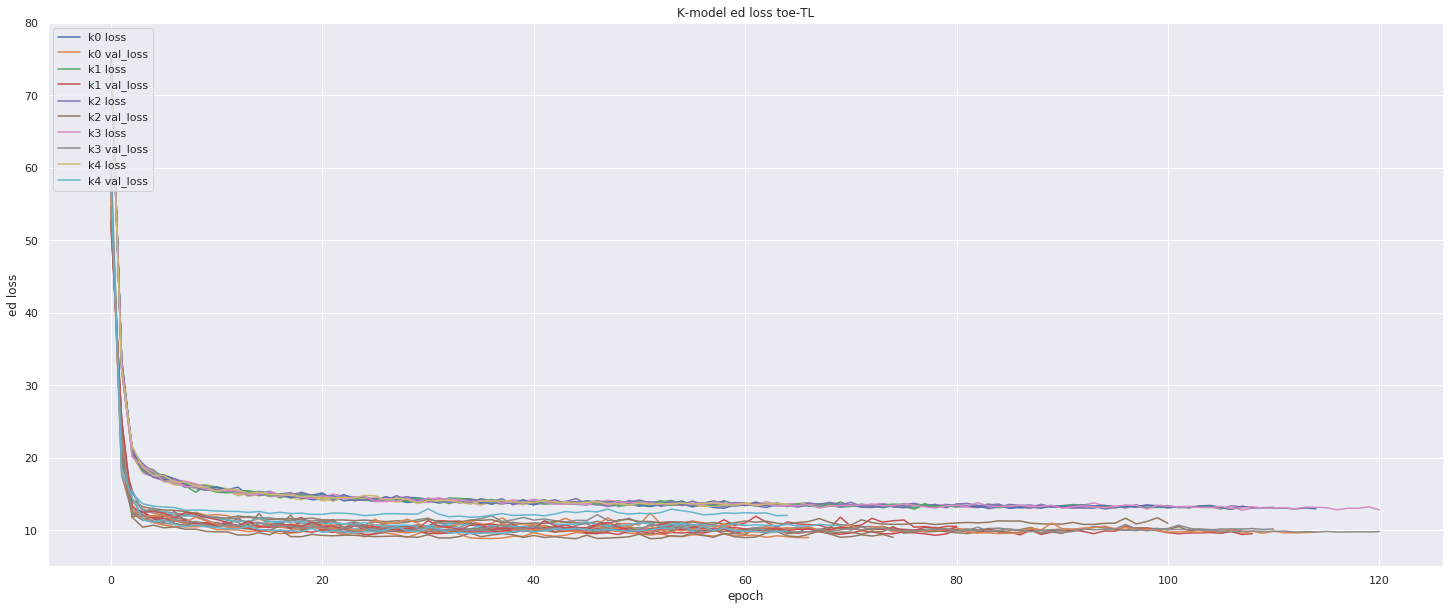

In [97]:
# Sum plot losses toe-tl

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_toe[k].history['loss'])
    plt.plot(history_toe[k].history['val_loss'])

    
plt.title('K-model ed loss toe-TL')
plt.ylabel('ed loss'), plt.ylim(5, 80)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_TL.png', bbox_inches = 'tight')

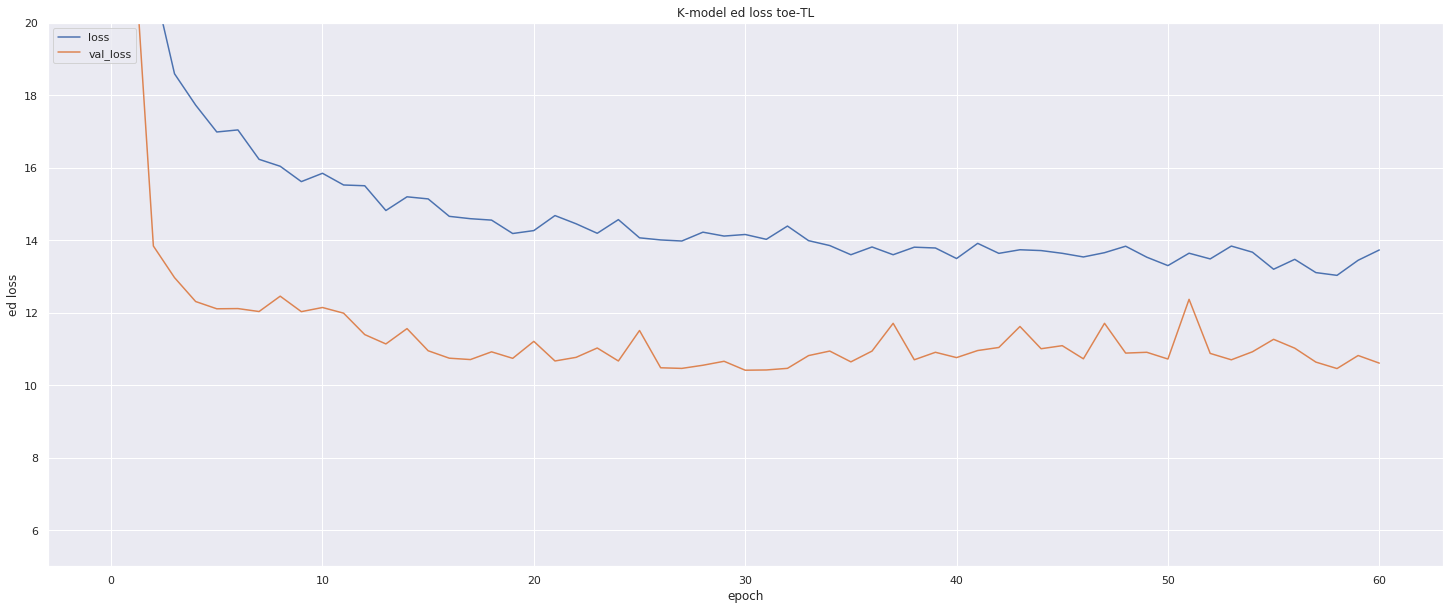

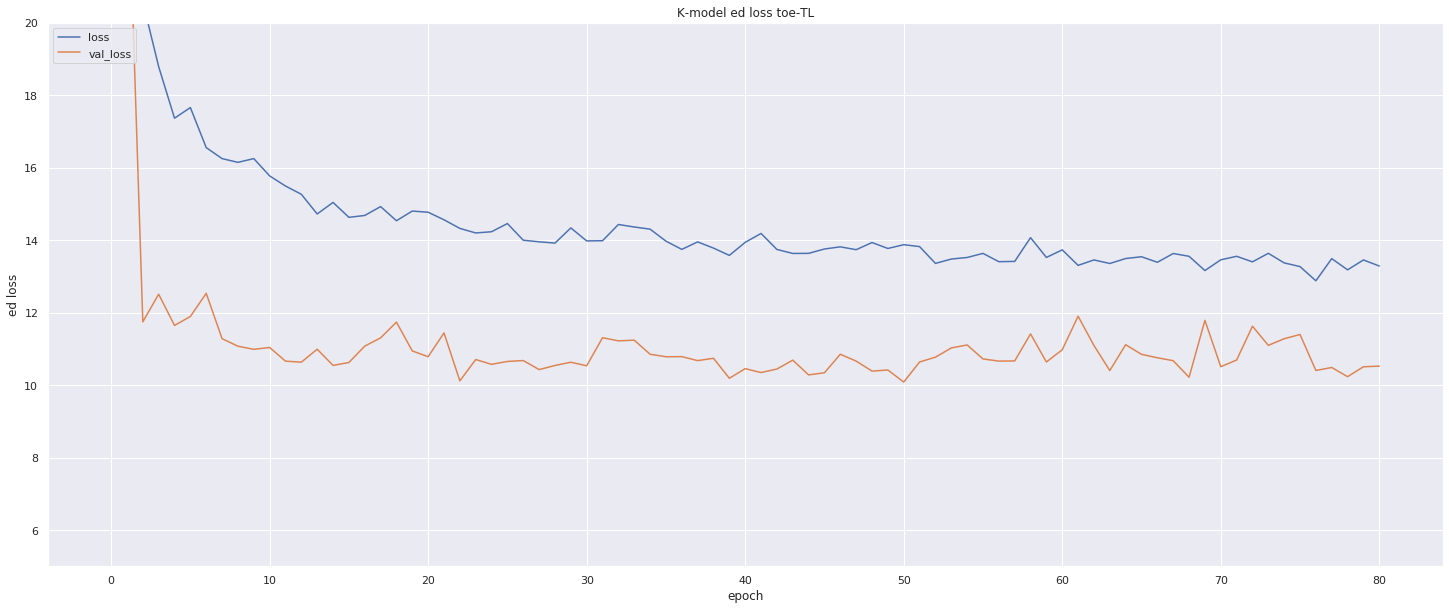

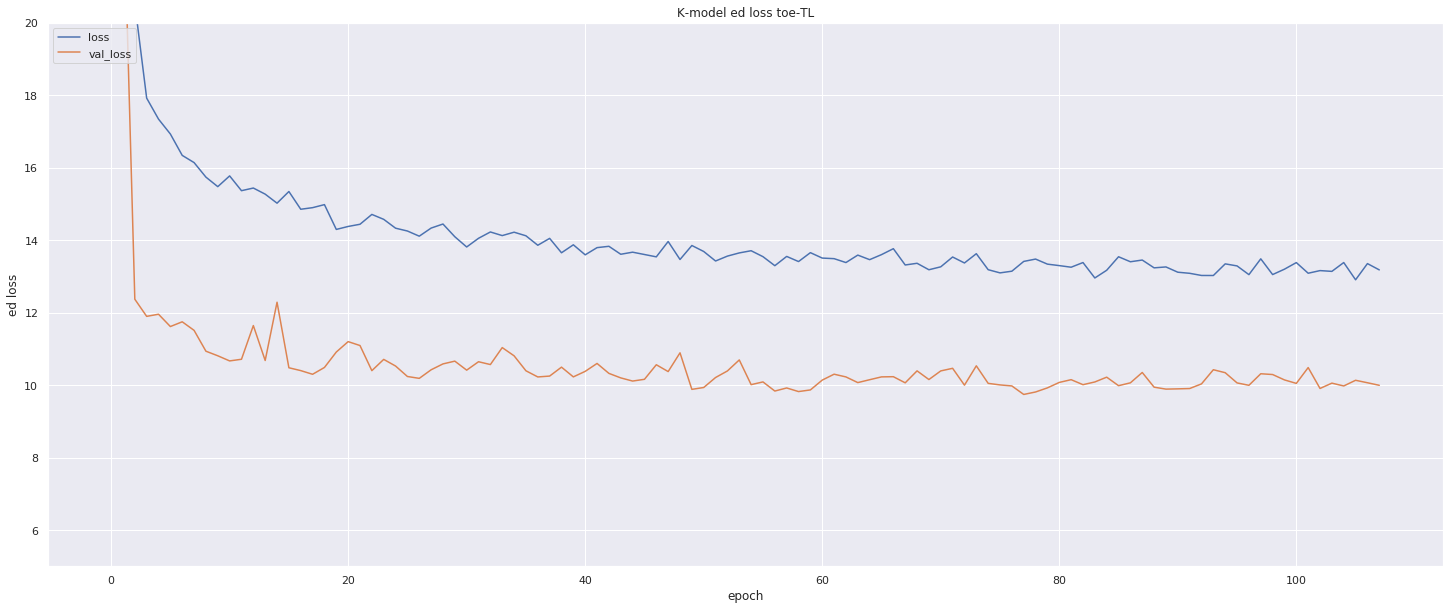

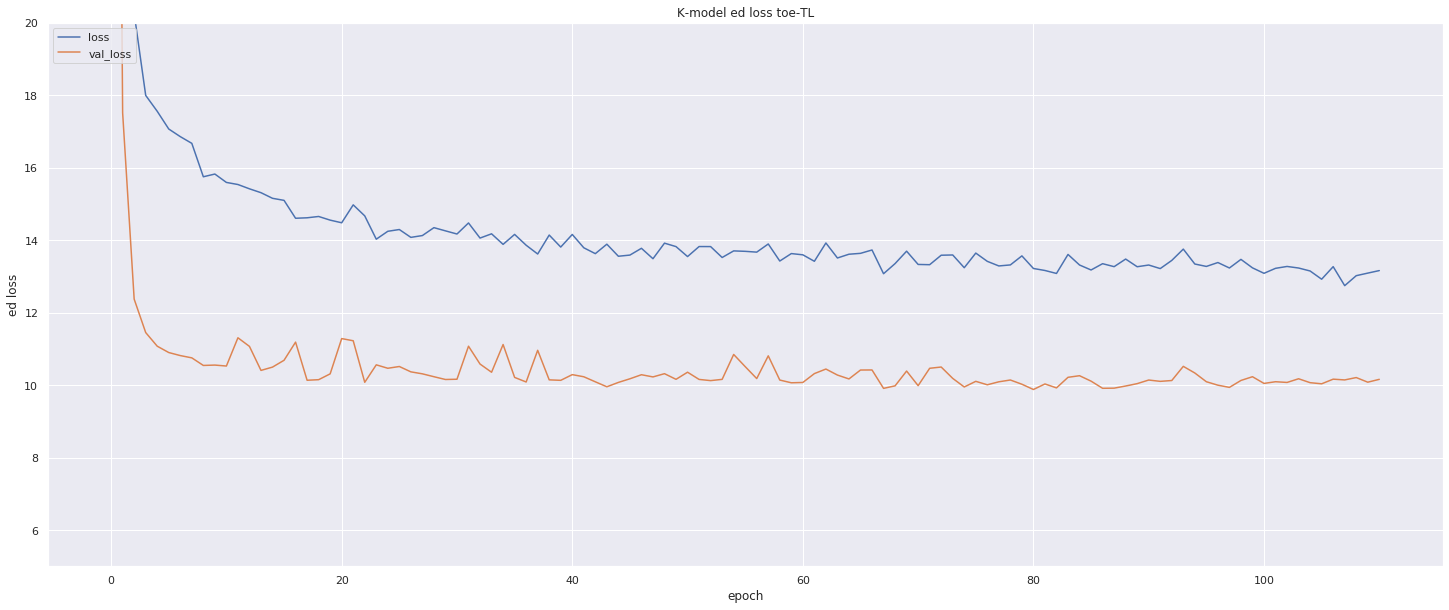

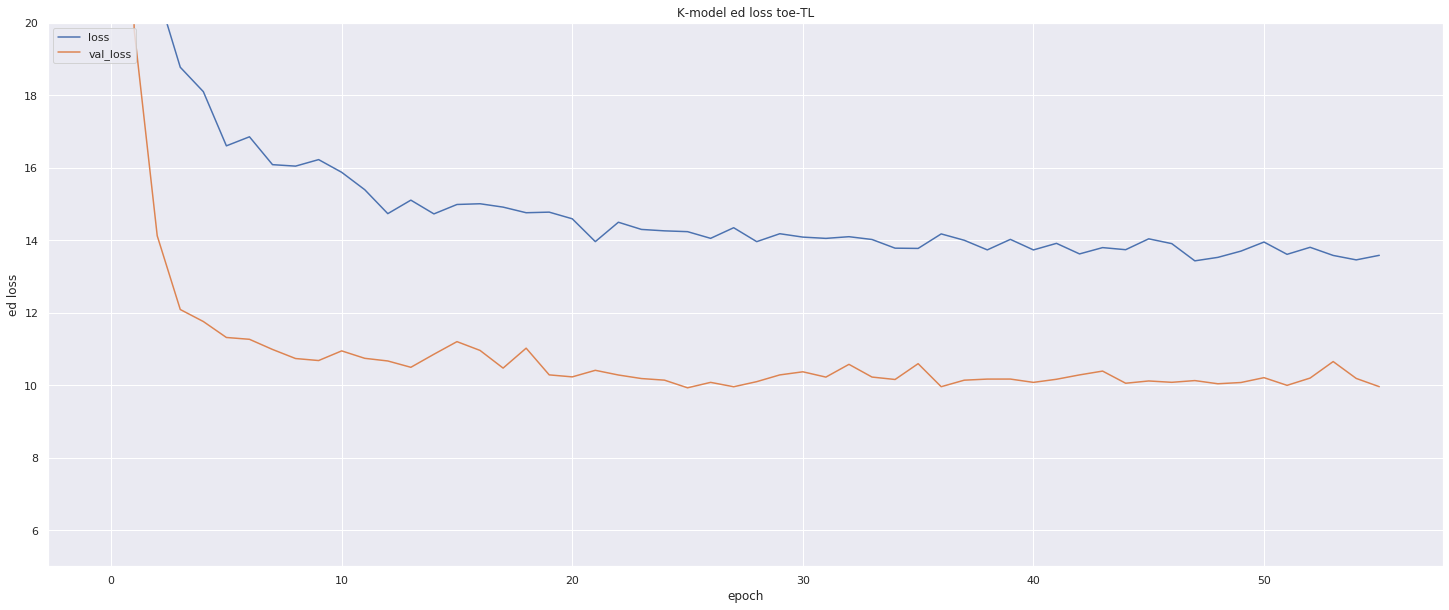

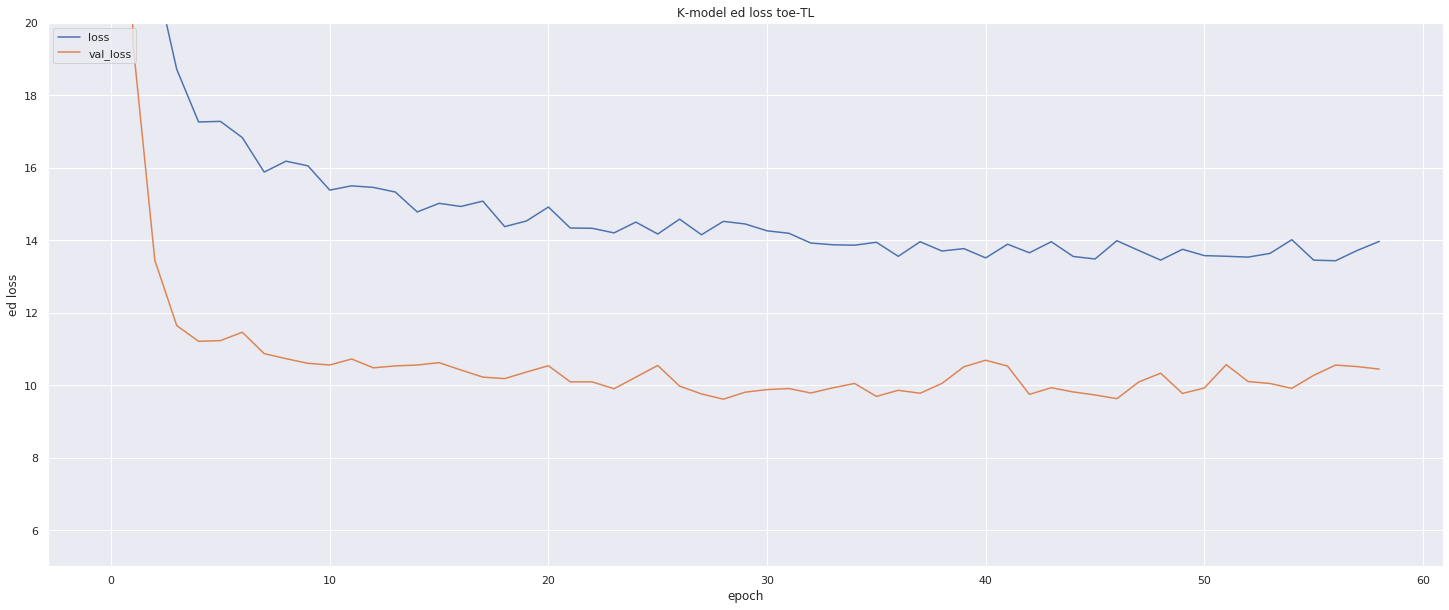

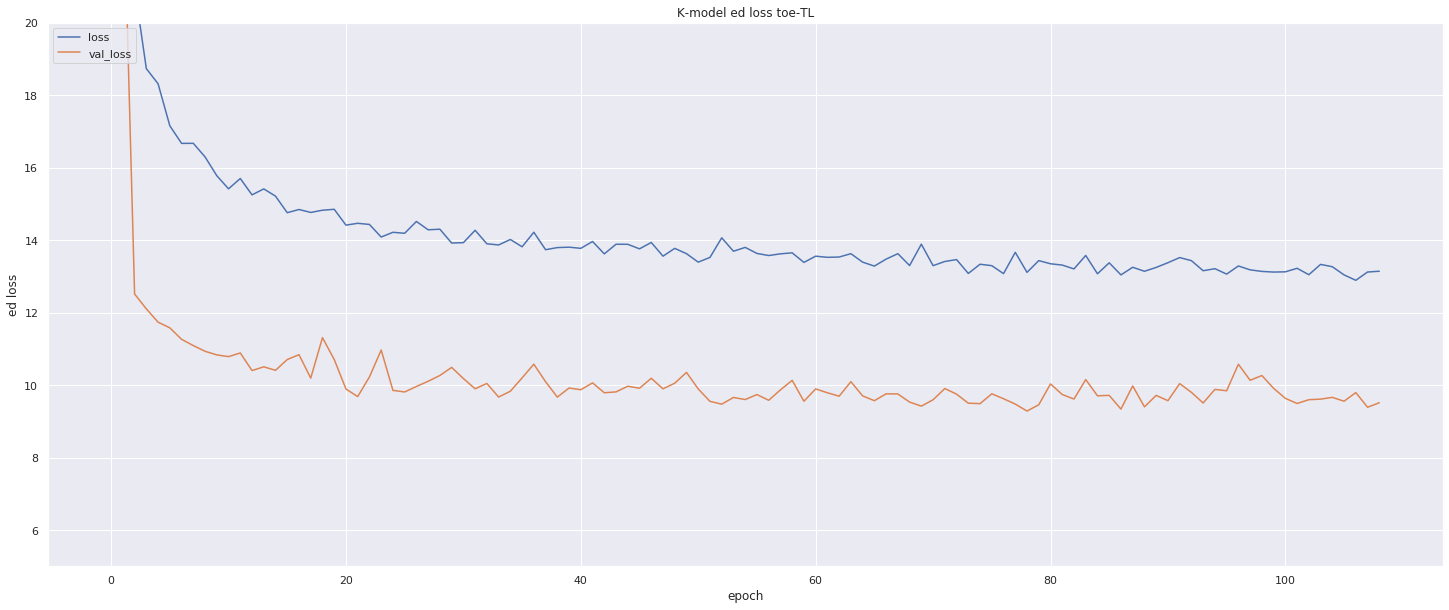

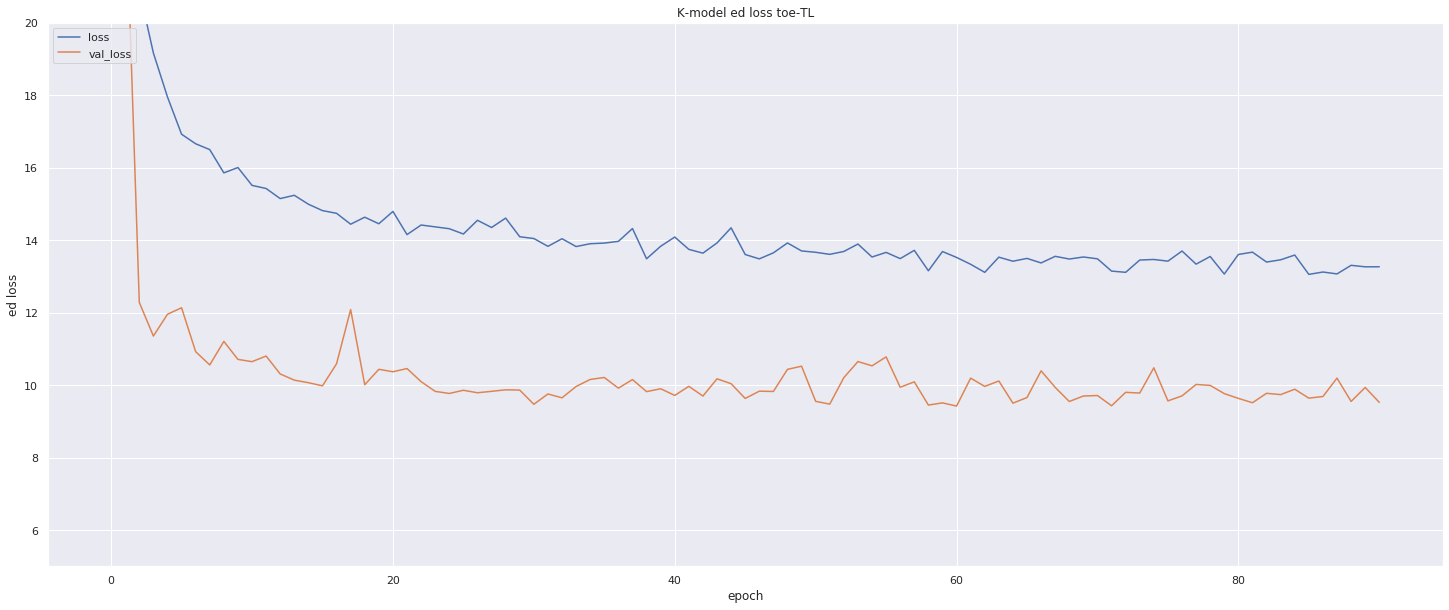

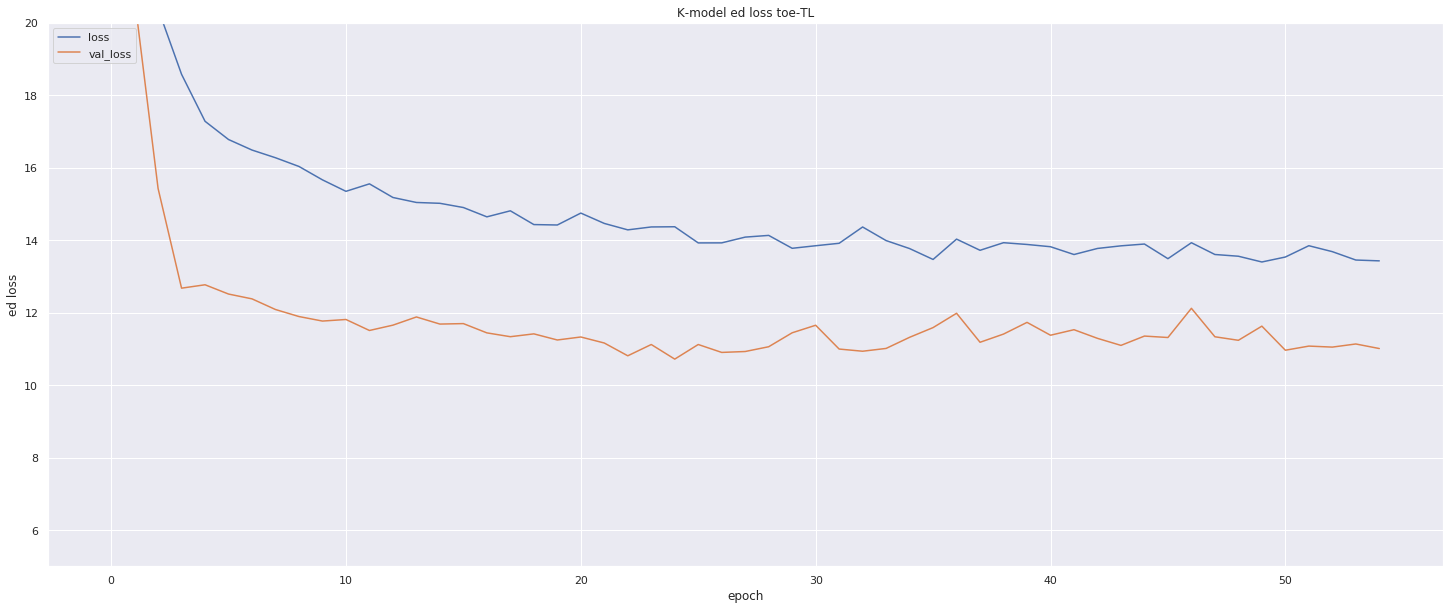

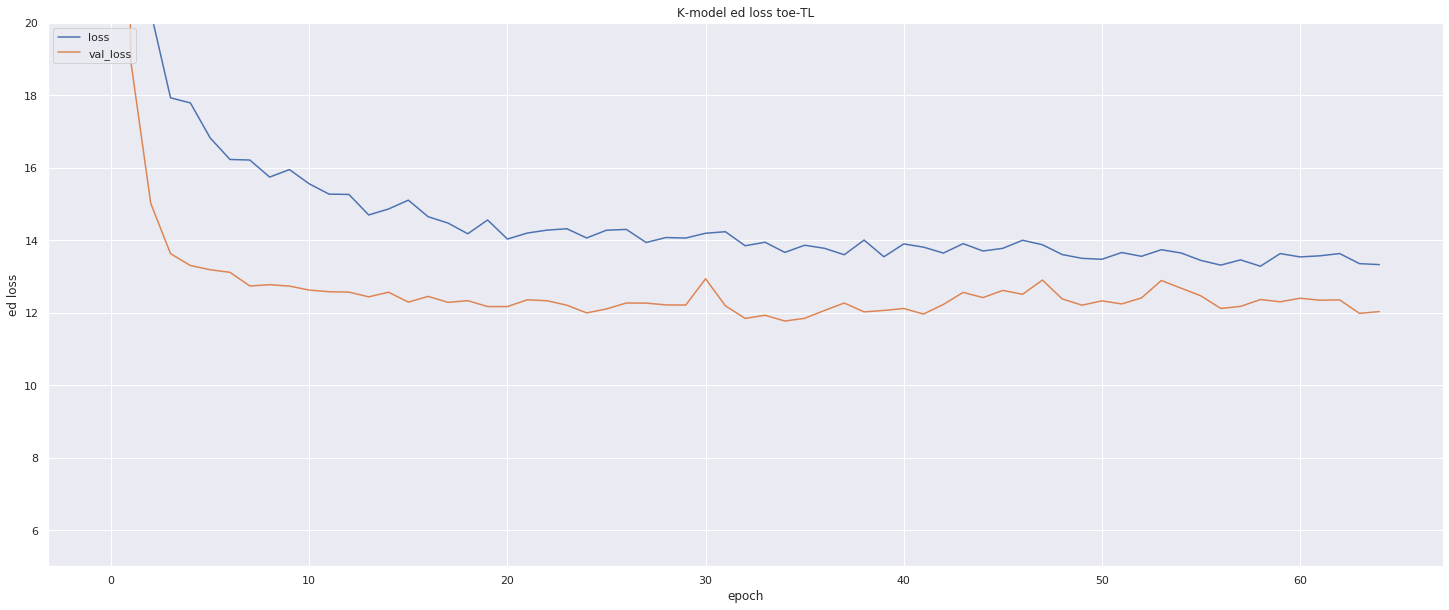

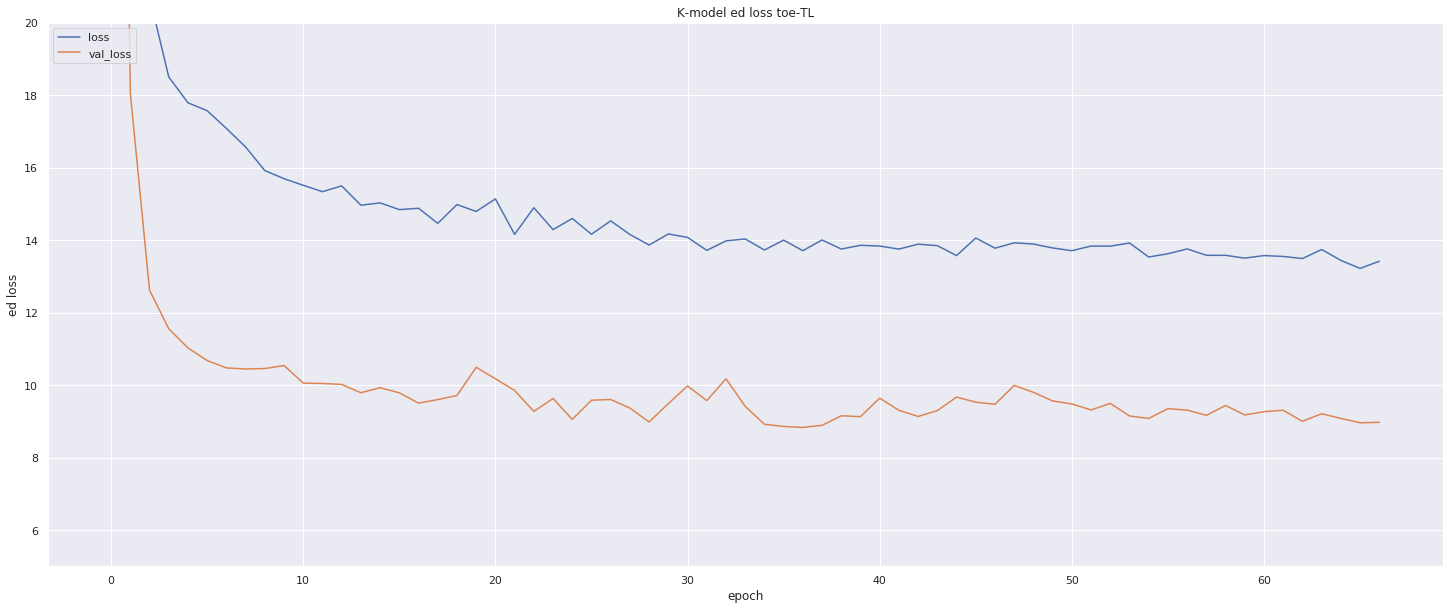

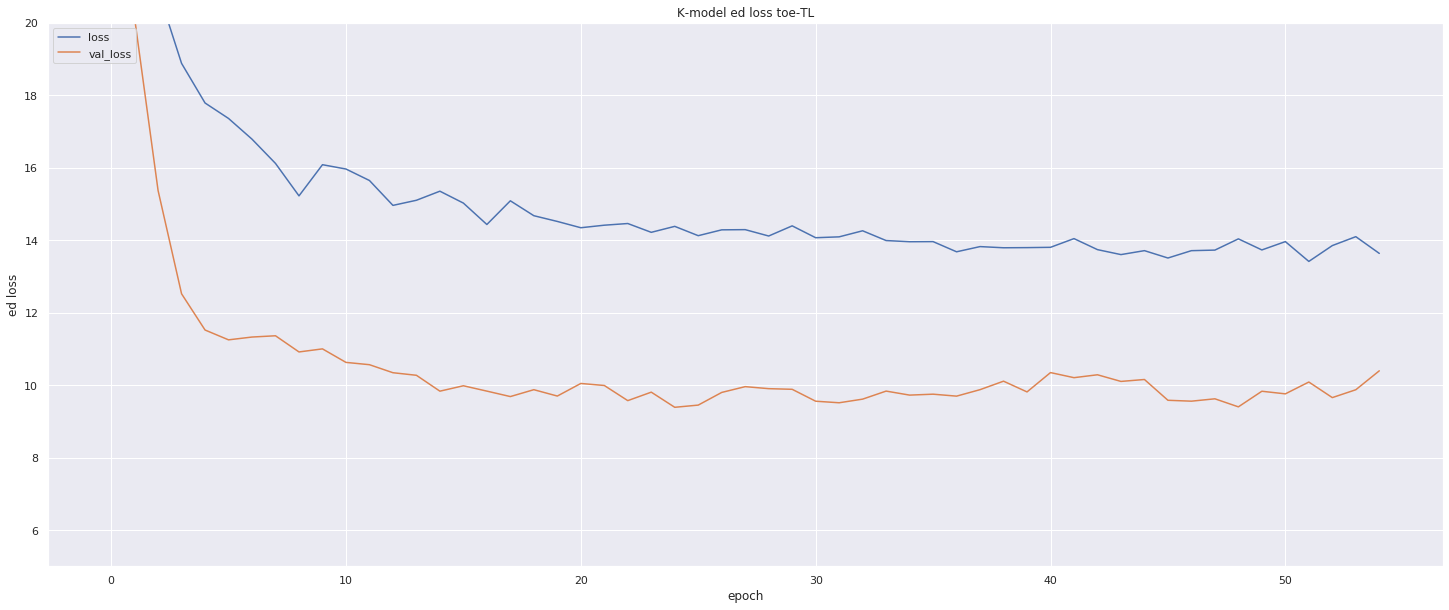

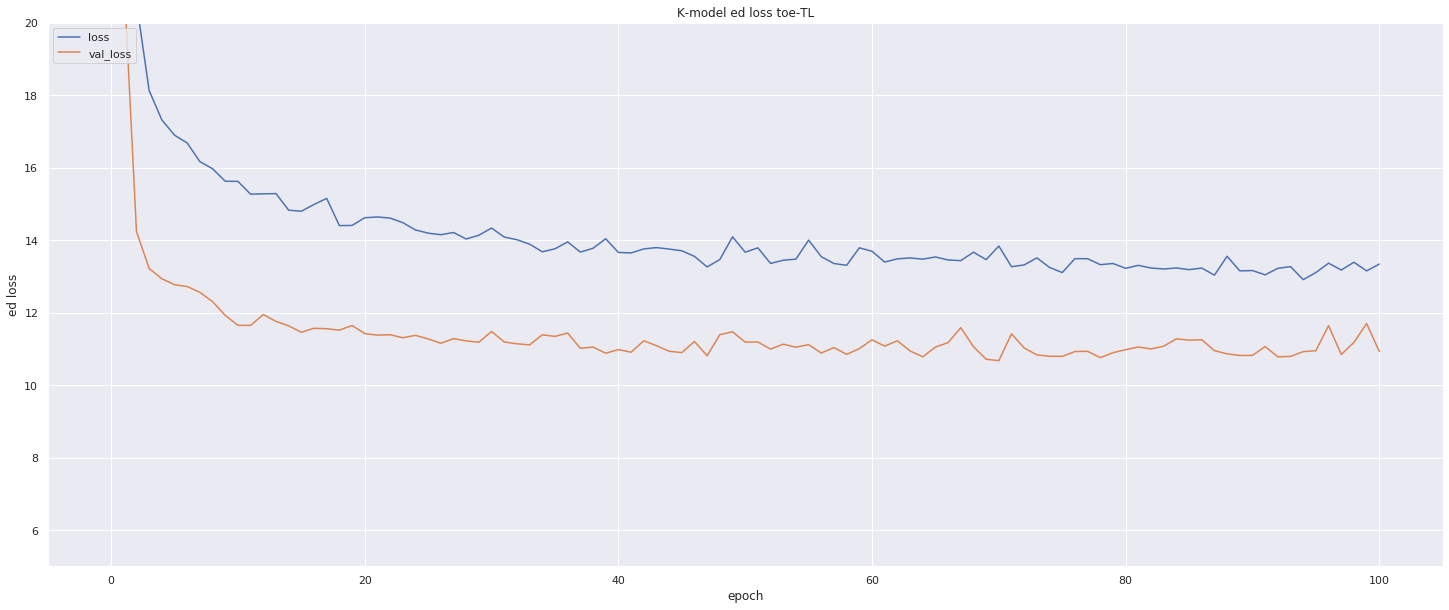

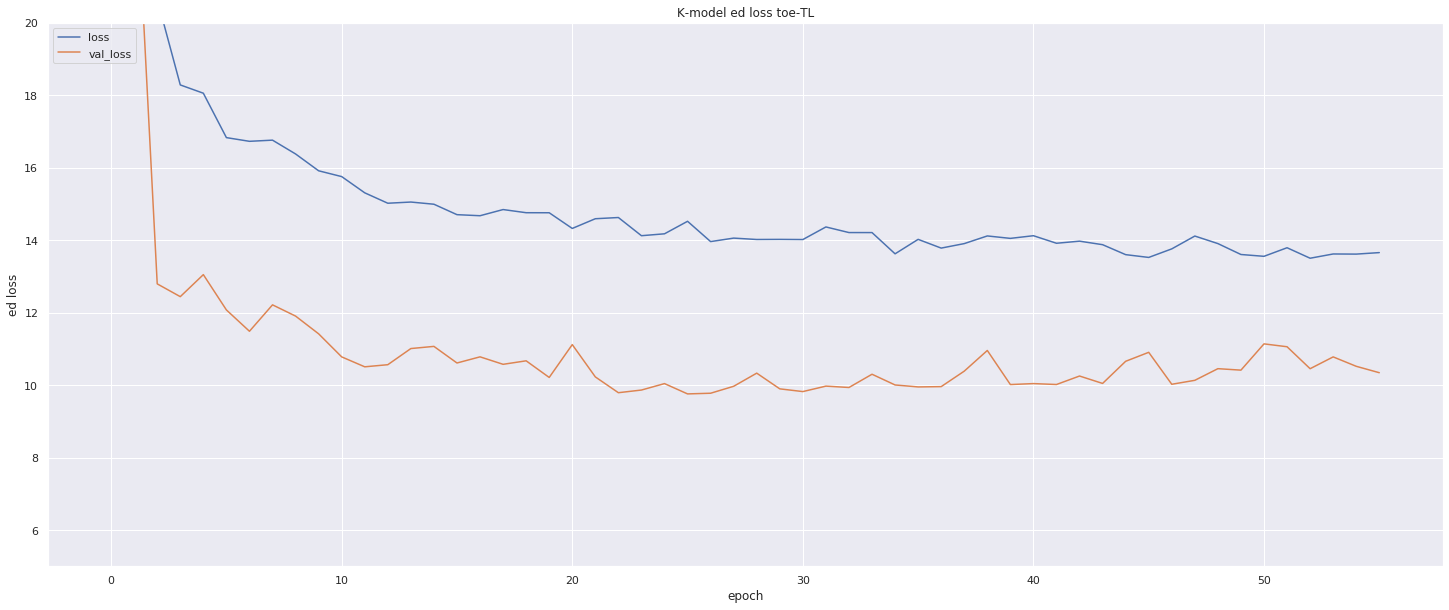

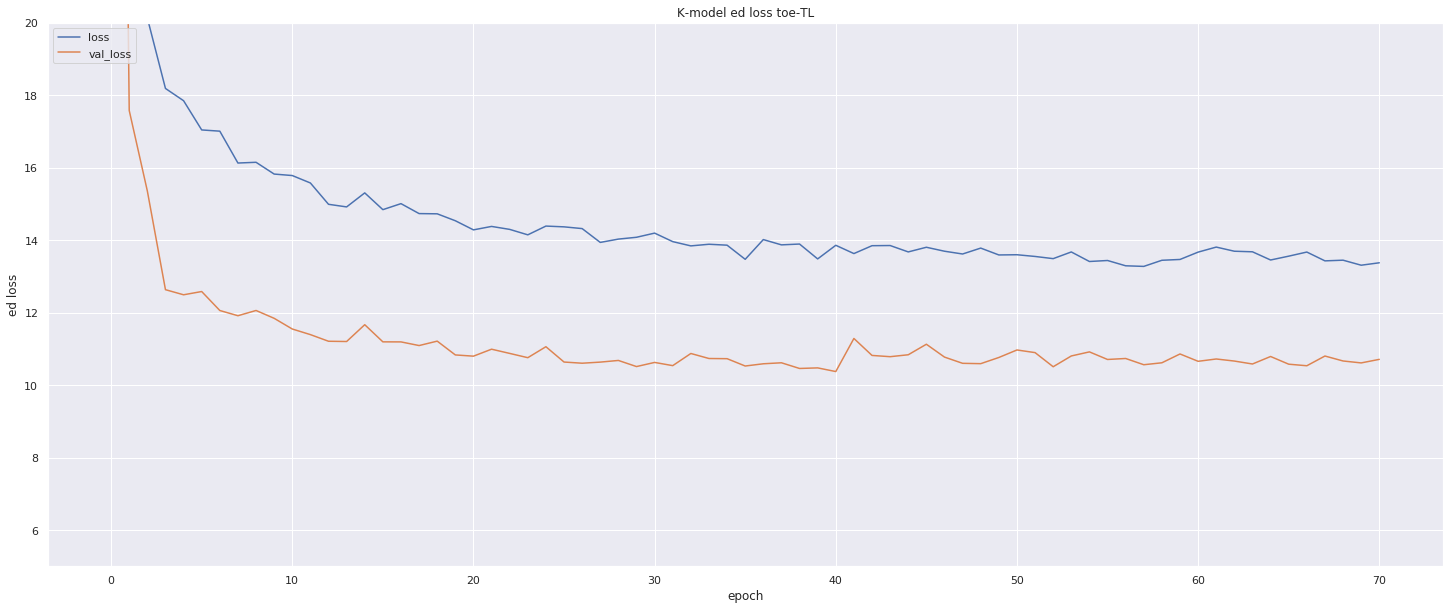

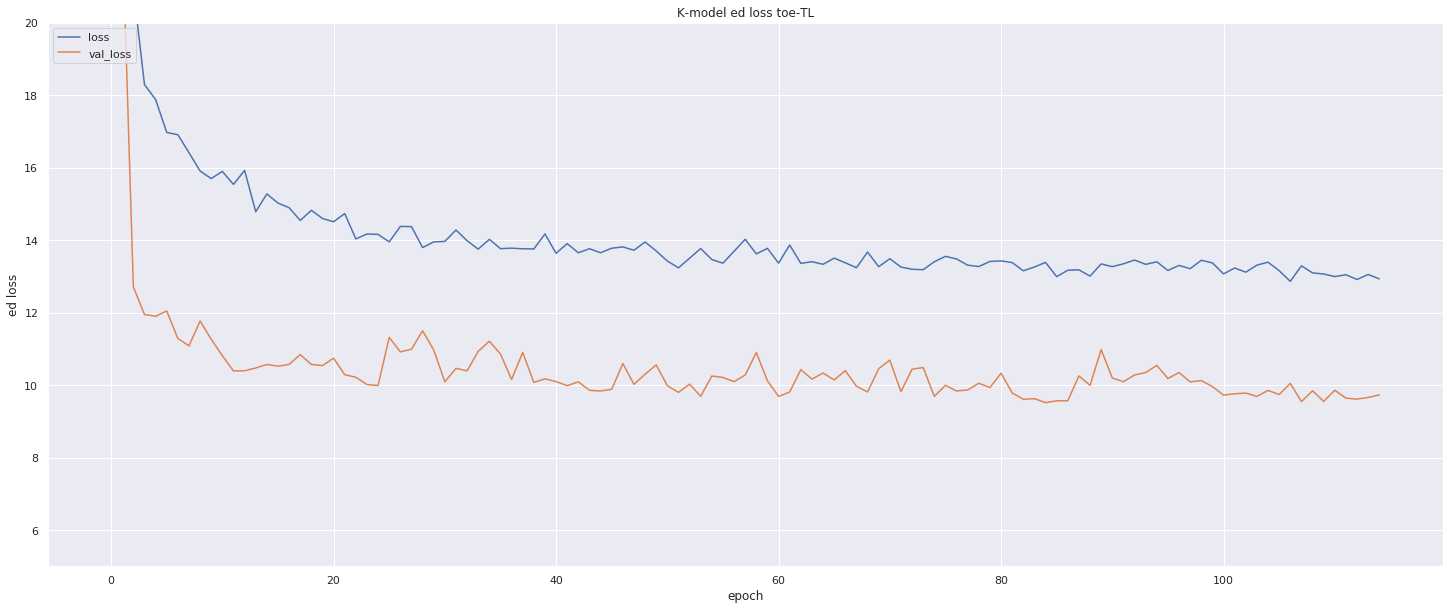

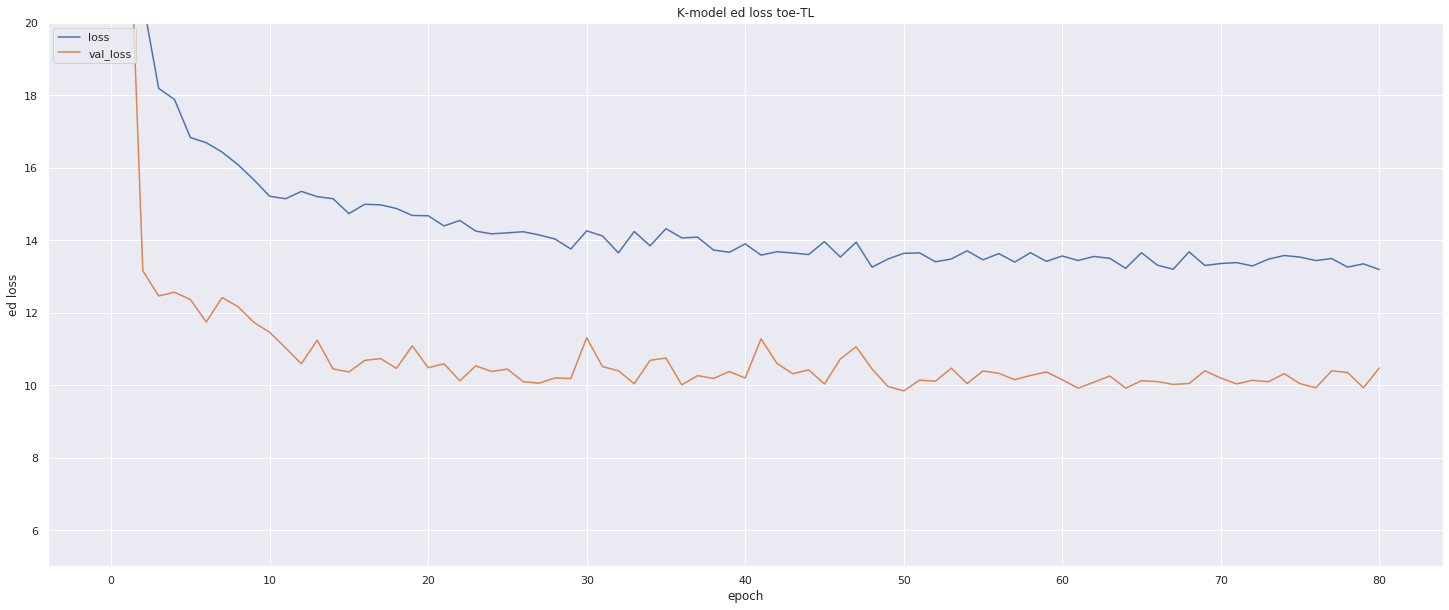

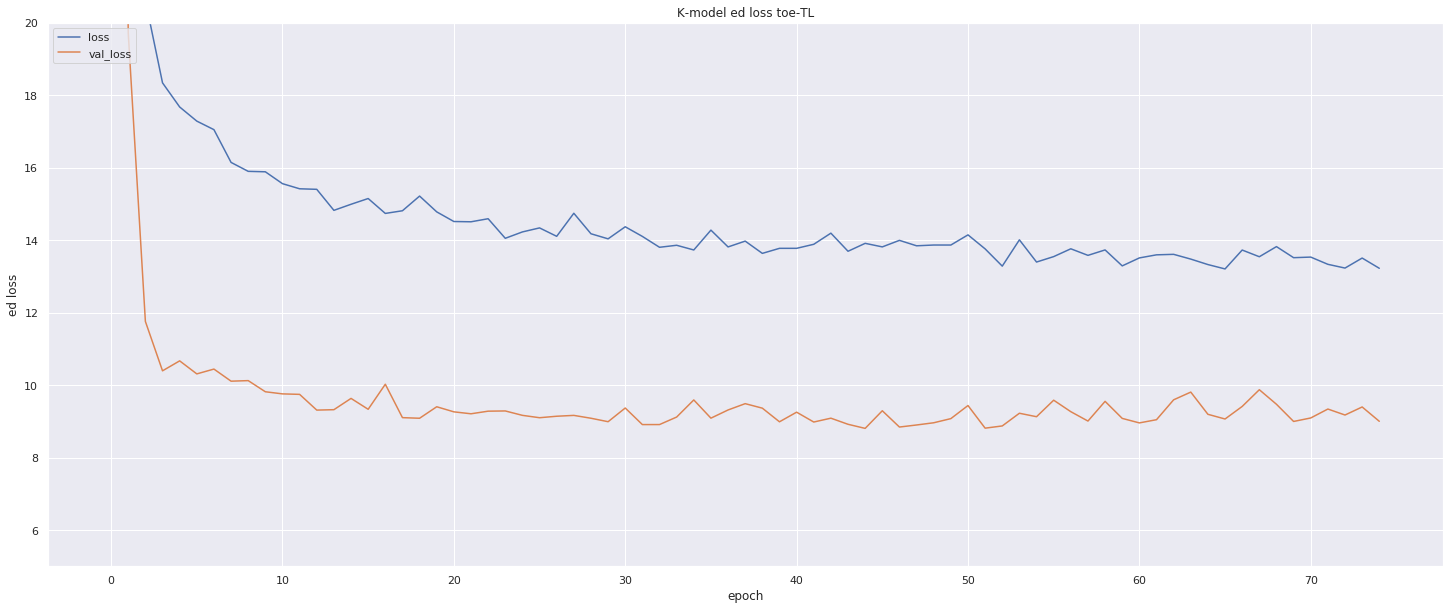

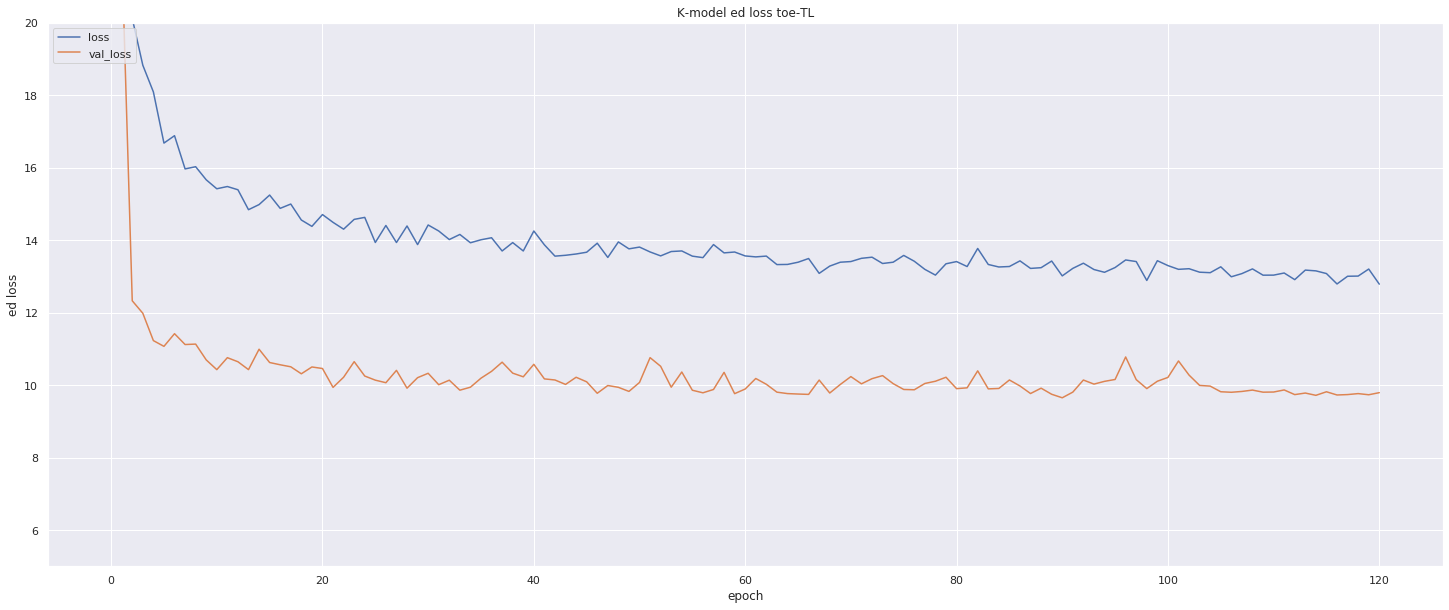

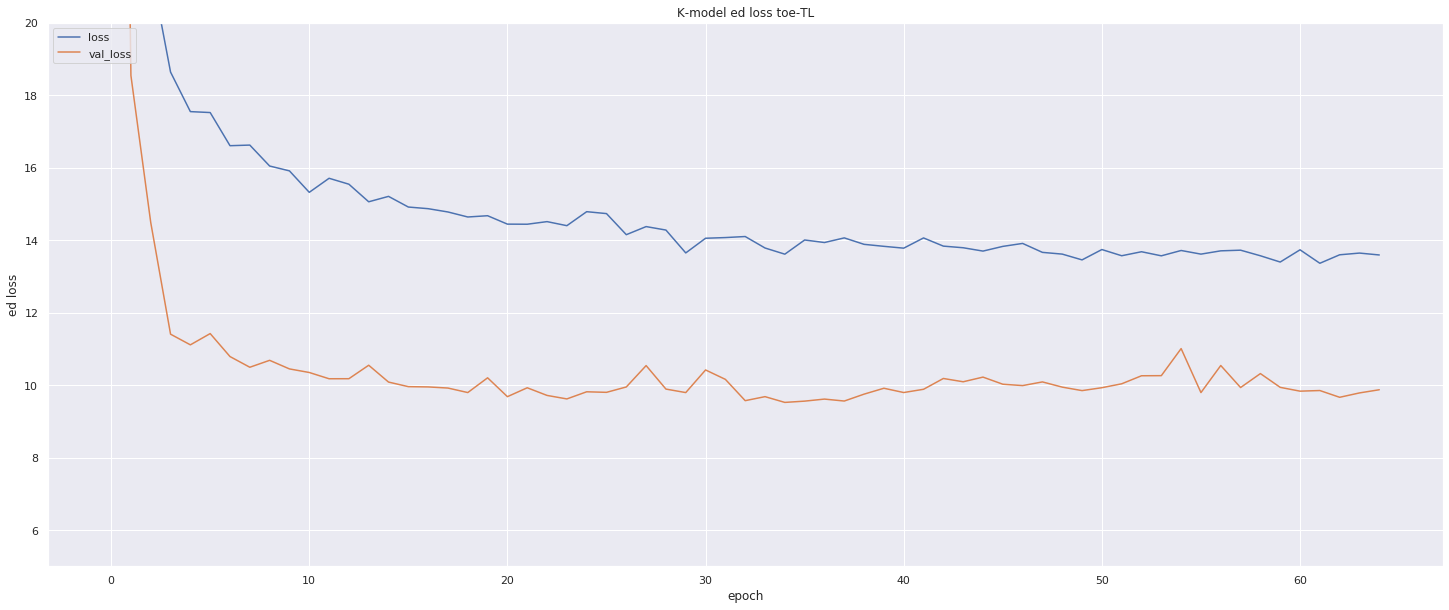

In [98]:
# Single plot loss toe-tl

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_toe[k].history['loss'])
    plt.plot(history_toe[k].history['val_loss'])
    plt.title('K-model ed loss toe-TL')
    plt.ylabel('ed loss'), plt.ylim(5, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_toe[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_TL_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9
K:10
K:11
K:12
K:13
K:14
K:15
K:16
K:17
K:18
K:19


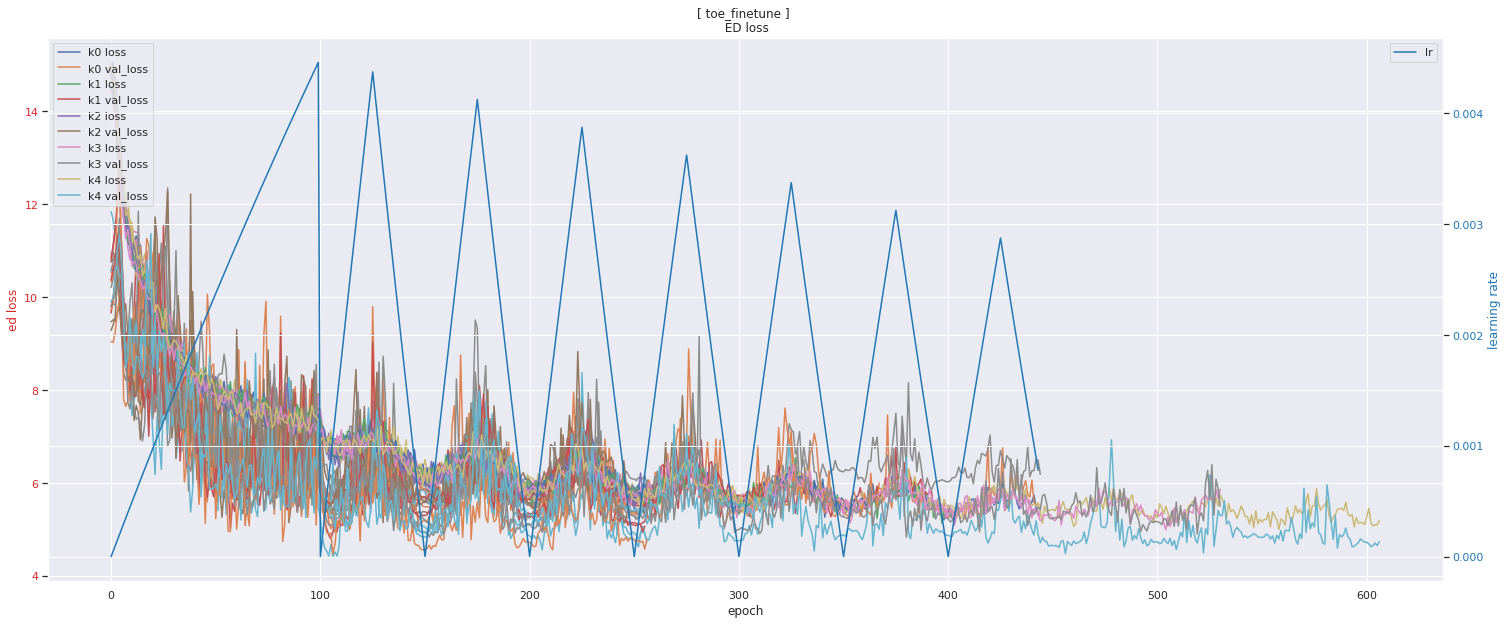

In [99]:
# check the loos the model trained.

def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
    
# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ toe_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

for k in range(KFlodNum):

    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])

ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.
ax1.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe_finetune[0].history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# # save plot : comment plo.show in jupyter notebook.
# def get_valloss(his_v_l):   
#     return np.min(his_v_l), np.argmin(his_v_l)

# vl, ep = get_valloss(history_toe_finetune.history['val_loss'])


t_vl = np.mean(t_vl, axis=0)
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_ft_Ksum-clr_ed{round(t_vl,4)}.png', bbox_inches = 'tight')

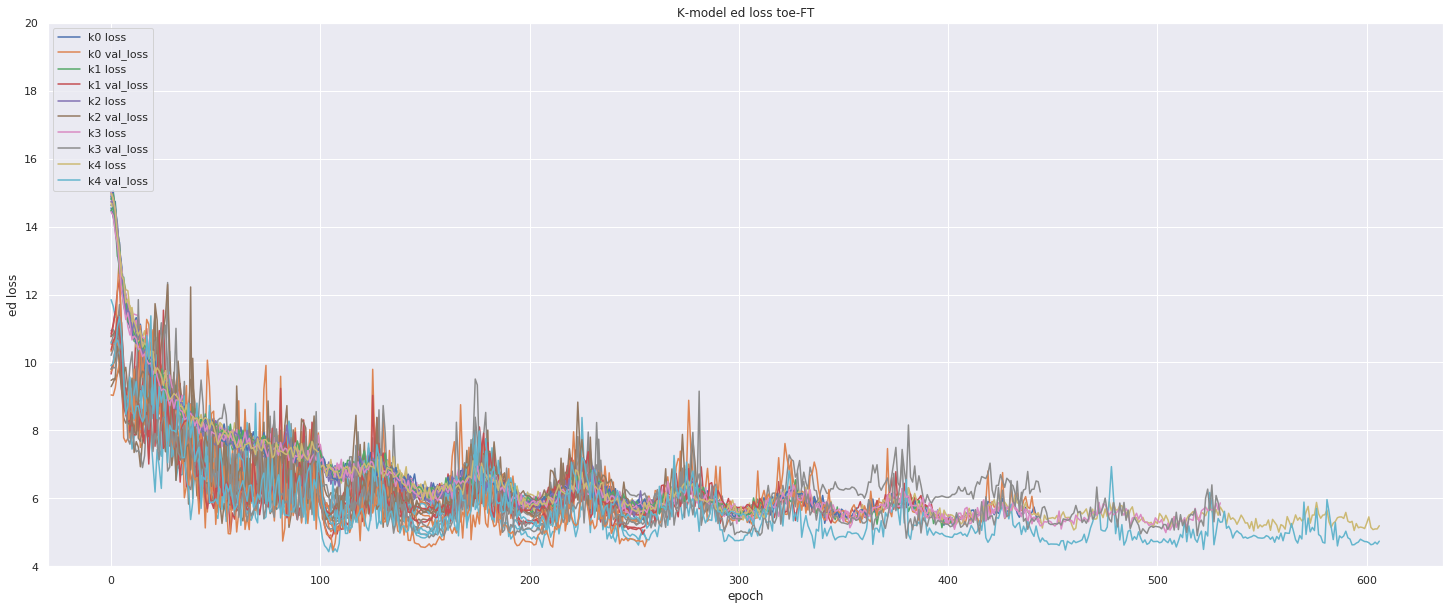

In [100]:
# Sum plot losses toe-ft

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])

    
plt.title('K-model ed loss toe-FT')
plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_FT.png', bbox_inches = 'tight')

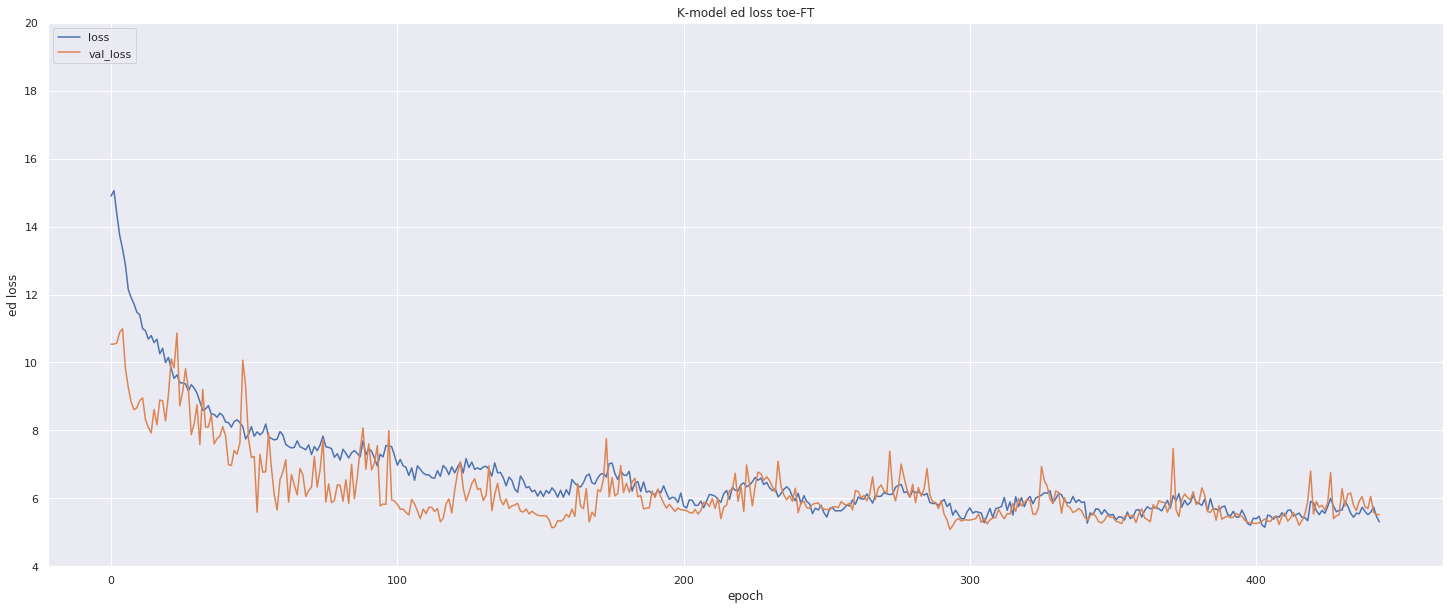

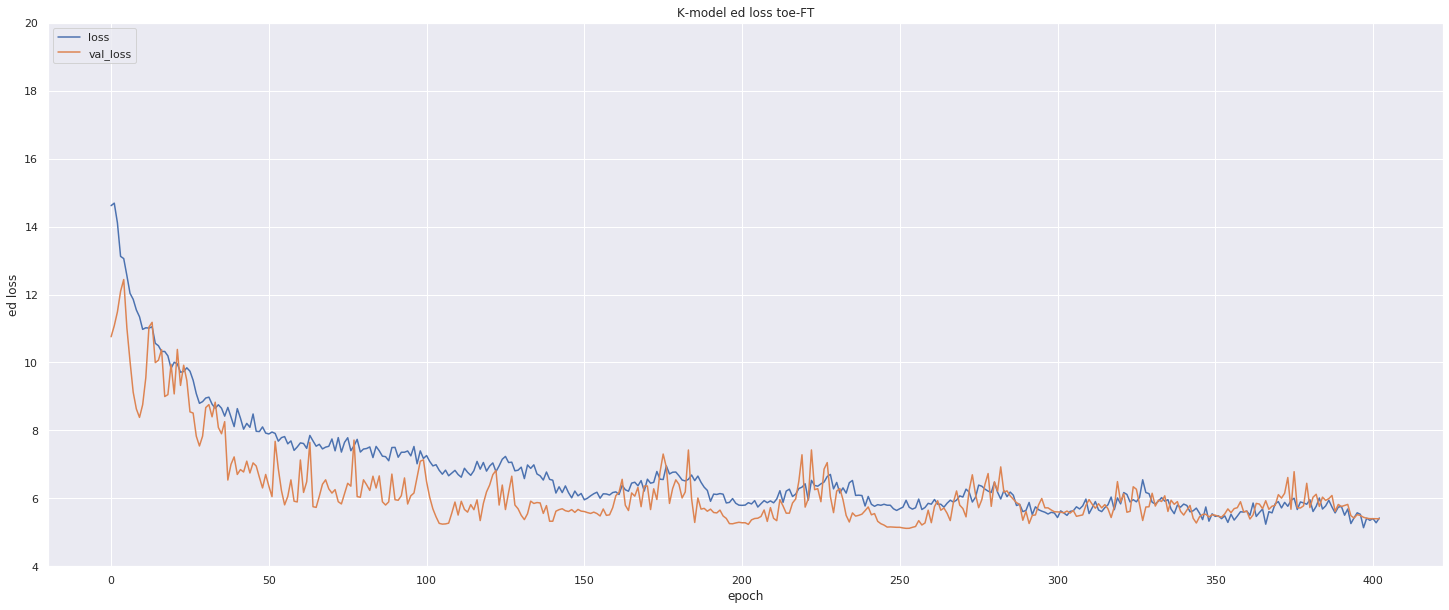

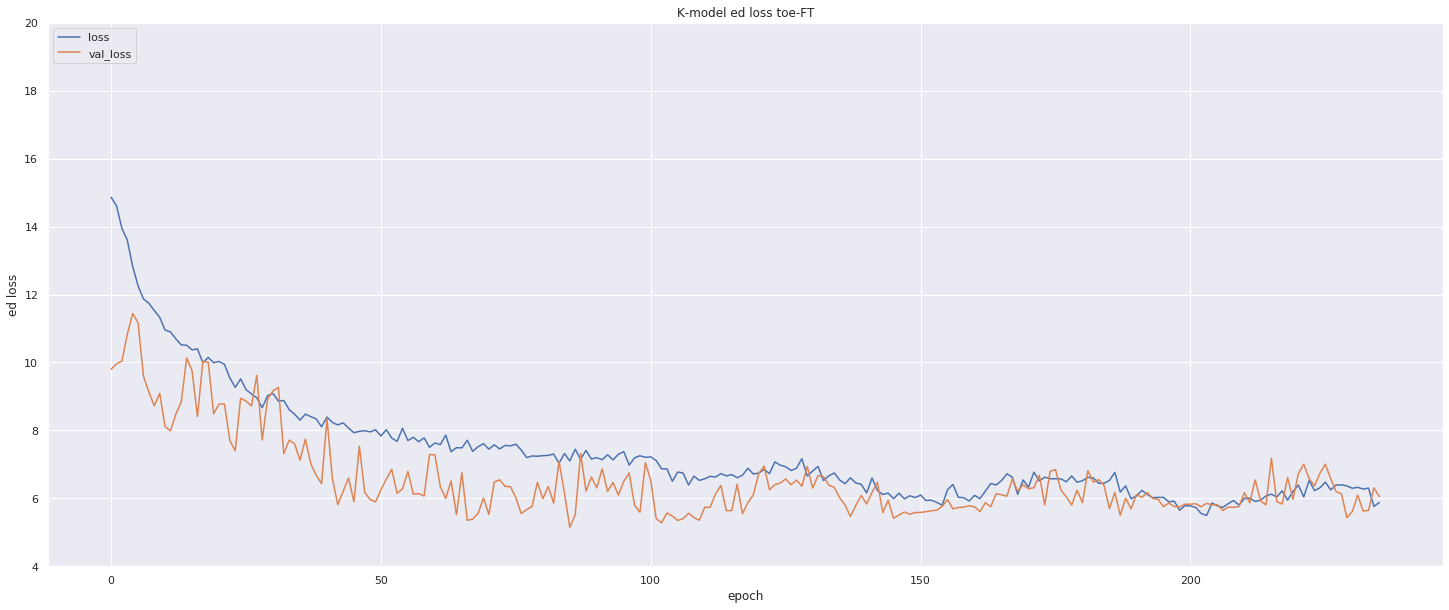

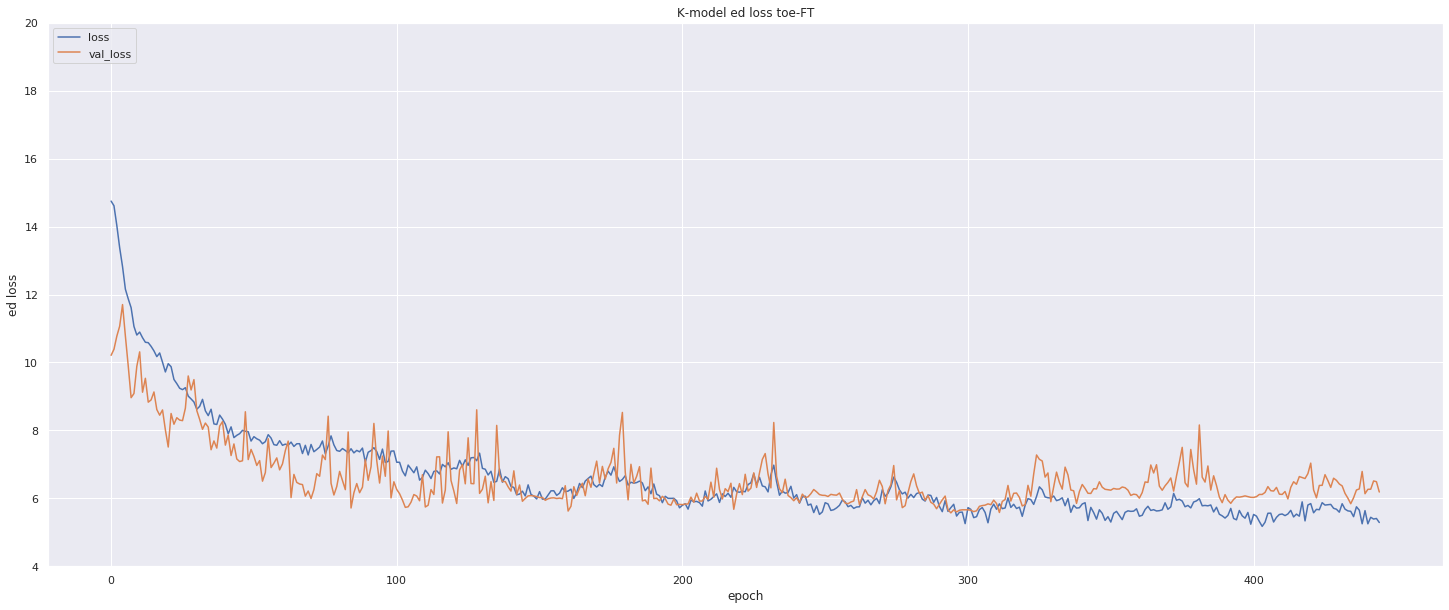

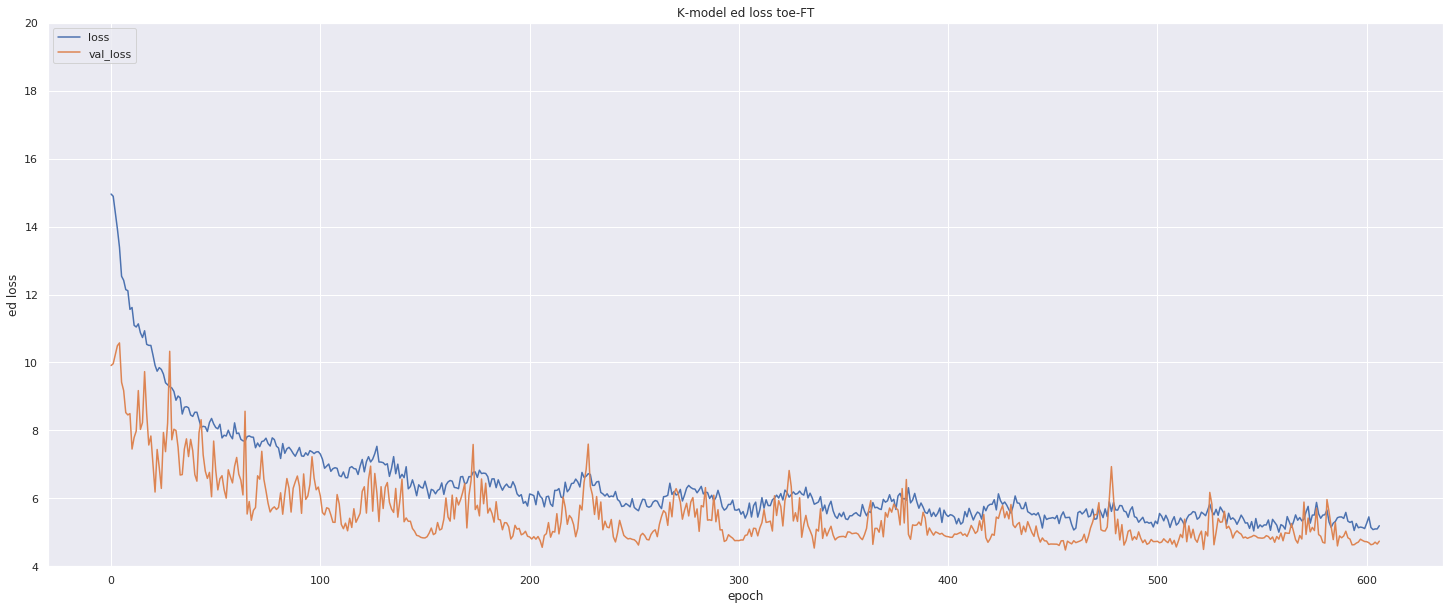

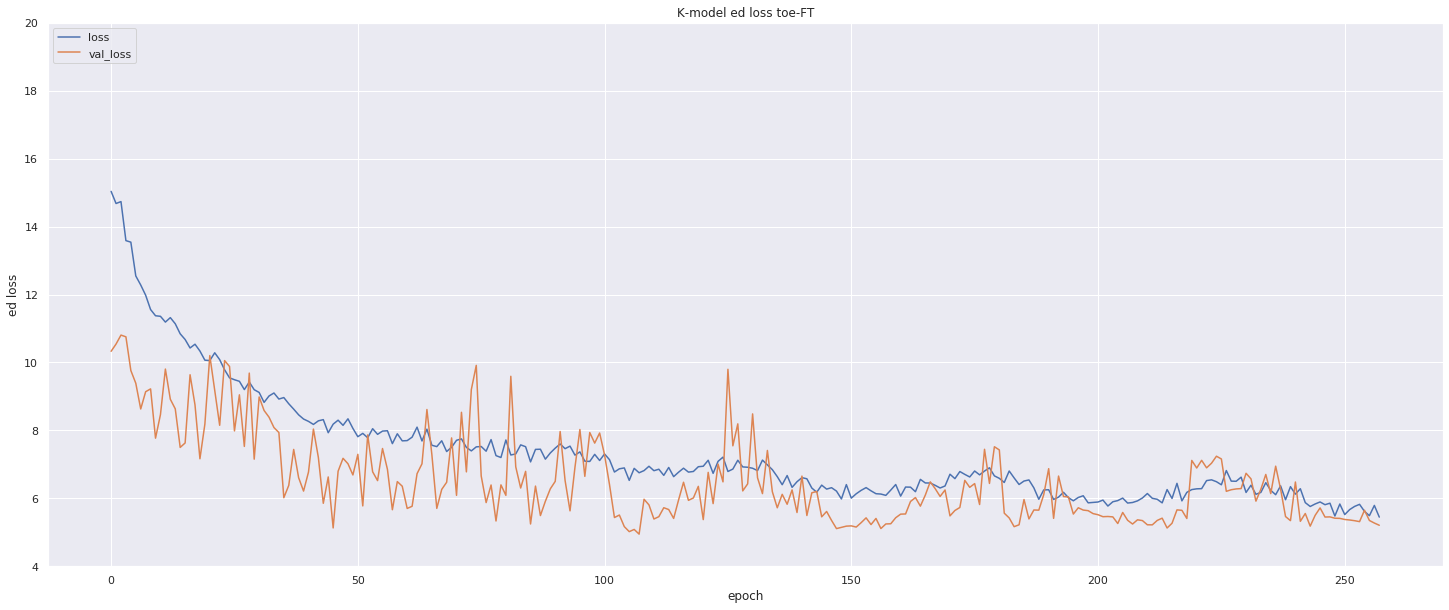

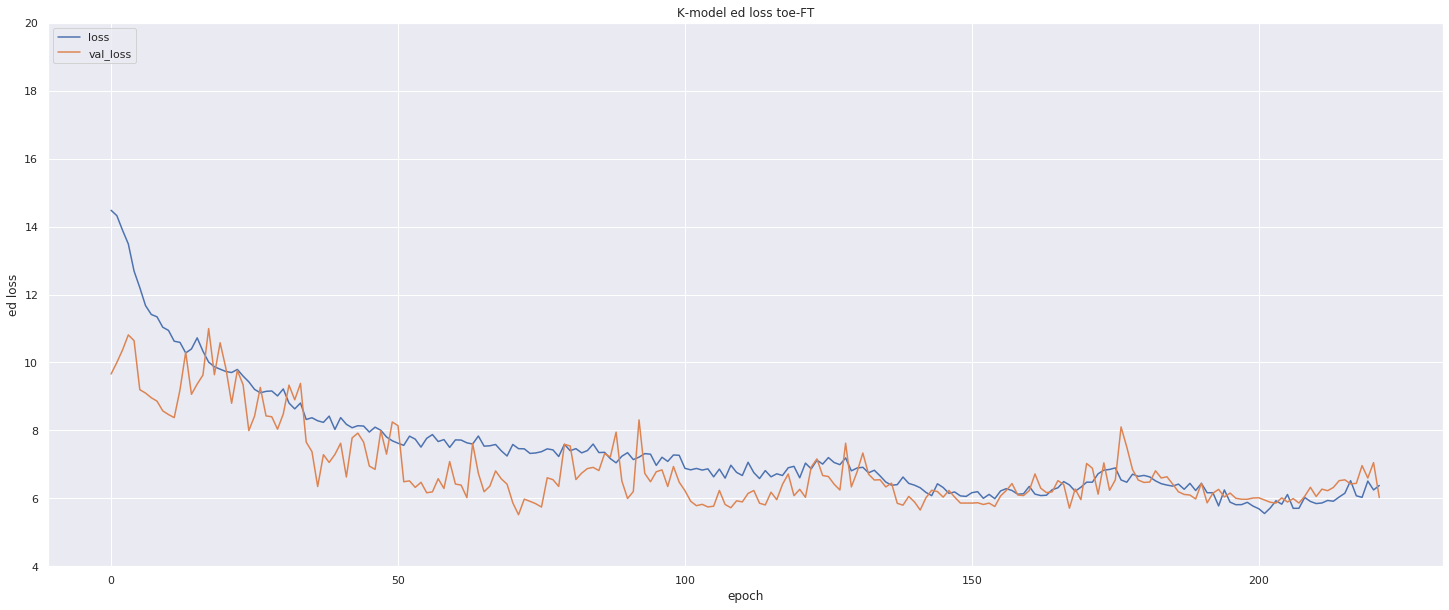

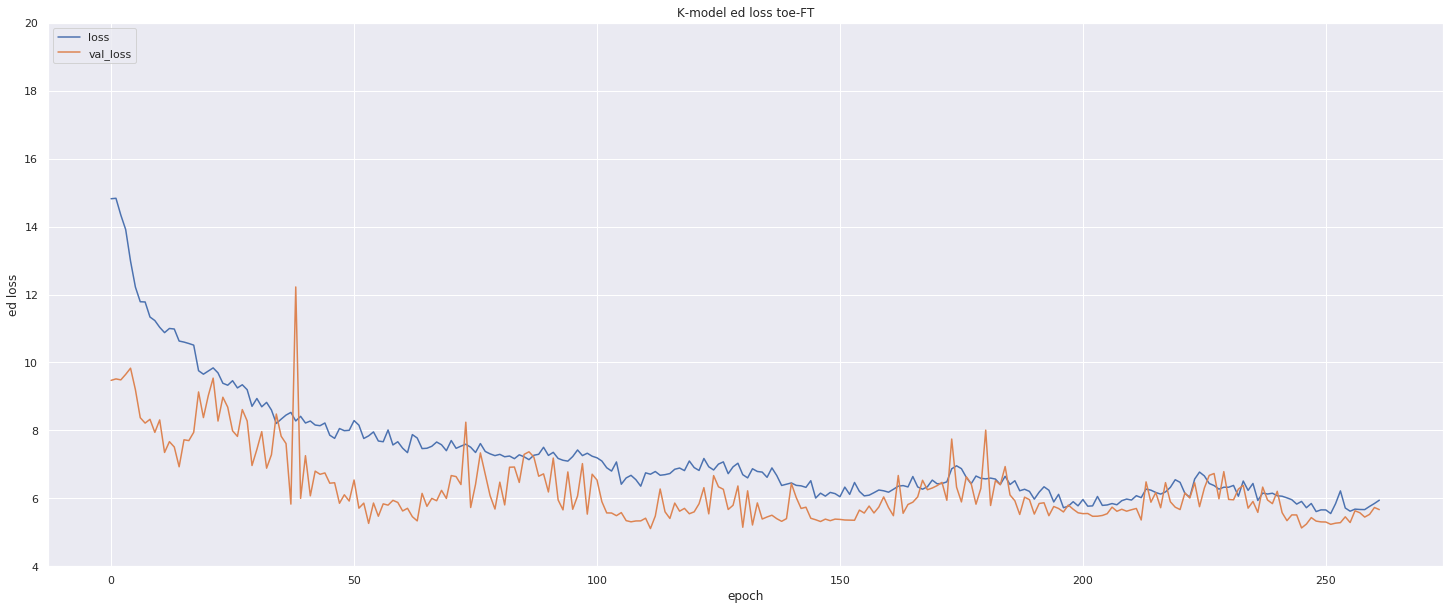

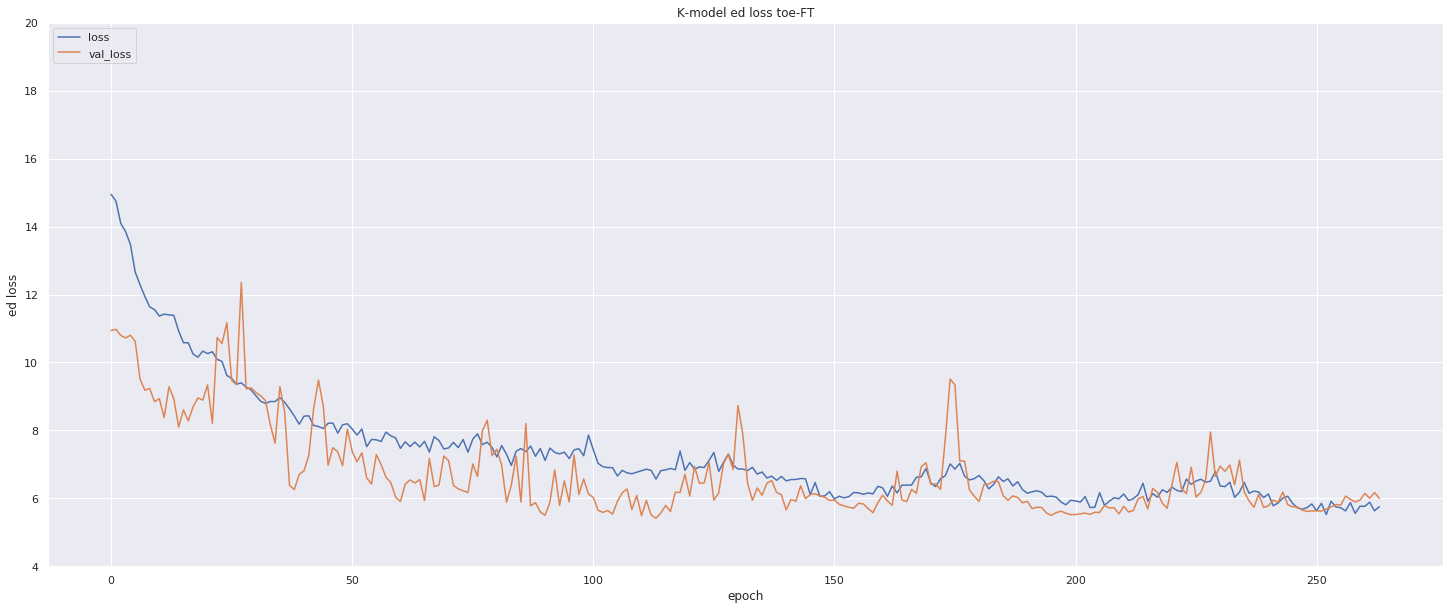

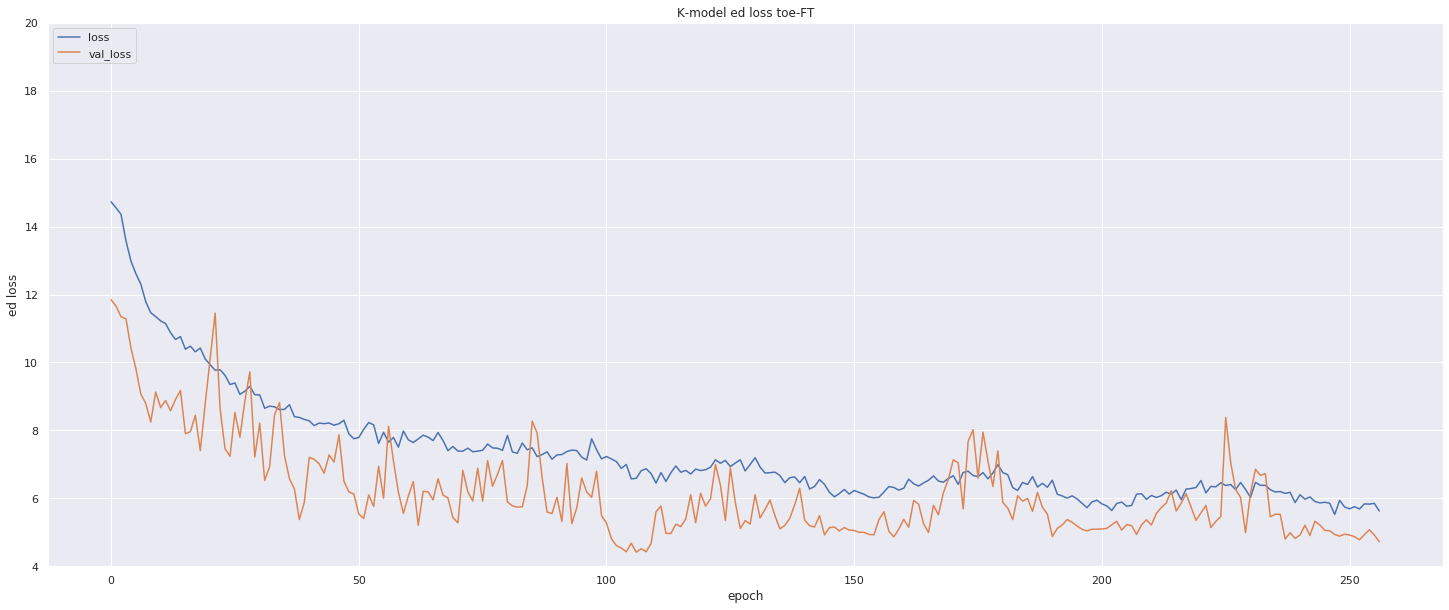

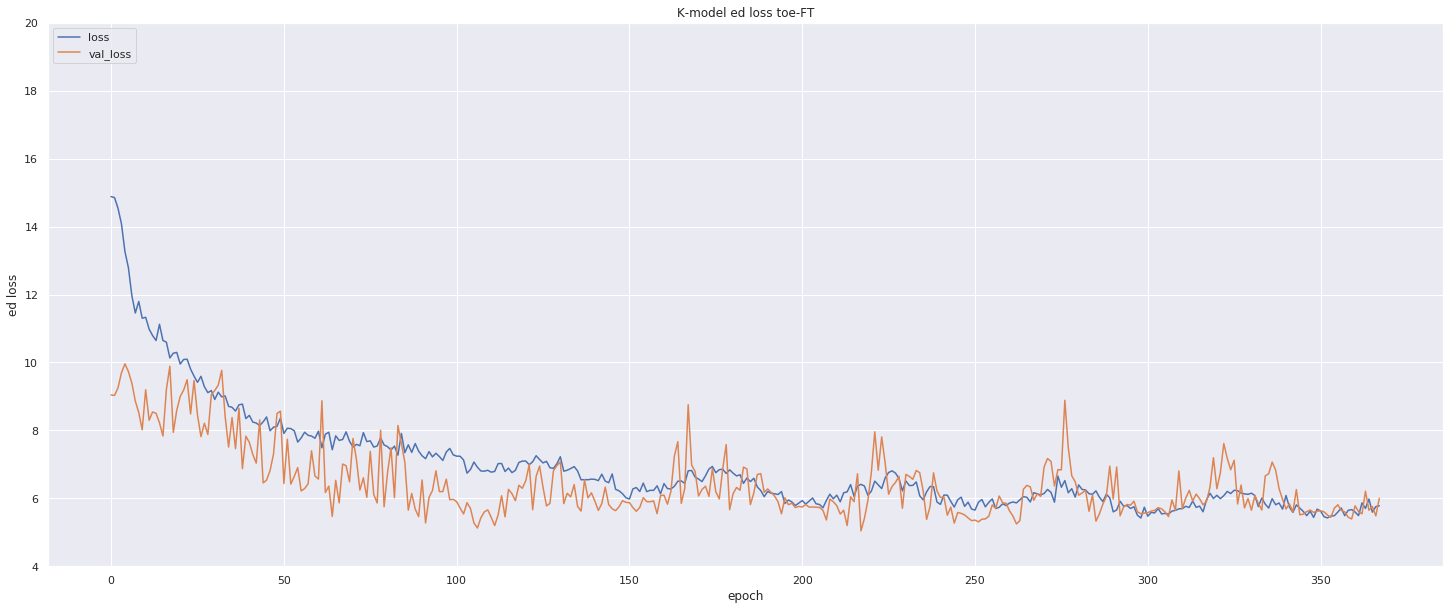

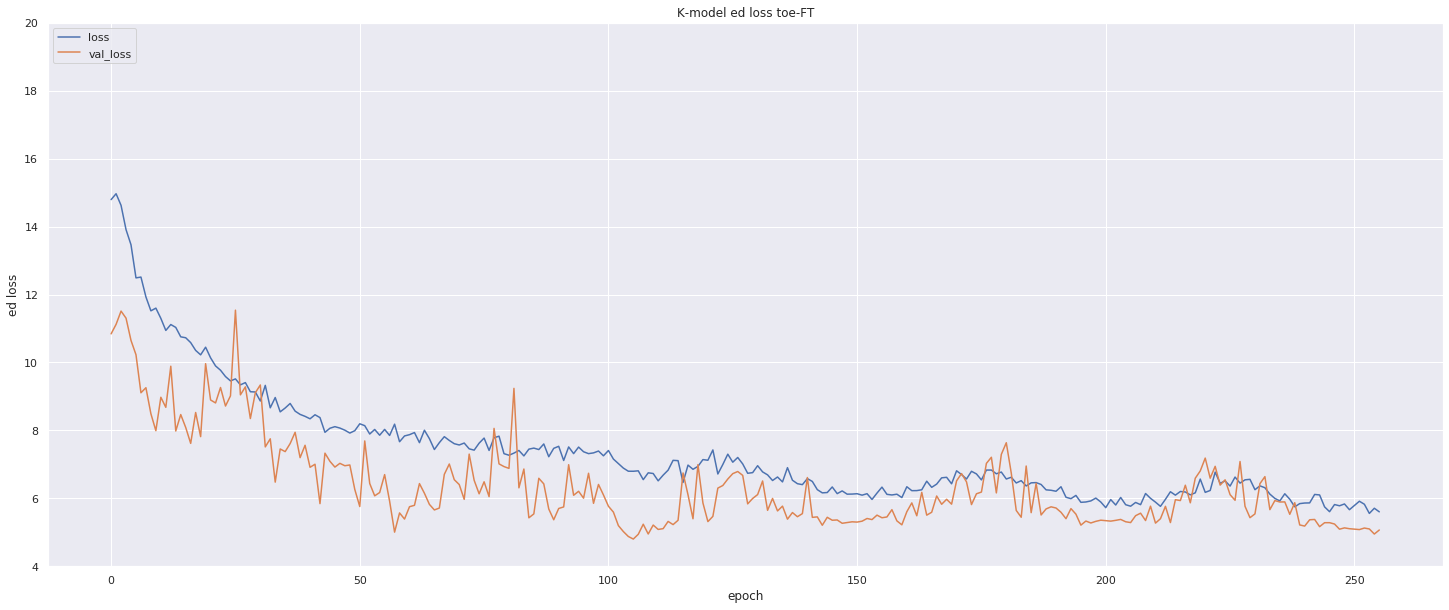

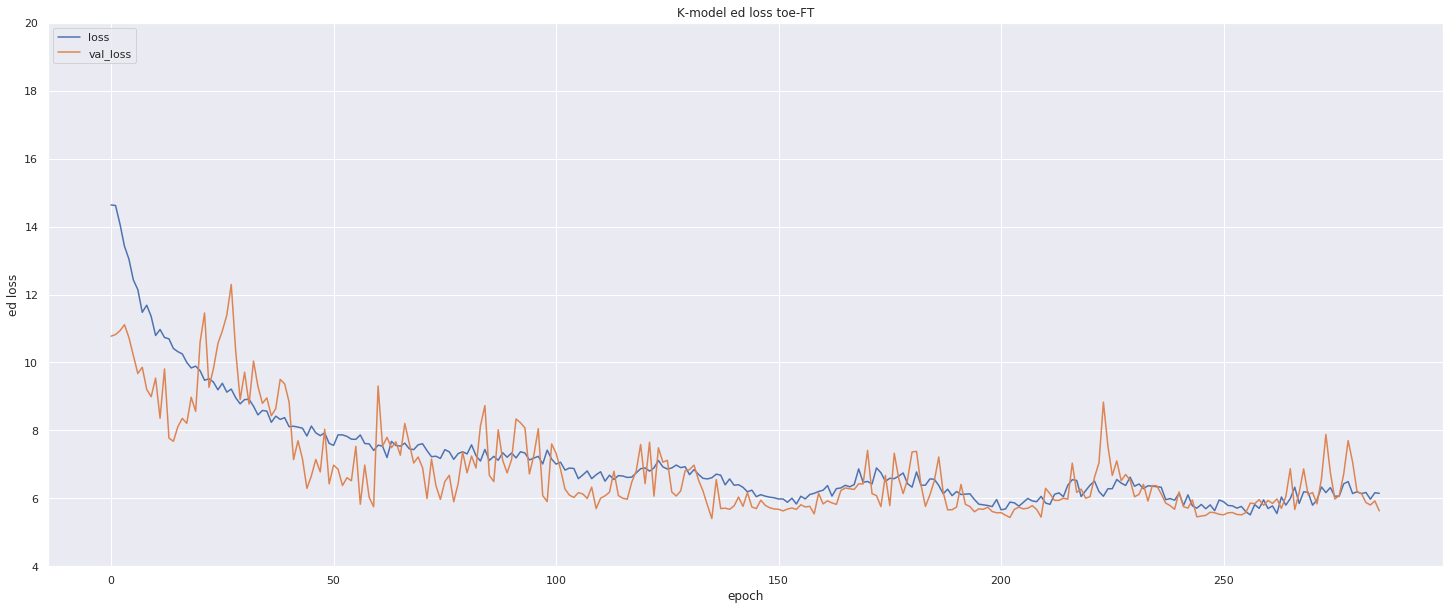

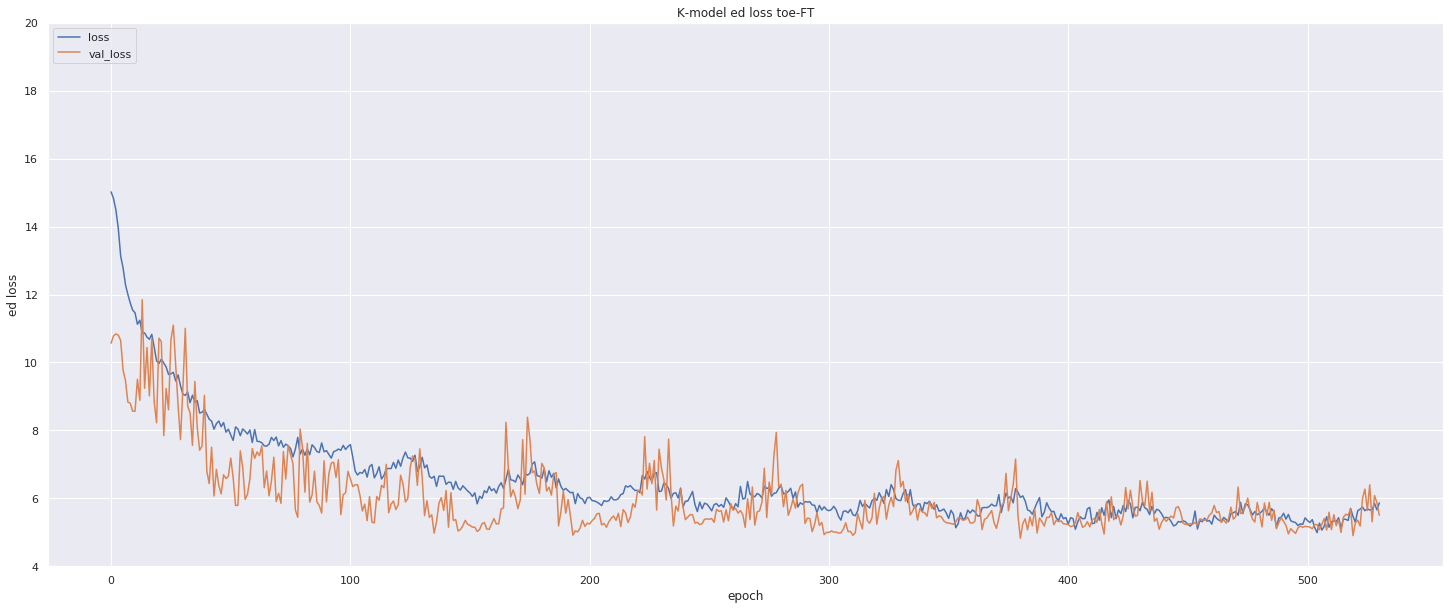

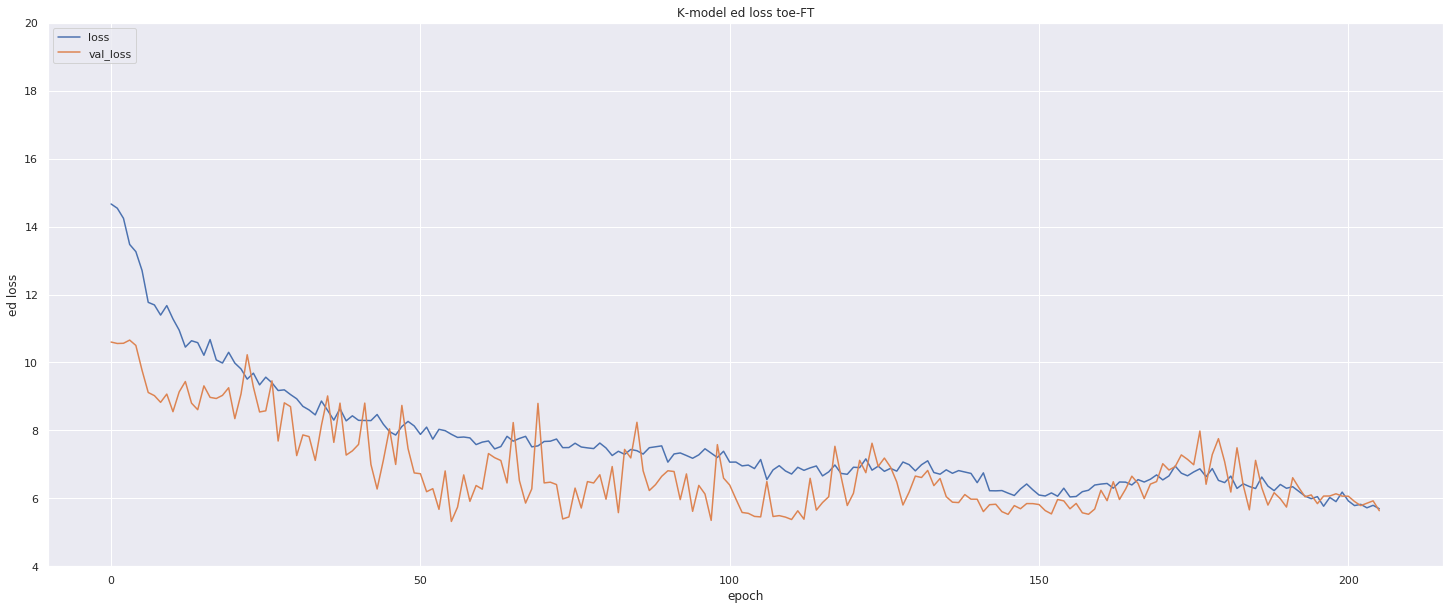

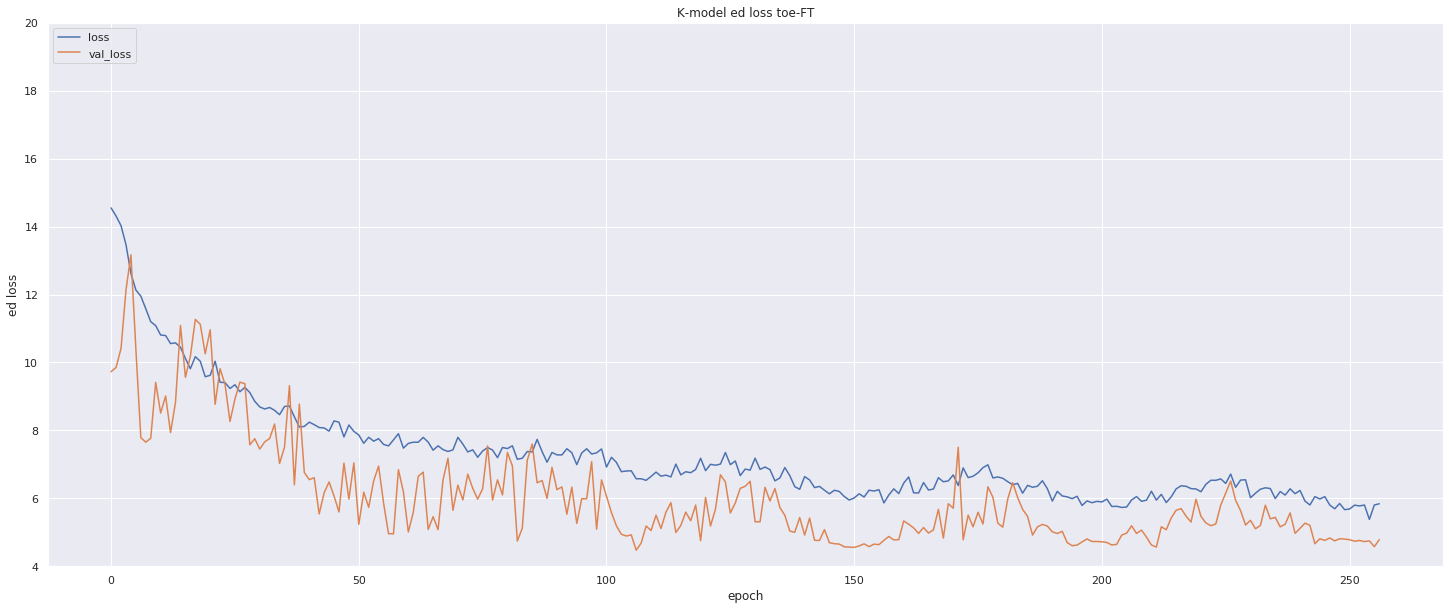

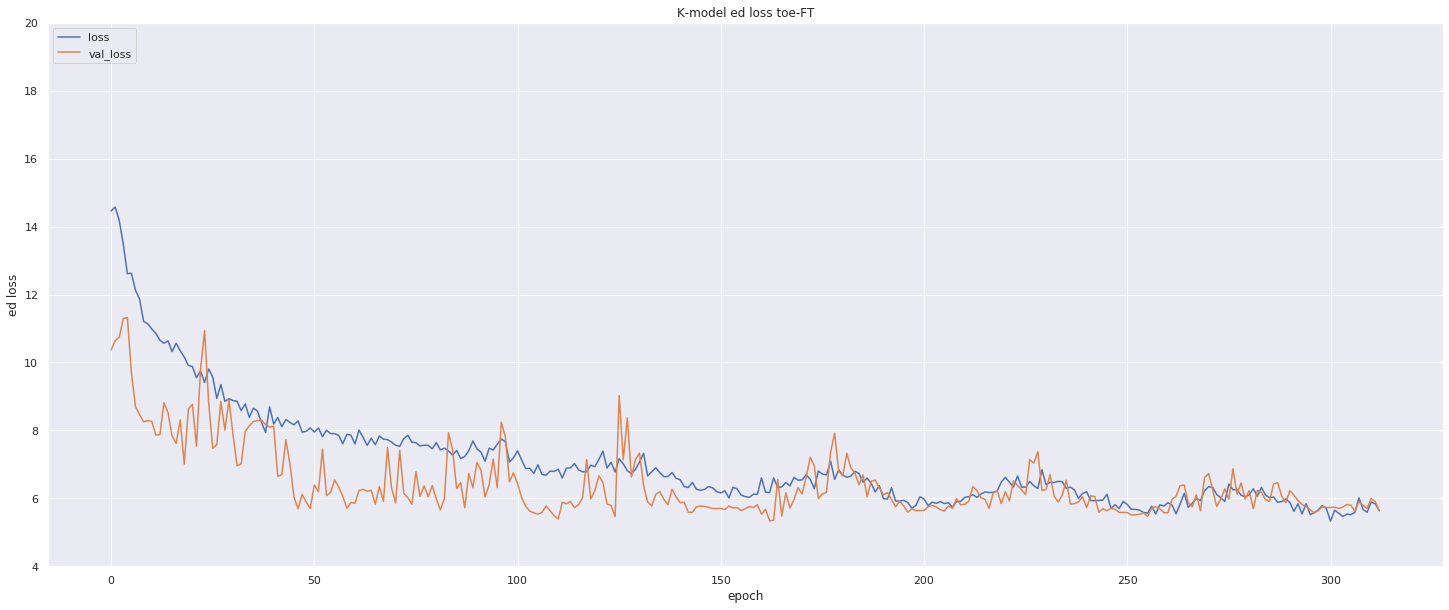

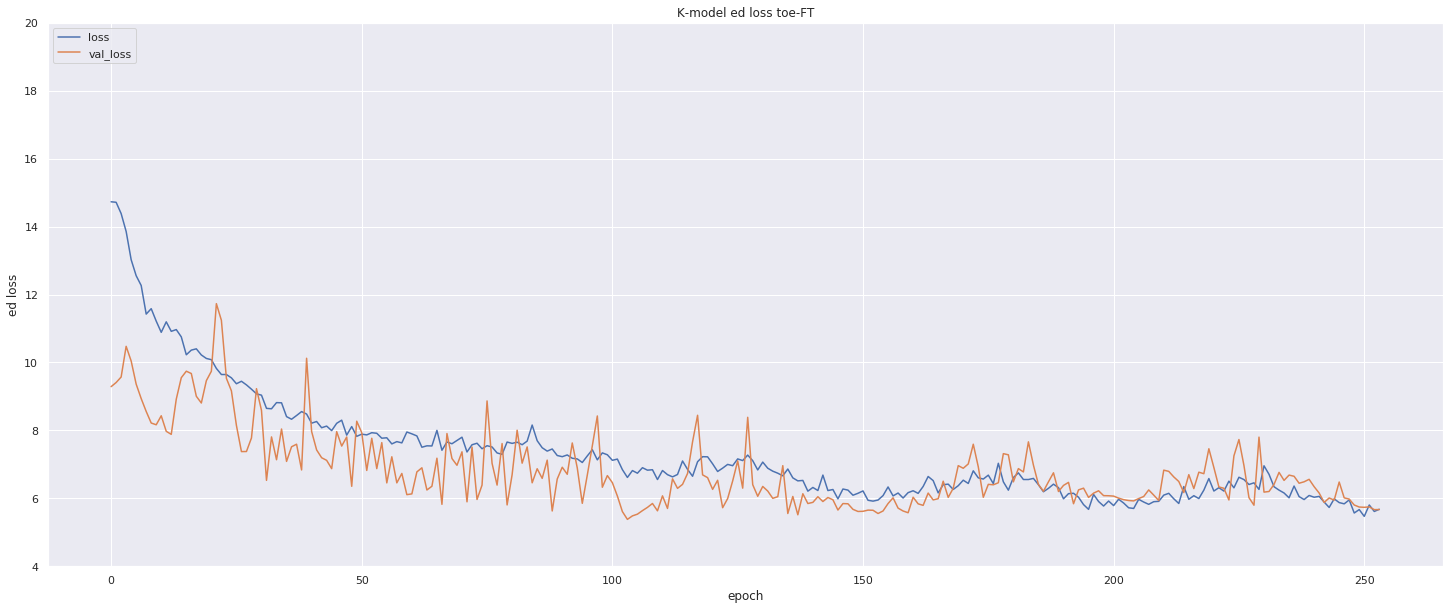

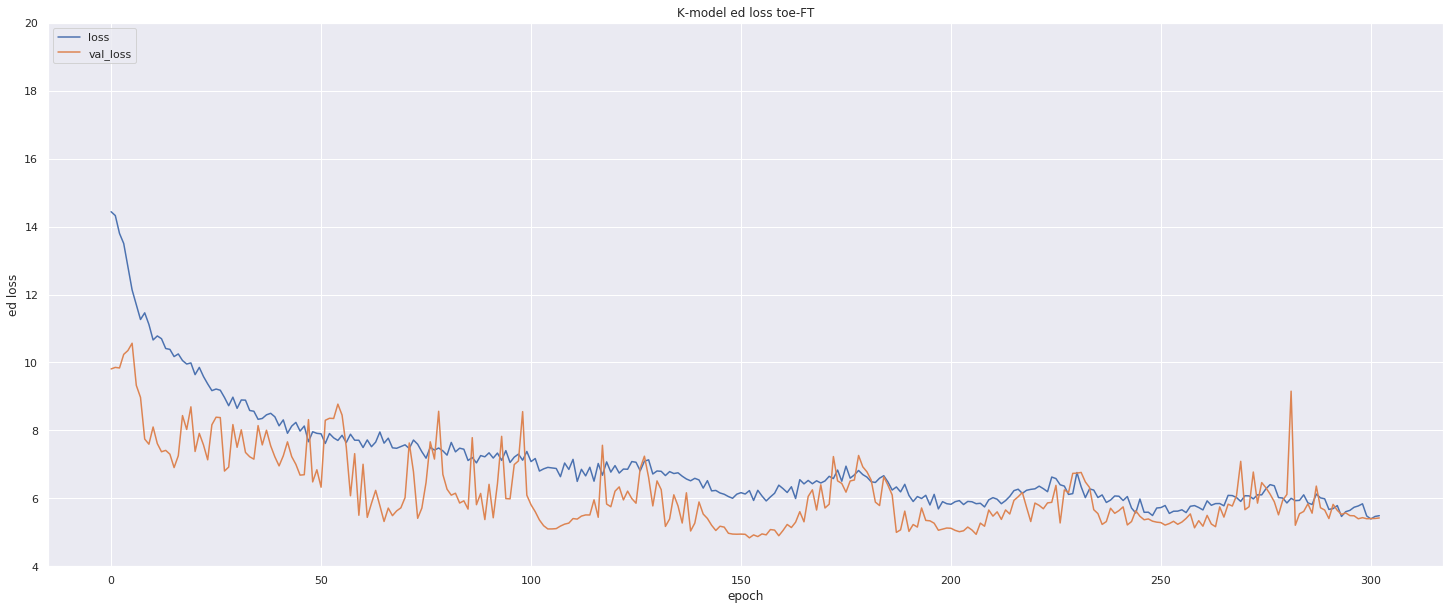

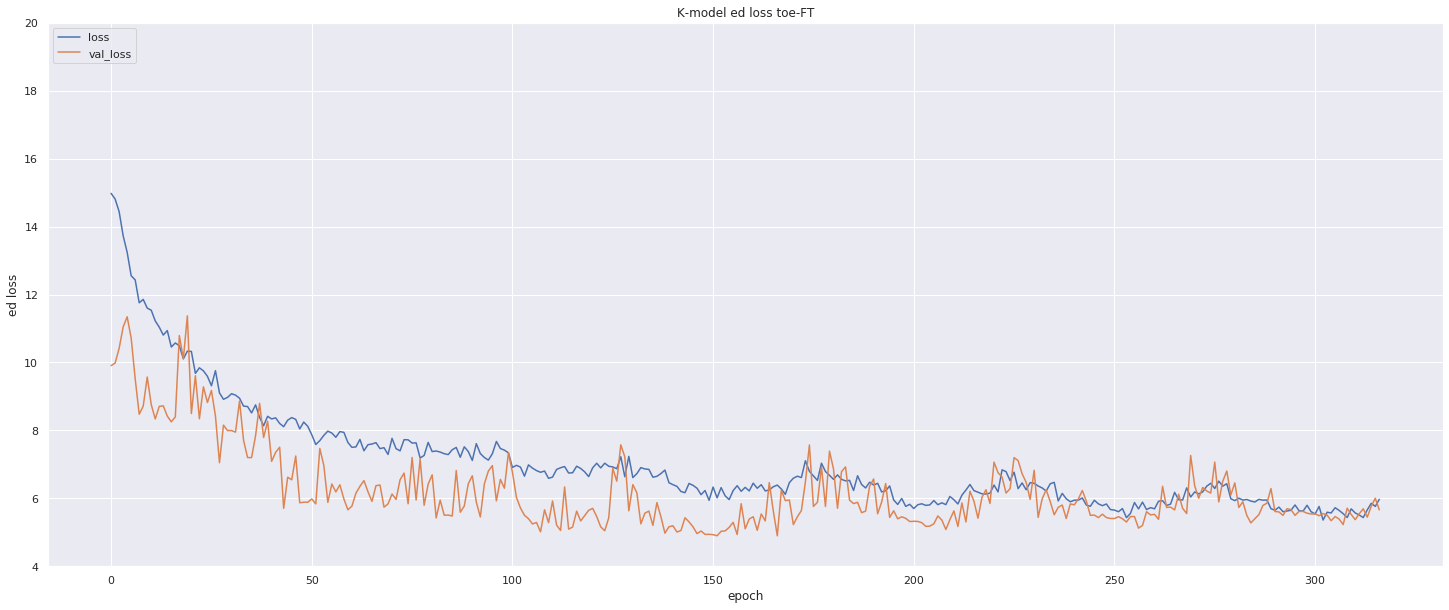

In [101]:
# Single plot loss toe-FT

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])
    plt.title('K-model ed loss toe-FT')
    plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_toe_finetune[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_FT_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

### Heel K-model removed

In [102]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
#     h_vl.append(h_v)

t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')
print(f'toe ED = {round(t_vl,5)}')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9
K:10
K:11
K:12
K:13
K:14
K:15
K:16
K:17
K:18
K:19
toe ED = 5.05657


In [103]:
# K134520210224-114845.csv
# 5.63922 + 3.34466 = 8.98389 LB:8.4890610

In [104]:
t_vl

5.056570291519165

In [105]:
# h_vl

In [106]:
t_timer.toc() #Time elapsed since t.tic()

Elapsed time is 48453.355887 seconds.
